<a href="https://colab.research.google.com/github/ImamSyabana/TugasAkhir_Nikkei225/blob/main/8020_window14_multivariate_Nikkei225_daily_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Roadmap penelitian

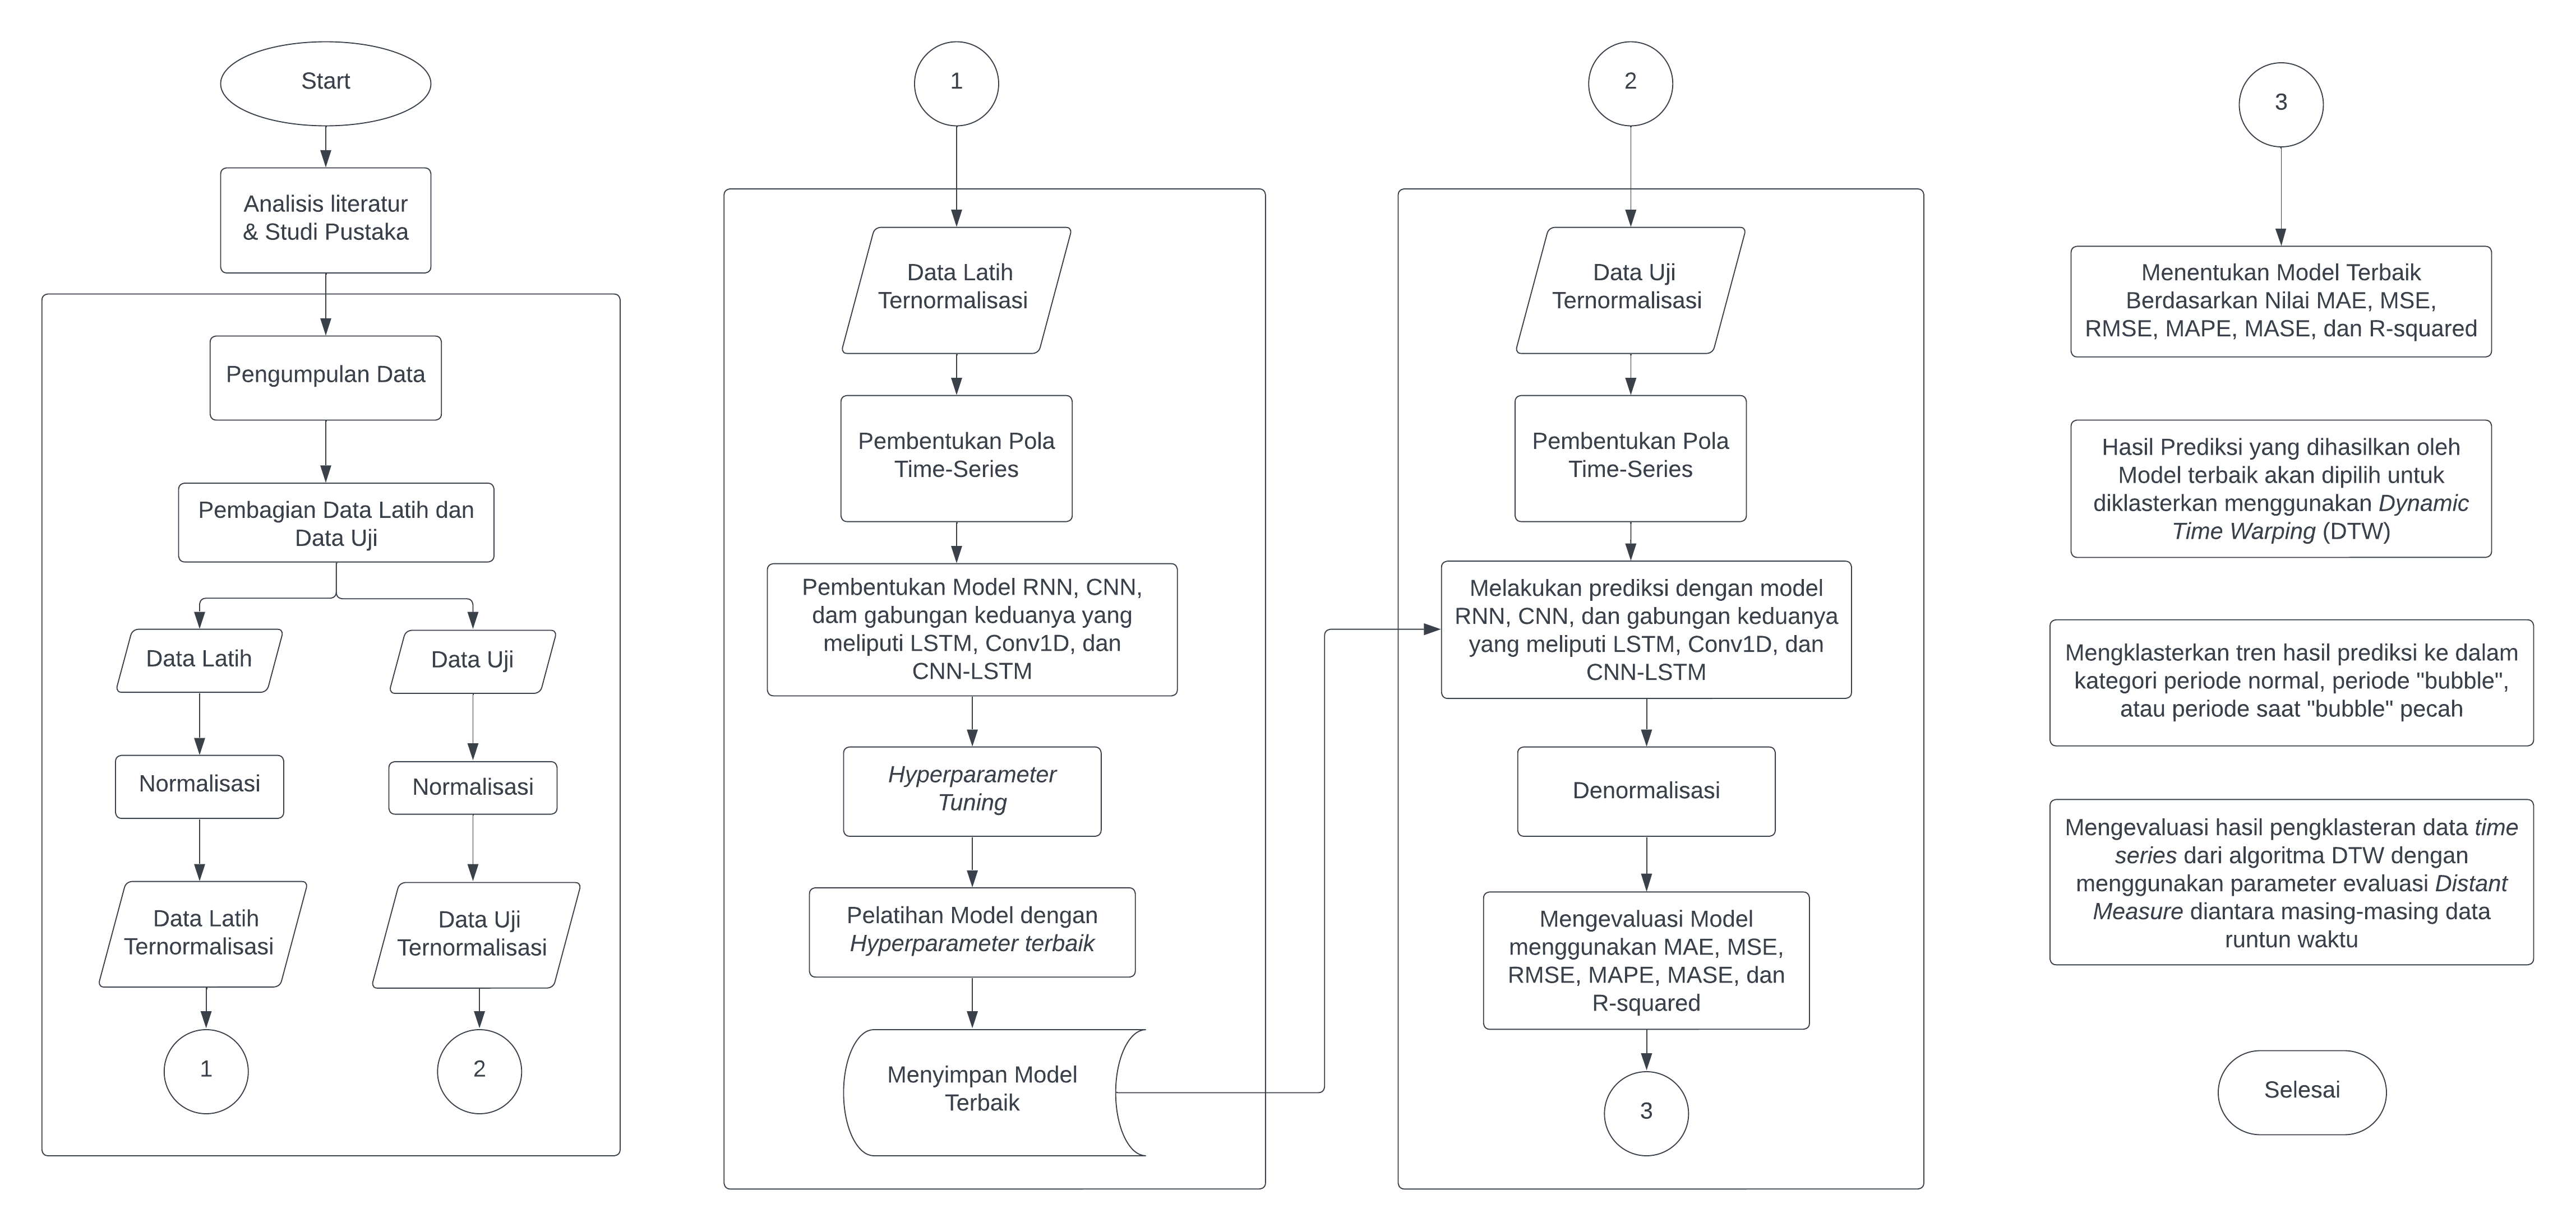

# Menghubungkan ke Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Get Data

Sumber data: https://indexes.nikkei.co.jp/en/nkave/archives/data?list=daily


mendownload data harga saham Nikkei225 dengan interval harian dari tahun 1968 sampai 2023

In [2]:
!wget https://raw.githubusercontent.com/ImamSyabana/TugasAkhir_Nikkei225/main/datasets/nikkei225/Nikkei225_daily.csv


--2024-03-21 14:04:16--  https://raw.githubusercontent.com/ImamSyabana/TugasAkhir_Nikkei225/main/datasets/nikkei225/Nikkei225_daily.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 886390 (866K) [text/plain]
Saving to: ‘Nikkei225_daily.csv’

Nikkei225_daily.csv 100%[===================>] 865.62K  --.-KB/s    in 0.05s   

2024-03-21 14:04:16 (17.6 MB/s) - ‘Nikkei225_daily.csv’ saved [886390/886390]



## Import data time series dengan pandas

In [3]:
# import dengan pandas
import pandas as pd

# konversi format nilai
def convert_value(value):
    # jika value bukan '-' merubah format desimal (contoh : 30,056 -> 30056)
    if value != '-':
        return float(value.replace(',', ''))
    else:
        return None

# membaca data saham Nikkei225
nikkei225_df = pd.read_csv("/content/Nikkei225_daily.csv",
                           parse_dates = ["Date"],
                           index_col = ["Date"],
                           converters = {'Open': convert_value,
                                         'High': convert_value,
                                         'Low': convert_value,
                                         'Close': convert_value})
                             #menentukan kolom date dan menentukan kalau kolom 1 (indeks) adalah datetime

nikkei225_df.tail()

Open      High       Low     Close
Date                                              
2024-02-22  38508.07  39156.97  38508.07  39098.68
2024-02-26  39320.64  39388.08  39181.03  39233.71
2024-02-27  39260.78  39426.29  39113.03  39239.52
2024-02-28  39189.22  39283.95  39075.47  39208.03
2024-02-29  38935.53  39250.12  38876.81  39166.19

In [4]:
nikkei225_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20078 entries, 1950-01-04 to 2024-02-29
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    9685 non-null   float64
 1   High    9685 non-null   float64
 2   Low     9685 non-null   float64
 3   Close   20078 non-null  float64
dtypes: float64(4)
memory usage: 784.3 KB


data saham hanya digunakan saat harga close

In [5]:
nikkei225_close_df = pd.DataFrame(nikkei225_df["Close"]).rename(columns={"Close": "Closing Price (Yen)"})
nikkei225_close_df.tail()


Closing Price (Yen)
Date                           
2024-02-22             39098.68
2024-02-26             39233.71
2024-02-27             39239.52
2024-02-28             39208.03
2024-02-29             39166.19

Informasi jumlah data

In [6]:
len(nikkei225_df)

20078

menampilkan missing data

In [7]:
# List the rows where the 'Close' column is nullC
rows_with_null_close = nikkei225_close_df[nikkei225_close_df['Closing Price (Yen)'].isnull()]
print(rows_with_null_close)

Empty DataFrame
Columns: [Closing Price (Yen)]
Index: []


In [8]:

nikkei225_close_df.isnull().sum()

Closing Price (Yen)    0
dtype: int64

# Bagian membuat multivariate time series dataset.

selain menggunakan data nikkei225, perdiksi harga saham akan dibantu dengan data discount rate

multivariate time series akan menambahkan fitur lebih banyak dari univariate time series yang hanya satu fitur

import file csv





In [9]:
!wget https://raw.githubusercontent.com/ImamSyabana/TugasAkhir_Nikkei225/main/datasets/discountRate/discountRate.csv

--2024-03-21 14:04:21--  https://raw.githubusercontent.com/ImamSyabana/TugasAkhir_Nikkei225/main/datasets/discountRate/discountRate.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11737 (11K) [text/plain]
Saving to: ‘discountRate.csv’

discountRate.csv    100%[===================>]  11.46K  --.-KB/s    in 0s      

2024-03-21 14:04:21 (26.5 MB/s) - ‘discountRate.csv’ saved [11737/11737]



# Import data time seres tambahan: discount rate

import data discount rate

In [10]:
# import dengan pandas
import pandas as pd
# membaca data discount rate
discRate_df = pd.read_csv("/content/discountRate.csv",
                           parse_dates = ["Date"],
                           index_col = ["Date"])
                             #menentukan kolom date dan menentukan kalau kolom 1 (indeks) adalah datetime

discRate_df[-3:]

discountRate
Date                    
2023-12-01           0.3
2024-01-01           0.3
2024-02-01           0.3

In [11]:
len(discRate_df)

890

menampilkan missing data

In [12]:
print(discRate_df.isnull().sum())

discountRate    0
dtype: int64


import data discount rate dengan modul csv.reader

In [13]:
# import dan format historikal data dengan python

import csv
from datetime import datetime

timesteps_discountRate = []
discountRate_value = []

with open("/content/discountRate.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter = ",")
  next(csv_reader) #untuk tidak membaca baris pertama berisi judul kolom
  for line in csv_reader:
    if line[1] == "null":
      continue
    timesteps_discountRate.append(datetime.strptime(line[0], "%Y/%m")) #membaca tanggal sbg DATE
    discountRate_value.append(float(line[1])) #membaca nilai discount rate


In [14]:
timesteps_discountRate[:3], discountRate_value[:3]

([datetime.datetime(1950, 1, 1, 0, 0),
  datetime.datetime(1950, 2, 1, 0, 0),
  datetime.datetime(1950, 3, 1, 0, 0)],
 [5.11, 5.11, 5.11])

In [15]:
len(discountRate_value)

890

In [16]:
type(timesteps_discountRate), type(discountRate_value)

(list, list)

In [17]:
len(discountRate_value)

890

# Mengumpulkan data menjadi satu dataframe

In [18]:
# membuat dataframe untuk mengumpulkan semua data multivariate

# copy dataframe nikkei yang masih hanya berisi harga saham
nikkei225_close_multivariate_df = nikkei225_close_df.copy()

# menambahkan kolom money stock dan dsicount rate

nikkei225_close_multivariate_df["discount_rate"] = None
nikkei225_close_multivariate_df

Closing Price (Yen) discount_rate
Date                                         
1950-01-04               108.56          None
1950-01-05               105.54          None
1950-01-06               102.64          None
1950-01-07               102.95          None
1950-01-09               102.78          None
...                         ...           ...
2024-02-22             39098.68          None
2024-02-26             39233.71          None
2024-02-27             39239.52          None
2024-02-28             39208.03          None
2024-02-29             39166.19          None

[20078 rows x 2 columns]

menggabungkan data discount rate dan money supply ke dataframe Nikkei225 closing price

In [19]:
for x in range(len(timesteps_discountRate)):
  for y in range(len(nikkei225_close_multivariate_df.index)):
    IntervalBulan_timesteps_atrYEAR = timesteps_discountRate[x].year
    IntervalBulan_timesteps_atrMONTH = timesteps_discountRate[x].month
    IntervalBulan_timesteps_atrDAY = timesteps_discountRate[x].day

    IntervalHarian_timesteps_atrYEAR = nikkei225_close_multivariate_df.index[y].year
    IntervalHarian_timesteps_atrMONTH = nikkei225_close_multivariate_df.index[y].month
    IntervalHarian_timesteps_atrDAY = nikkei225_close_multivariate_df.index[y].day

    if IntervalBulan_timesteps_atrYEAR == IntervalHarian_timesteps_atrYEAR and IntervalBulan_timesteps_atrMONTH == IntervalHarian_timesteps_atrMONTH:
      string_tanggal = "{tahun}-{bulan}-{tanggal}".format(tahun = IntervalHarian_timesteps_atrYEAR, bulan = IntervalHarian_timesteps_atrMONTH, tanggal = IntervalHarian_timesteps_atrDAY)
      date_to_index = pd.to_datetime(string_tanggal)
      nikkei225_close_multivariate_df.loc[date_to_index, "discount_rate"] = discountRate_value[x]

In [20]:
discRate_df[80:90]

discountRate
Date                    
1956-09-01          7.30
1956-10-01          7.30
1956-11-01          7.30
1956-12-01          7.30
1957-01-01          7.30
1957-02-01          7.30
1957-03-01          7.67
1957-04-01          7.67
1957-05-01          8.40
1957-06-01          8.40

In [21]:
nikkei225_close_multivariate_df[11520:11600]

Closing Price (Yen) discount_rate
Date                                         
1989-04-26             33434.93           2.5
1989-04-27             33500.83           2.5
1989-04-28             33713.35           2.5
1989-05-01             33793.17          3.25
1989-05-02             33954.99          3.25
...                         ...           ...
1989-08-14             34671.62          3.25
1989-08-15             34810.69          3.25
1989-08-16             35084.15          3.25
1989-08-17             35090.11          3.25
1989-08-18             35063.14          3.25

[80 rows x 2 columns]

In [22]:
type(nikkei225_close_multivariate_df.index.tolist())

list

# Visualisasi data : Membuat fungsi untuk visualisasi (plotting)


In [23]:
# membuat fungsi untuk menggambar data time series

import matplotlib.pyplot as plt

def plot_time_series(timesteps, values, format= ".", start = 0, end =None, label = None, color = None):
  """
  Memvisualisasikan timesteps (serangkaian keterangan waktu dengan interval tertentu) terhadap nilainya pada timesteps yang bersesuaian
  Parameters
  -------------
  timesteps : kumpulan timestep
  values : kumpulan nilai (saham dan discount Rate)
  format : style grafik, default "."
  start : timesteps rentang awal yang divisualisasi
  end : timesteps rentang akhir yang divisualisasi
  label : untuk memberi keterangan grafik
  """
  plt.plot(timesteps[start:end], values[start:end], format, label=label, color = color)
  plt.xlabel("Tanggal")
  plt.ylabel("Saham Nikkei225 Penutupan (harian)")
  if label:
    plt.legend(fontsize = 14)
  plt.grid(True)


Visualisasi data saham nikkei225

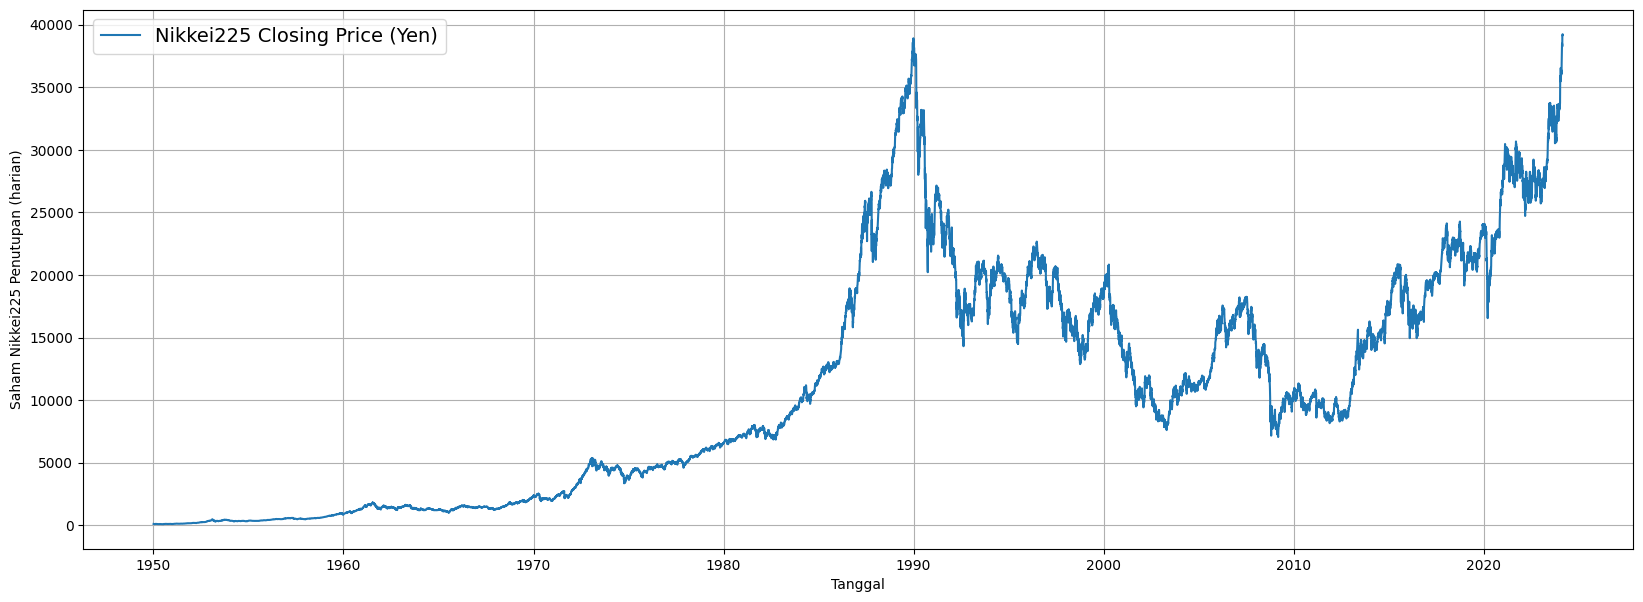

In [24]:

plt.figure(figsize = (20,7))
plot_time_series(timesteps = nikkei225_close_multivariate_df.index.tolist(), values = nikkei225_close_multivariate_df['Closing Price (Yen)'].tolist(), format = "-", label = "Nikkei225 Closing Price (Yen)")


Visualisasi data discount rate

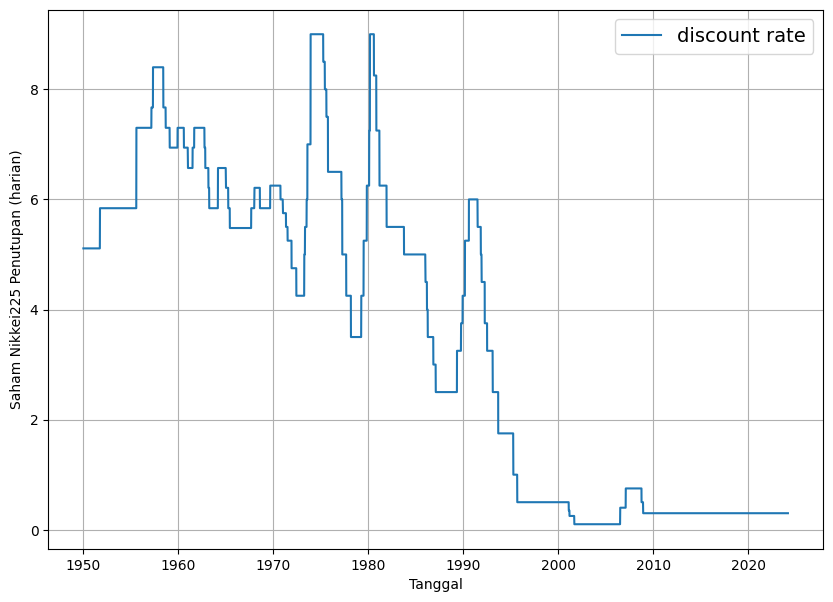

In [25]:

plt.figure(figsize = (10,7))
plot_time_series(timesteps = nikkei225_close_multivariate_df.index.tolist(), values = nikkei225_close_multivariate_df['discount_rate'].tolist(), format = "-", label = "discount rate")


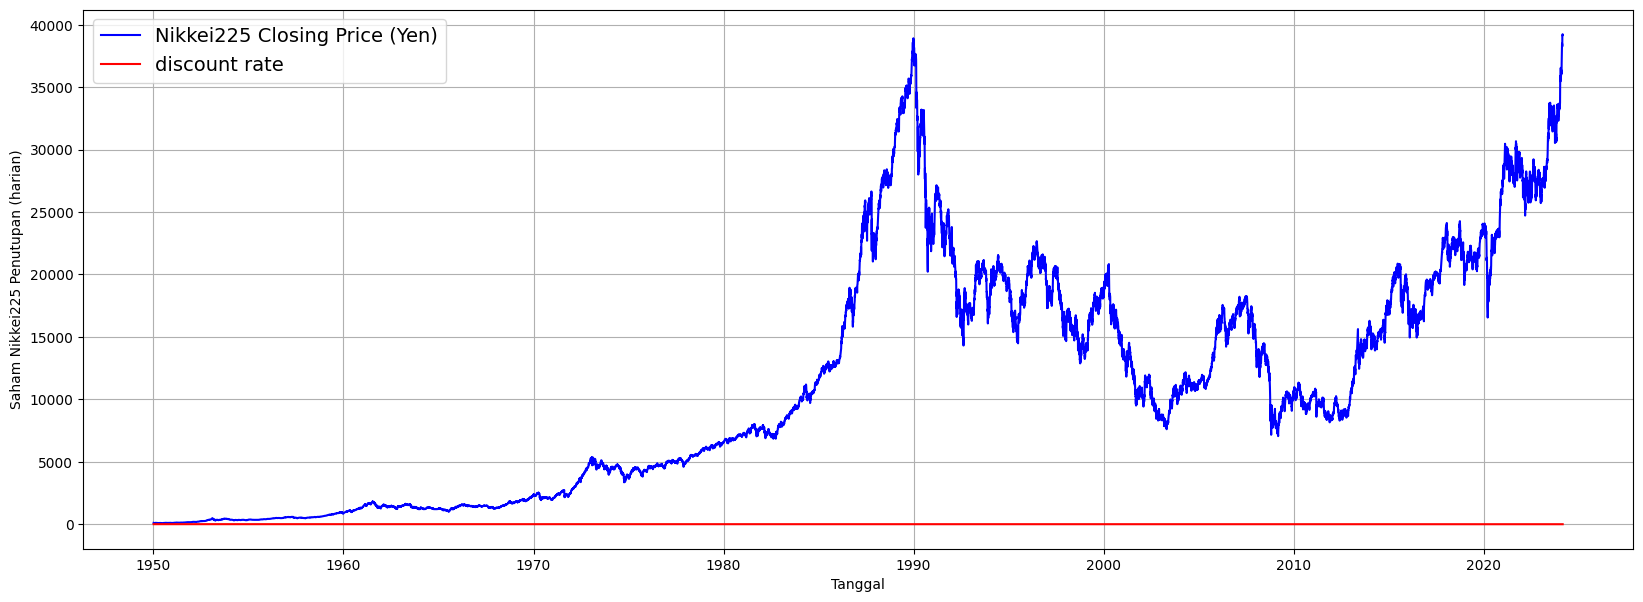

In [26]:
plt.figure(figsize = (20,7))
plot_time_series(timesteps = nikkei225_close_multivariate_df.index.tolist(), values = nikkei225_close_multivariate_df['Closing Price (Yen)'].tolist(), format = "-", label = "Nikkei225 Closing Price (Yen)", color = 'b')
plot_time_series(timesteps = nikkei225_close_multivariate_df.index.tolist(), values = nikkei225_close_multivariate_df['discount_rate'].tolist(), format = "-", label = "discount rate", color = 'r')


# Melakukan normalisasi dataset

In [27]:

from sklearn.preprocessing import MinMaxScaler

# meinputkan data ke MinMaxScaler
scaler_multivariate = MinMaxScaler(feature_range=(0, 1))
scaler_multivariate.fit(nikkei225_close_multivariate_df)

MinMaxScaler()

In [28]:
scaler_univariate = MinMaxScaler(feature_range = (0,1))

# mengimplementasikan scaler khusus univariate ke data saham nikkei225 saja
scaler_univariate.fit(nikkei225_close_df["Closing Price (Yen)"].values.reshape(-1, 1))

MinMaxScaler()

In [29]:
# Melakukan normalization
scaler_multivariate.transform(nikkei225_close_multivariate_df)

array([[5.95337367e-04, 5.62921348e-01],
       [5.18206571e-04, 5.62921348e-01],
       [4.44140575e-04, 5.62921348e-01],
       ...,
       [1.00000000e+00, 2.24719101e-02],
       [9.99195745e-01, 2.24719101e-02],
       [9.98127152e-01, 2.24719101e-02]])

membuat dataframe dengan nilai normalized

In [30]:
normalized_data  = scaler_multivariate.transform(nikkei225_close_multivariate_df)
normalized_data


array([[5.95337367e-04, 5.62921348e-01],
       [5.18206571e-04, 5.62921348e-01],
       [4.44140575e-04, 5.62921348e-01],
       ...,
       [1.00000000e+00, 2.24719101e-02],
       [9.99195745e-01, 2.24719101e-02],
       [9.98127152e-01, 2.24719101e-02]])

In [31]:
print ("dataset_normalized.shape" , normalized_data.shape)

dataset_normalized.shape (20078, 2)


In [32]:
normalized_data[:,0].reshape(-1, 1)

array([[5.95337367e-04],
       [5.18206571e-04],
       [4.44140575e-04],
       ...,
       [1.00000000e+00],
       [9.99195745e-01],
       [9.98127152e-01]])

In [33]:
type(normalized_data[:,0].reshape(-1, 1))

numpy.ndarray

In [34]:
# konversi array menjadi bentuk dataframe
scaled_nikkei225_close_multivariate_df  = pd.DataFrame(normalized_data, columns=nikkei225_close_multivariate_df.columns)


In [35]:
scaled_nikkei225_close_multivariate_df

Closing Price (Yen)  discount_rate
0                 0.000595       0.562921
1                 0.000518       0.562921
2                 0.000444       0.562921
3                 0.000452       0.562921
4                 0.000448       0.562921
...                    ...            ...
20073             0.996403       0.022472
20074             0.999852       0.022472
20075             1.000000       0.022472
20076             0.999196       0.022472
20077             0.998127       0.022472

[20078 rows x 2 columns]

LAtihan denormalisasi

In [36]:

# # Fit the scaler to your data
# scaler = MinMaxScaler()
# scaler.fit(nikkei225_close_multivariate_df[['discount_rate']])

# # Perform inverse normalization
# inverse_normalized_data = scaler.inverse_transform(scaled_nikkei225_close_multivariate_df[:, 2].reshape(-1, 1))

# print(inverse_normalized_data)

In [37]:
len(scaler_multivariate.transform(nikkei225_close_multivariate_df ))

20078

In [38]:
scaler_multivariate.transform(nikkei225_close_multivariate_df )[:,0].reshape(-1, 1)

array([[5.95337367e-04],
       [5.18206571e-04],
       [4.44140575e-04],
       ...,
       [1.00000000e+00],
       [9.99195745e-01],
       [9.98127152e-01]])

Visualisasi data yang di normalisasi

In [39]:
scaled_nikkei225_close_multivariate_df["discount_rate"]

0        0.562921
1        0.562921
2        0.562921
3        0.562921
4        0.562921
           ...   
20073    0.022472
20074    0.022472
20075    0.022472
20076    0.022472
20077    0.022472
Name: discount_rate, Length: 20078, dtype: float64

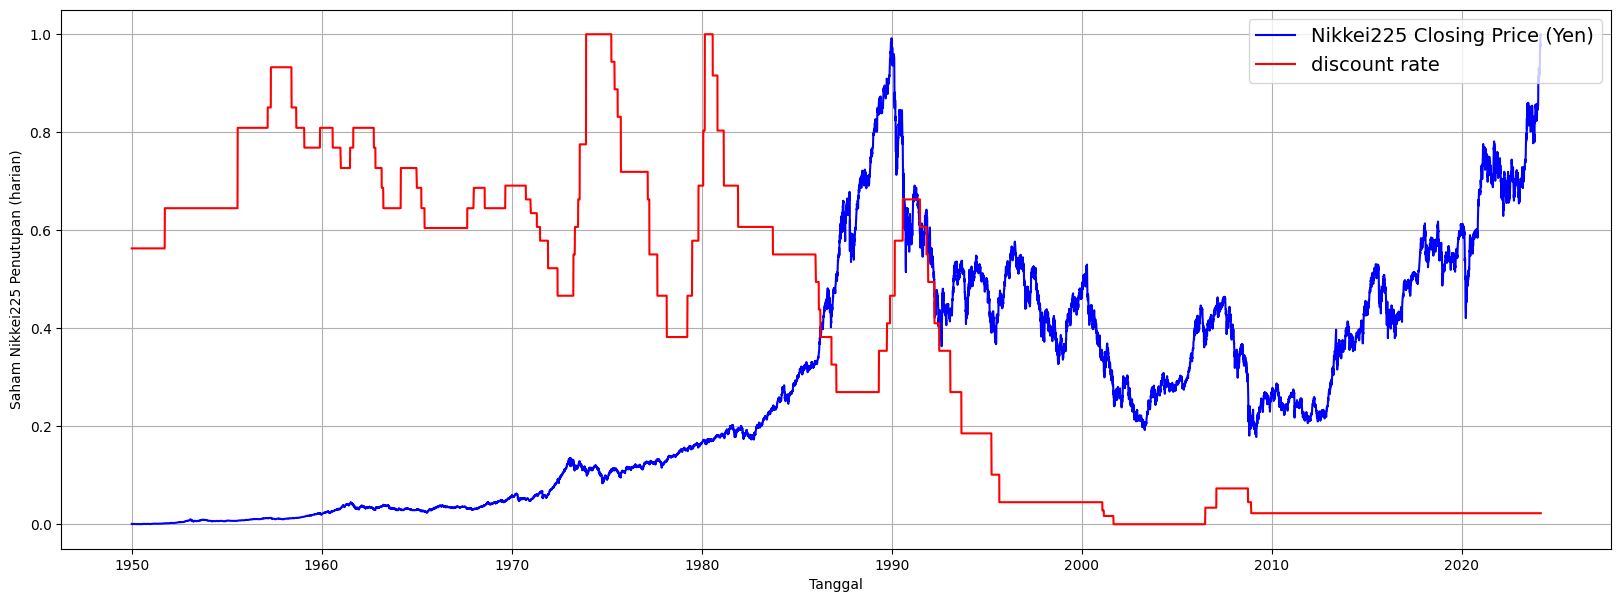

In [40]:

plt.figure(figsize = (20,7))
plot_time_series(timesteps = nikkei225_close_multivariate_df.index.tolist(), values = scaled_nikkei225_close_multivariate_df["Closing Price (Yen)"], format = "-", label = "Nikkei225 Closing Price (Yen)", color = 'b')
plot_time_series(timesteps = nikkei225_close_multivariate_df.index.tolist(), values = scaled_nikkei225_close_multivariate_df["discount_rate"], format = "-", label = "discount rate", color = 'r')


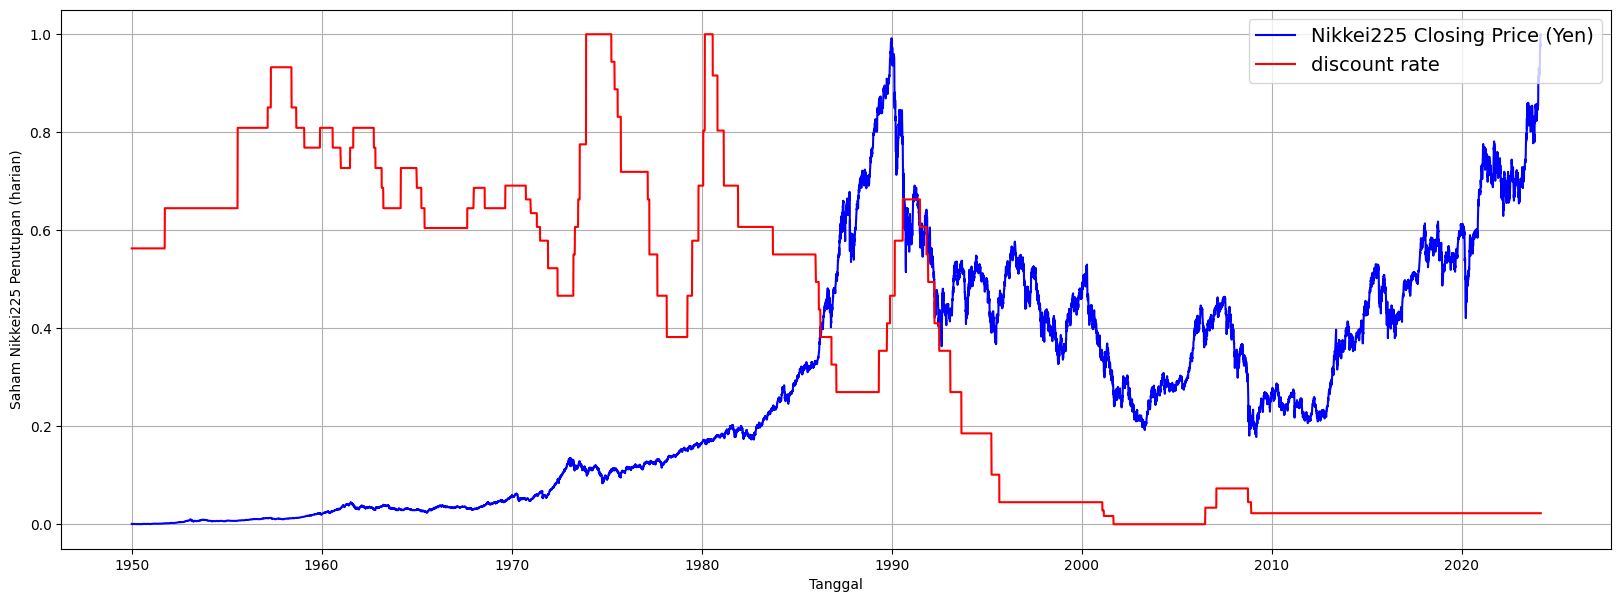

In [41]:
plt.figure(figsize = (20,7))
plot_time_series(timesteps = nikkei225_close_multivariate_df.index.tolist(), values = normalized_data[:,0], format = "-", label = "Nikkei225 Closing Price (Yen)", color = 'b')
plot_time_series(timesteps = nikkei225_close_multivariate_df.index.tolist(), values = normalized_data[:,1], format = "-", label = "discount rate", color = 'r')



# Membuat dataset multivariate menjadi format sliding window dengan pendekatan multistep multivariate time series forecasting

In [42]:
# PENGATURAN UNTUK UKURAN INPUT SEQUENCE ATAU LAG ATAU WINDOW

# HORIZON DI ATUR UNTUK MEMILIKI UKUTAN 1 UNTUK MODEL MENGELUARKAN OUTPUT SATU TIMESTEPS SETIAP PREDIKSI
HORIZON = 1
WINDOW_SIZE = 14

# PENGATURAN PRESENTASE DISTRIBUSI DALAM MEMBAGI DATASET KE DALAM TRAIN DAN TEST SET
SPLIT_SIZE = 0.8 # 80% data untuk train test 20% untuk test size

In [43]:
nikkei225_close_multivariate_df[:2]

Closing Price (Yen) discount_rate
Date                                         
1950-01-04               108.56          5.11
1950-01-05               105.54          5.11

In [44]:
scaled_nikkei225_close_multivariate_df[:2]

Closing Price (Yen)  discount_rate
0             0.000595       0.562921
1             0.000518       0.562921

membuat window dan horizon multivariate

In [45]:
# jumlah keseluruhan data sebelum dibentuk menjadi sliding window
len(scaled_nikkei225_close_multivariate_df)

20078

In [46]:
# fungsi untuk membuat sliding window

import numpy as np

def make_dataset(raw_data, WINDOW_SIZE=14, HORIZON = 1):
    _X = []
    _y = []

    for i in range(len(raw_data) - WINDOW_SIZE - HORIZON + 1):
        _X.append(raw_data[i : i + WINDOW_SIZE])
        _y.append(raw_data[i + WINDOW_SIZE : i + WINDOW_SIZE + HORIZON])
    _X = np.array(_X).reshape(len(_X), WINDOW_SIZE, 1)
    _y = np.array(_y).reshape(len(_y), HORIZON, 1)

    return _X, _y

In [47]:
from sklearn import preprocessing

columns = list(scaled_nikkei225_close_multivariate_df.columns)

# memanggil fungsi untuk membuat sliding window
Xs = []
for i in range(len(columns)):
    Xs.append((scaled_nikkei225_close_multivariate_df[columns[i]]))
Xs = np.array(Xs)

X_nikkei, y_nikkei = make_dataset(Xs[0], WINDOW_SIZE = WINDOW_SIZE, HORIZON = HORIZON)
X_discRate, y_discRate = make_dataset(Xs[1], WINDOW_SIZE = WINDOW_SIZE, HORIZON = HORIZON)


# menggabungkan data multivariate untuk windows dan label
X_concat = np.concatenate([X_nikkei, X_discRate], axis=2)
y_concat = np.concatenate([y_nikkei, y_discRate], axis=2)

In [48]:

full_windows = X_concat
full_labels = y_concat

In [49]:
len(full_windows), len(full_labels)

(20064, 20064)

In [50]:
print(full_windows[0]),
print(full_windows.shape)
print("\n")
print(full_labels[0])
print(full_labels.shape)

[[5.95337367e-04 5.62921348e-01]
 [5.18206571e-04 5.62921348e-01]
 [4.44140575e-04 5.62921348e-01]
 [4.52057975e-04 5.62921348e-01]
 [4.47716175e-04 5.62921348e-01]
 [4.11449377e-04 5.62921348e-01]
 [3.60369380e-04 5.62921348e-01]
 [3.12354183e-04 5.62921348e-01]
 [2.50036586e-04 5.62921348e-01]
 [2.97285583e-04 5.62921348e-01]
 [2.79662984e-04 5.62921348e-01]
 [2.55910786e-04 5.62921348e-01]
 [3.03925983e-04 5.62921348e-01]
 [3.48620981e-04 5.62921348e-01]]
(20064, 14, 2)


[[3.26911982e-04 5.62921348e-01]]
(20064, 1, 2)


In [51]:
print(full_windows[1]),
print(full_windows.shape)
print("\n")
print(full_labels[1])
print(full_labels.shape)

[[5.18206571e-04 5.62921348e-01]
 [4.44140575e-04 5.62921348e-01]
 [4.52057975e-04 5.62921348e-01]
 [4.47716175e-04 5.62921348e-01]
 [4.11449377e-04 5.62921348e-01]
 [3.60369380e-04 5.62921348e-01]
 [3.12354183e-04 5.62921348e-01]
 [2.50036586e-04 5.62921348e-01]
 [2.97285583e-04 5.62921348e-01]
 [2.79662984e-04 5.62921348e-01]
 [2.55910786e-04 5.62921348e-01]
 [3.03925983e-04 5.62921348e-01]
 [3.48620981e-04 5.62921348e-01]
 [3.26911982e-04 5.62921348e-01]]
(20064, 14, 2)


[[3.32019981e-04 5.62921348e-01]]
(20064, 1, 2)


In [52]:
print(full_labels[:3])
(full_labels.shape)

[[[3.26911982e-04 5.62921348e-01]]

 [[3.32019981e-04 5.62921348e-01]]

 [[3.02648983e-04 5.62921348e-01]]]


(20064, 1, 2)

format training atau test data pada **window/fitur** adalah **(jumlah sample, ukuran window, jumlah variable)**

In [53]:
full_windows.shape

(20064, 14, 2)

format training atau test data pada **label** adalah **(jumlah sample, jumlah variabel)** [Hanya memiliki dua dimensi shape jika ingin dengan benar menghasilkan output yang sesuai]

In [54]:
full_labels.shape

(20064, 1, 2)

In [55]:
full_labels = np.squeeze(full_labels)
full_labels.shape

(20064, 2)

In [56]:
full_labels[:3]

array([[3.26911982e-04, 5.62921348e-01],
       [3.32019981e-04, 5.62921348e-01],
       [3.02648983e-04, 5.62921348e-01]])

Membagi data menjadi training dataset dan test data set. Pembagian data menjadi train dan test dengan train series split dimana Test dataset akan menggunakan data yang pseusdo future (data yang seakan2 berperan dari masa depan).

In [57]:
len(full_windows[: int(SPLIT_SIZE * len(full_windows))])

16051

In [58]:
# Membagi full sliding windows menjadi windows untuk train dan test begitu pula untuk label
train_windows = full_windows[:len(full_windows[: int(SPLIT_SIZE * len(full_windows))])]
test_windows = full_windows[len(full_windows[: int(SPLIT_SIZE * len(full_windows))]):]

train_labels = full_labels[:len(full_windows[: int(SPLIT_SIZE * len(full_labels))])]
test_labels = full_labels[len(full_windows[: int(SPLIT_SIZE * len(full_labels))]):]

In [59]:
print("jumlah sliding windows keseluruhan adalah :{n_full_windows}".format(n_full_windows = len(full_windows)))

print("Sliding windows untuk train berjumlah : {n_train_windows}".format(n_train_windows = len(train_windows)))
print("Sliding windows untuk test berjumlah : {n_test_windows}".format(n_test_windows = len(test_windows)))


jumlah sliding windows keseluruhan adalah :20064
Sliding windows untuk train berjumlah : 16051
Sliding windows untuk test berjumlah : 4013


In [60]:
print("jumlah label keseluruhan adalah :{n_full_labels}".format(n_full_labels = len(full_labels)))

print("label untuk train berjumlah : {n_train_labels}".format(n_train_labels = len(train_labels)))
print("label untuk test berjumlah : {n_test_labels}".format(n_test_labels = len(test_labels)))


jumlah label keseluruhan adalah :20064
label untuk train berjumlah : 16051
label untuk test berjumlah : 4013


In [61]:
"windows", test_windows[:2], "Labels",test_labels[:2]

('windows',
 array([[[0.40333838, 0.07303371],
         [0.4012934 , 0.07303371],
         [0.40189589, 0.07303371],
         [0.409717  , 0.07303371],
         [0.40140066, 0.07303371],
         [0.41620722, 0.07303371],
         [0.41703089, 0.07303371],
         [0.41444675, 0.07303371],
         [0.41672288, 0.07303371],
         [0.41759149, 0.07303371],
         [0.42771759, 0.07303371],
         [0.42652921, 0.07303371],
         [0.42806851, 0.07303371],
         [0.43319745, 0.07303371]],
 
        [[0.4012934 , 0.07303371],
         [0.40189589, 0.07303371],
         [0.409717  , 0.07303371],
         [0.40140066, 0.07303371],
         [0.41620722, 0.07303371],
         [0.41703089, 0.07303371],
         [0.41444675, 0.07303371],
         [0.41672288, 0.07303371],
         [0.41759149, 0.07303371],
         [0.42771759, 0.07303371],
         [0.42652921, 0.07303371],
         [0.42806851, 0.07303371],
         [0.43319745, 0.07303371],
         [0.43710788, 0.07303371]]]),
 '

# LANJUT MEMBUAT FUNGSI EVALUASI DAN BIKIN MODEL

# Membuat fungsi untuk melakukan evaluasi regression problem

fungsi digunakan untuk menguji prediksi model dengan nilai sebenarnya dan menghasilkan nilai evaluasi masing-masing metrik

In [62]:
import tensorflow as tf


sehingga yang dilakukan dengan tf.reduce_mean adalah melakukan agregasi ke banyak nilai mae akibat dari horizon yang ukurannya lebih dari satu menjadi satu single value seperti yang dilakukan tensorflow

tf.reduce_mean mampu menghasilkan satu nilai mae yang sudah direratakan dan hasilnya sama dengan yang dihitung dari model saat evaluasi metrik MAE-nya dengan .evaluate, menghasilkan nilai MAE yang sama-sama 892.1709

In [63]:
def evaluate_preds(y_true, y_pred):
  #Pastikan data yang diproses dengan library tensorflow bertipe float32
  y_true = tf.cast(y_true, dtype = tf.float32) #karena metrik evaluasi dari library tensorflow bisa
  y_pred = tf.cast(y_pred, dtype = tf.float32) #memunculkan error jika tipe bukan float32

  y_true = tf.squeeze(y_true)
  y_pred = tf.squeeze(y_pred)

  # menghitung metrik evaluasi regression problem
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)

  # kalkulasi nilai R-square
  from sklearn.metrics import r2_score
  Rsquare = r2_score(y_true, y_pred)



  ## memperhitungkan berbagai ukuran metrics
  # (artinya untuk horizon atau label yang dimensinya (fiturnya) lebih dari satu akan menghasilkan metrics (ex: MAE) yang berukuran dimensi lbh dari satu,
  # sehingga perlu di lakukan tf.reduce_mean lebih lanjut supaya menghasilkan single value metrics)
  # Artinya nilai MAE yang di reduce_mean adalah gabungan dari MAE dari beberapa fitur tersebut

  # Calculate various metrics
  # (meaning for larger horizon will produce metrics (ex: MAE) with larger dimension,
  # so tf.reduce_mean is needed to produce single value metrics)
  if mae.ndim>0:
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    #Rsquare = tf.reduce_mean(Rsquare)

    # Calculate R-square value
    from sklearn.metrics import r2_score
    Rsquare = np.mean([r2_score(y_true[:, i], y_pred[:, i]) for i in range(y_true.shape[1])])

  return {"mae" : mae.numpy(), #ditampilkan dalam bentuk numpy bukan tensor
          "mse" : mse.numpy(),
          "rmse" : rmse.numpy(),
          "R-square" : Rsquare}


# membuat modelling checkpoint

karena model akan belajar terus menerus pada masing-masing epoch, diantara epoch-epoch tersebut dapat menghasilkan pembelajaran terbaik tidak hanya di eopch terakhir saja. Maka dari itu, epoch yang memiliki hasil terbaik akan di simpan selama training.  

Dengan menyimpan epoch yang terbaik, model yang akan dibuat adalah model yang terbaik dan dapat dibandingkan dengan model terbaik lainnya secara adil.

Untuk membuat modelling checkpoint callback digunakan: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [64]:
# membuat modelling checkpoint

import os # membuat folder untuk menyimpan best model

# mmebuat function untuk implementasi ModelCheckpoint callback
def create_model_checkpoint(model_name, save_path = "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch"):
  return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path, model_name),
                                                                    monitor = "val_loss",
                                                                    verbose = 1,
                                                                    save_best_only = True)

In [65]:
train_windows.shape

(16051, 14, 2)

In [66]:
train_windows[0:2]

array([[[5.95337367e-04, 5.62921348e-01],
        [5.18206571e-04, 5.62921348e-01],
        [4.44140575e-04, 5.62921348e-01],
        [4.52057975e-04, 5.62921348e-01],
        [4.47716175e-04, 5.62921348e-01],
        [4.11449377e-04, 5.62921348e-01],
        [3.60369380e-04, 5.62921348e-01],
        [3.12354183e-04, 5.62921348e-01],
        [2.50036586e-04, 5.62921348e-01],
        [2.97285583e-04, 5.62921348e-01],
        [2.79662984e-04, 5.62921348e-01],
        [2.55910786e-04, 5.62921348e-01],
        [3.03925983e-04, 5.62921348e-01],
        [3.48620981e-04, 5.62921348e-01]],

       [[5.18206571e-04, 5.62921348e-01],
        [4.44140575e-04, 5.62921348e-01],
        [4.52057975e-04, 5.62921348e-01],
        [4.47716175e-04, 5.62921348e-01],
        [4.11449377e-04, 5.62921348e-01],
        [3.60369380e-04, 5.62921348e-01],
        [3.12354183e-04, 5.62921348e-01],
        [2.50036586e-04, 5.62921348e-01],
        [2.97285583e-04, 5.62921348e-01],
        [2.79662984e-04, 5.62921

In [67]:
train_labels[0:2]

array([[3.26911982e-04, 5.62921348e-01],
       [3.32019981e-04, 5.62921348e-01]])

In [68]:
train_labels.shape

(16051, 2)

In [69]:
test_windows.shape

(4013, 14, 2)

In [70]:
test_labels.shape

(4013, 2)

In [71]:
# keterangan jumlah feature
test_labels.shape[1]

2

Mulai membuat model Keras

In [72]:
import tensorflow as tf
from tensorflow.keras import layers

In [73]:
from keras import Model
from keras.layers import Input, Dense, Bidirectional, LSTM, RepeatVector, TimeDistributed
from sklearn.preprocessing import MinMaxScaler
from numpy import array, hstack
import numpy as np

# Model 1: Conv1D

In [74]:
!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.6 MB/s eta 0:00:00


In [75]:
import tensorflow as tf
from tensorflow import keras
from kerastuner.tuners import RandomSearch


<ipython-input-75-b420bea64af7>:3: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [76]:
# import library untuk mmebuat model

import tensorflow as tf
from tensorflow.keras import layers

In [77]:
train_windows.shape

(16051, 14, 2)

In [78]:
train_labels.shape

(16051, 2)

In [79]:
test_windows.shape

(4013, 14, 2)

In [80]:
test_labels.shape

(4013, 2)

In [81]:
test_labels.shape[1]

2

## Tuner Builder

In [ ]:
#membuat model Conv1D
def model_Conv1D_multi_builder(hp):
  tf.random.set_seed(42)

  model_1 = tf.keras.models.Sequential([


      #layers.Lambda(lambda x: tf.expand_dims(x, axis = 1)),
      tf.keras.layers.Conv1D(filters = hp.Int('conv1D_n_filters', min_value=32, max_value=256, step=32),
                             kernel_size = hp.Int('conv1D_kernel_size', min_value=5, max_value=10, step=1),
                             strides = 1,
                             padding ="causal",
                             activation = "relu",
                             input_shape=[train_windows.shape[1], train_windows.shape[2]]),

      tf.keras.layers.GlobalMaxPooling1D(),  # Add GlobalMaxPooling1D layer
      tf.keras.layers.Dense(test_labels.shape[1])
      #filters adalah jumlah hidden unit dalam layers tersebut
      # kernel size adalah ukuran dari window. Ex: kernel_size = 7 artinya melihat 7 value sekaligus
      # default nilai strides = 1, ini sudah sesuai karena sliding window bergeser satu timesteps
  ], name = "model_1_conv1D_multivariate")

  #compile model 1
  model_1.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_1


In [ ]:
import keras_tuner as kt

tuner_Conv1D_multi = kt.Hyperband(model_Conv1D_multi_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_tuning_logs',
                     project_name='Conv1D_multivariate')

## Proses tuning


In [ ]:
tuner_Conv1D_multi.search(train_windows,
                          train_labels,
                          epochs=10,
                          validation_data=(test_windows, test_labels),
                          batch_size = 128)

Trial 30 Complete [00h 00m 07s]
val_loss: 0.007926583290100098

Best val_loss So Far: 0.006080969236791134
Total elapsed time: 00h 02m 10s


## Hasil parameter tuning terbaik

In [ ]:
tuner_Conv1D_multi.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# mengeluarkan hyperparameter optimal
best_hps=tuner_Conv1D_multi.get_best_hyperparameters(num_trials=1)[0]

tuning = ['conv1D_n_filters', 'conv1D_kernel_size', 'learning_rate']
print('Best tune model Conv1D multivariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model Conv1D multivariate:
conv1D_n_filters: 224
conv1D_kernel_size: 8
learning_rate: 0.01


## Hasil semua parameter tuning

In [ ]:
tuning =['conv1D_n_filters', 'conv1D_kernel_size', 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hps_all =tuner_Conv1D_multi.get_best_hyperparameters(num_trials=30)
for hps in hps_all:
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam = pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_best_hyperparameter_models/hp_Conv1D_multi.csv')
df_hyparam


conv1D_n_filters  conv1D_kernel_size  learning_rate
0                224                   8         0.0100
1                128                  10         0.0010
2                 96                   8         0.0010
3                224                   8         0.0100
4                224                  10         0.0001
5                224                   7         0.0010
6                 96                   8         0.0010
7                224                   7         0.0010
8                 32                   8         0.0100
9                128                  10         0.0010
10               160                   9         0.0010
11               128                  10         0.0010
12               160                   9         0.0010
13               128                   8         0.0100
14                32                   5         0.0010
15                64                   9         0.0010
16                96                   8         0.0010
17               128                  10         0.0001
18                32                   9         0.0100
19                64                   9         0.0010
20                96                   8         0.0100
21               128                   6         0.0100
22                64                   8         0.0001
23               224                   9         0.0100
24               256                   9         0.0100
25               160                   7         0.0001
26               256                   6         0.0001
27               224                   6         0.0001
28               128                   8         0.0001
29                64                   7         0.0001

In [ ]:
tuner_Conv1D_multi.results_summary(num_trials=30)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_tuning_logs/Conv1D_multivariate
Showing 30 best trials
Objective(name="val_loss", direction="min")

Trial 0024 summary
Hyperparameters:
conv1D_n_filters: 224
conv1D_kernel_size: 8
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.006080969236791134

Trial 0017 summary
Hyperparameters:
conv1D_n_filters: 128
conv1D_kernel_size: 10
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.00633713323622942

Trial 0016 summary
Hyperparameters:
conv1D_n_filters: 96
conv1D_kernel_size: 8
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0015
Score: 0.0065132318995893

Trial 0022 summary
Hyperparameters:
conv1D_n_filters: 224
conv1D_kernel_size: 8
learning_rate: 0.01
tuner/epochs: 4
tuner/initial_epoc

## Mengimplementasikan hyperparameter terbaik ke model

In [ ]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_1 = tuner_Conv1D_multi.hypermodel.build(best_hps)

## Melatih model

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_1 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_1_Conv1D_multivariate.h5")

In [ ]:
# fit
history = model_1.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_1.name)])

Epoch 1/50
120/126 [===========================>..] - ETA: 0s - loss: 0.0367
Epoch 1: val_loss improved from inf to 0.00886, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_1_conv1D_multivariate
126/126 [==============================] - 2s 10ms/step - loss: 0.0358 - val_loss: 0.0089
Epoch 2/50
121/126 [===========================>..] - ETA: 0s - loss: 0.0169
Epoch 2: val_loss did not improve from 0.00886
126/126 [==============================] - 0s 4ms/step - loss: 0.0168 - val_loss: 0.0125
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 0.0157
Epoch 3: val_loss did not improve from 0.00886
126/126 [==============================] - 0s 4ms/step - loss: 0.0157 - val_loss: 0.0124
Epoch 4/50
119/126 [===========================>..] - ETA: 0s - loss: 0.0149
Epoch 4: val_loss did not improve from 0.00886
126/126 [==============================] - 0s 4ms/step - loss: 0.0148 - val_loss: 0.0136
Epoch 5/50


visualisasi model shape

In [ ]:
model_1.summary()

Model: "model_1_conv1D_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 14, 224)           3808      
                                                                 
 global_max_pooling1d_1 (Gl  (None, 224)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 2)                 450       
                                                                 
Total params: 4258 (16.63 KB)
Trainable params: 4258 (16.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


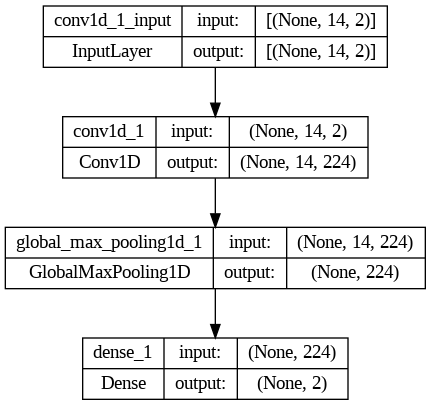

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_1, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_plot/model_Conv1D_multi_shape.png', show_shapes=True, show_layer_names=True)


visualisasi loss setiap epoch

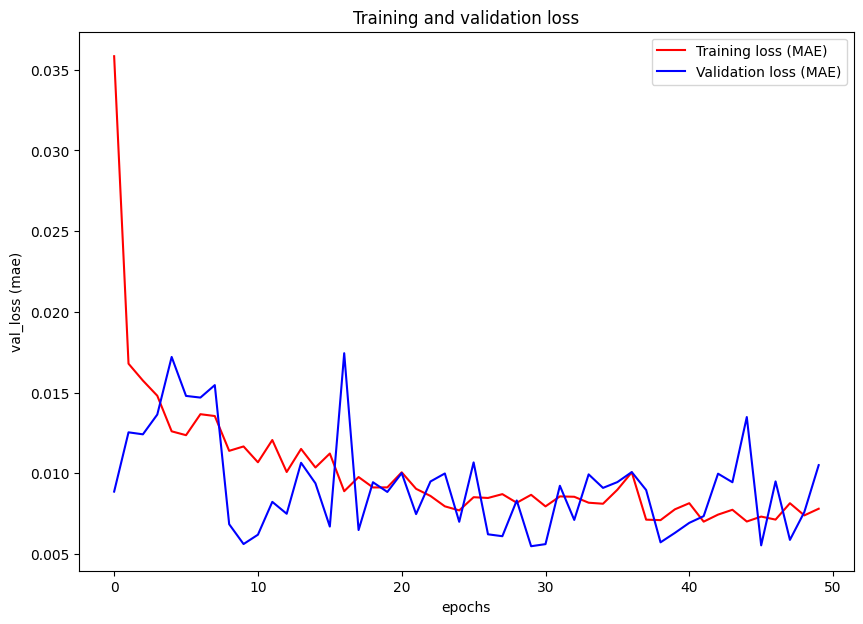

In [ ]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.title ('Training and validation loss')
plt.legend(loc=0)



# simpan visualisasi loss per epoch menjadi image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_visualization/loss_Conv1D_multi.png')


# Membuat DataFrame loss dan val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan value loss dan validation loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_value_per_epoch/loss_Conv1D_multi.csv', index=False)


In [ ]:
# mengevaluasi model 1 dari epochs terakhir
model_1.evaluate(test_windows, test_labels)

126/126 [==============================] - 0s 3ms/step - loss: 0.0105


0.010501374490559101

In [ ]:
# mengevaluasi dan load model 1 pada best epoch yang loss mae paling kecil sepanjang training

model_1 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_1_conv1D_multivariate")
model_1.evaluate(test_windows, test_labels)


126/126 [==============================] - 0s 2ms/step - loss: 0.0055


0.0054769511334598064

In [ ]:
# membuat predicted value berdasarkan model multivariate model_1 yang sudah di train

model_1_preds = tf.squeeze(model_1.predict(test_windows))
model_1_preds


126/126 [==============================] - 1s 2ms/step


<tf.Tensor: shape=(4013, 2), dtype=float32, numpy=
array([[0.42582092, 0.07128163],
       [0.42911074, 0.07147118],
       [0.43077087, 0.07139695],
       ...,
       [0.9931332 , 0.01090089],
       [0.99746275, 0.01097151],
       [1.0004113 , 0.01128007]], dtype=float32)>

## Denormalisasi nilai output prediksi dan test_labels

In [ ]:
denormalized_model_1_preds = scaler_multivariate.inverse_transform(model_1_preds)
denormalized_test_labels = scaler_multivariate.inverse_transform(test_labels)

In [ ]:
# mengukur predicted value kedua time series dengan metrik evaluasi regresion problem

model_1_results = evaluate_preds(y_true = denormalized_test_labels,
                                 y_pred = denormalized_model_1_preds)

model_1_results

{'mae': 185.21228,
 'mse': 158514.22,
 'rmse': 261.92032,
 'R-square': 0.976396794916444}

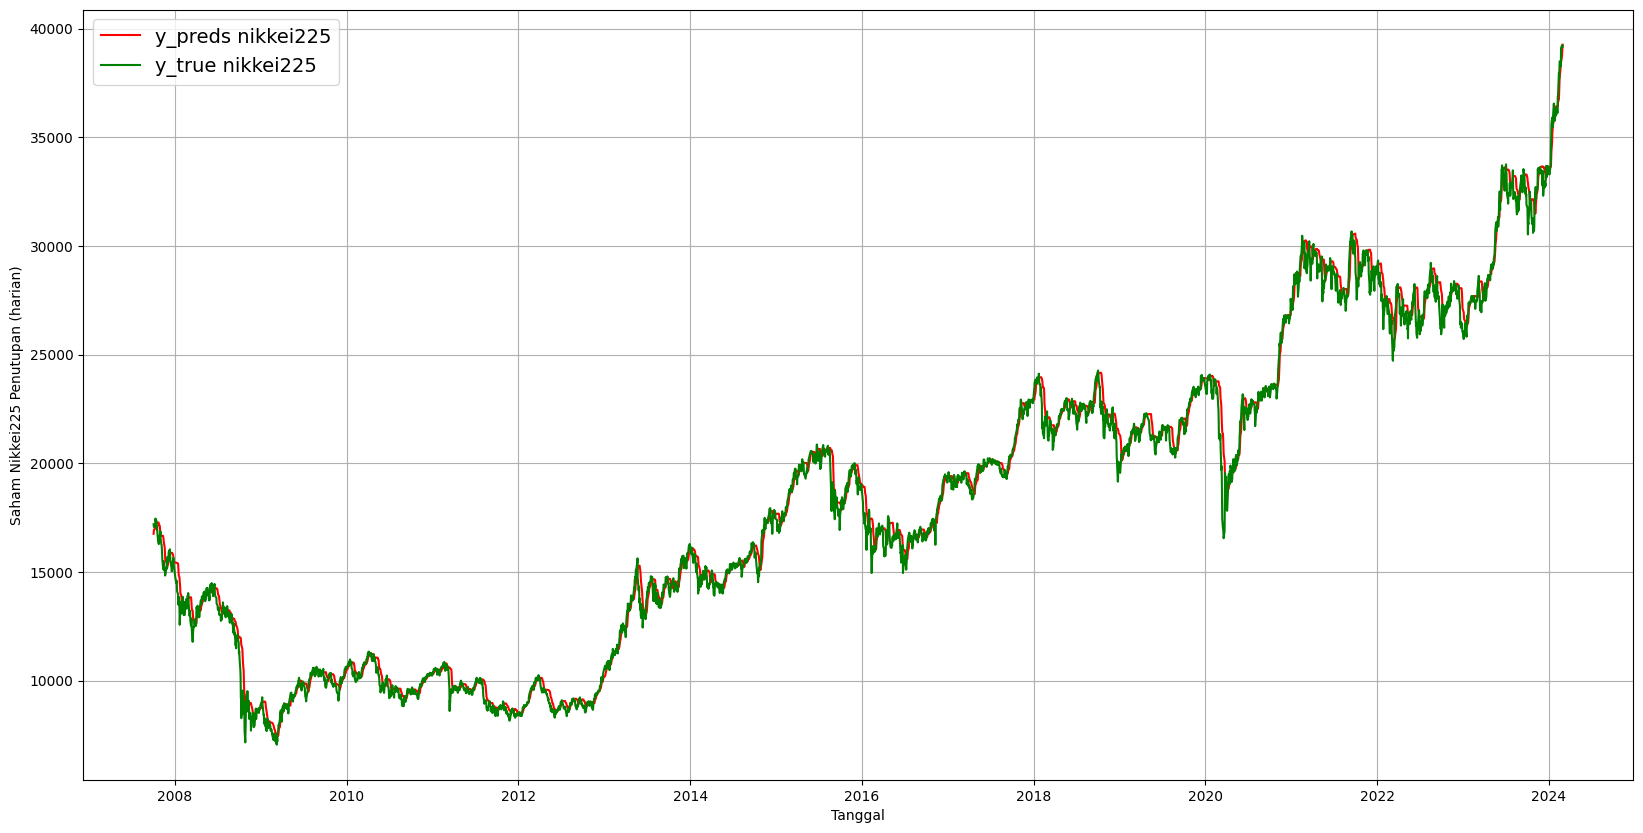

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_1_preds[:,0], format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", label = "y_true nikkei225", color = 'g')


# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_1_plot_prediksi_Conv1D_multi.png')

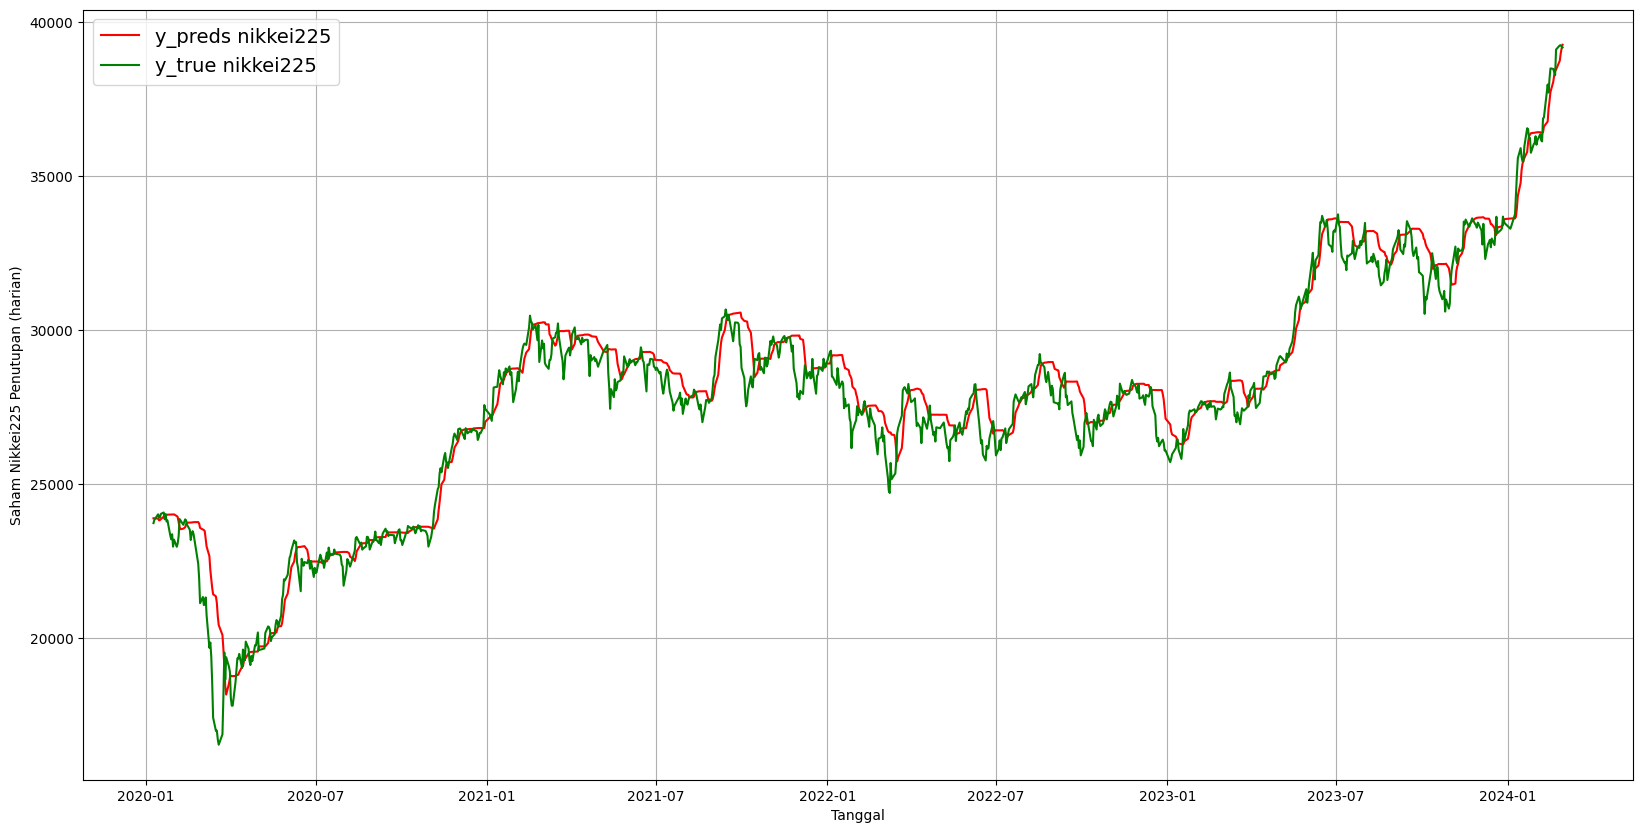

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_1_preds[:,0], format = "-",start = 3000, label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", start = 3000, label = "y_true nikkei225", color = 'g')


# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_1_plot_prediksi_Conv1D_multi_zoomin.png')

simpan model trained ke bentuk .h5

In [ ]:
from tensorflow.keras.models import save_model

# menyimpan model menjadi .h5 file
save_model(model_1, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_1_Conv1D_multivariate.h5")

<ipython-input-103-051b6e5c16b2>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_1, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_1_Conv1D_multivariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_1 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_1_Conv1D_multivariate.h5")

# Model 2 : LSTM

In [ ]:
train_windows.shape[2]

2

## Tuner Builder

In [ ]:
# membuat model LSTM dengan hyperparameter tuning

def model_LSTM_multi_builder(hp):
  tf.random.set_seed(42)

  model_2 = tf.keras.models.Sequential([
          tf.keras.layers.LSTM(units = hp.Int('lstm_n_units', min_value=32, max_value=256, step=32),
                               input_shape=(train_windows.shape[1], train_windows.shape[2]),
                               return_sequences = False,
                               activation = "relu"),

          #tf.keras.layers.Dropout(0.2),
          #tf.keras.layers.LSTM(128, return_sequences=False, activation = "relu"),

          tf.keras.layers.Dense(test_labels.shape[1])
          ], name = "model_2_LSTM_multivariate")



  #compile model 2
  model_2.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_2

In [ ]:
import keras_tuner as kt

tuner_LSTM_multi = kt.Hyperband(model_LSTM_multi_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_tuning_logs',
                     project_name='LSTM_multivariate')

## Proses tuning


In [ ]:
tuner_LSTM_multi.search(train_windows,
                        train_labels,
                        epochs=10,
                        validation_data=(test_windows, test_labels),
                        batch_size = 128)

Trial 30 Complete [00h 00m 43s]
val_loss: 0.004933404270559549

Best val_loss So Far: 0.004580413457006216
Total elapsed time: 00h 07m 19s


## Hasil parameter tuning terbaik

In [ ]:
tuner_Conv1D_multi.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# mengeluarkan hyperparameter optimal
best_hps=tuner_LSTM_multi.get_best_hyperparameters(num_trials=1)[0]

tuning = ['lstm_n_units', 'learning_rate']
print('Best tune model LSTM multivariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model LSTM multivariate:
lstm_n_units: 96
learning_rate: 0.01


## Hasil semua parameter tuning

In [ ]:
tuning =['lstm_n_units', 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hps_all =tuner_LSTM_multi.get_best_hyperparameters(num_trials=30)
for hps in hps_all:
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam = pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_best_hyperparameter_models/hp_LSTM_multi.csv')
df_hyparam


lstm_n_units  learning_rate
0             96         0.0100
1            224         0.0100
2            128         0.0100
3            160         0.0001
4             32         0.0100
5            256         0.0001
6             32         0.0100
7            128         0.0010
8             32         0.0100
9            128         0.0010
10           224         0.0010
11           128         0.0010
12           224         0.0010
13           256         0.0001
14           256         0.0010
15           224         0.0001
16            32         0.0010
17           160         0.0010
18           160         0.0010
19            96         0.0010
20            32         0.0010
21           256         0.0100
22            64         0.0100
23           192         0.0001
24            64         0.0010
25           160         0.0100
26           192         0.0100
27            64         0.0001
28            96         0.0001
29           128         0.0001

In [ ]:
tuner_LSTM_multi.results_summary(num_trials=30)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_tuning_logs/LSTM_multivariate
Showing 30 best trials
Objective(name="val_loss", direction="min")

Trial 0027 summary
Hyperparameters:
lstm_n_units: 96
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.004580413457006216

Trial 0029 summary
Hyperparameters:
lstm_n_units: 224
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.004933404270559549

Trial 0026 summary
Hyperparameters:
lstm_n_units: 128
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.00547737255692482

Trial 0028 summary
Hyperparameters:
lstm_n_units: 160
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.005612867884337902

Trial 0016 summary
Hyperparameters:
lstm_n_units: 32
learning_rate: 0.01
tuner/epochs: 10
tuner/initi

## Mengimplementasikan hyperparameter terbaik ke model

In [ ]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_2 = tuner_LSTM_multi.hypermodel.build(best_hps)

## Melatih model

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_2 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_2_LSTM_multivariate.h5")

In [ ]:

# fit
history = model_2.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_2.name)])

Epoch 1/50
123/126 [============================>.] - ETA: 0s - loss: 0.0355
Epoch 1: val_loss improved from inf to 0.01297, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_2_LSTM_multivariate
126/126 [==============================] - 6s 35ms/step - loss: 0.0350 - val_loss: 0.0130
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.0147
Epoch 2: val_loss did not improve from 0.01297
126/126 [==============================] - 3s 24ms/step - loss: 0.0147 - val_loss: 0.0142
Epoch 3/50
125/126 [============================>.] - ETA: 0s - loss: 0.0137
Epoch 3: val_loss improved from 0.01297 to 0.01122, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_2_LSTM_multivariate
126/126 [==============================] - 4s 30ms/step - loss: 0.0137 - val_loss: 0.0112
Epoch 4/50
125/126 [============================>.] - ETA: 0s - loss: 0.0084
Epoch 4: 

visualisasi model shape

In [ ]:
model_2.summary()

Model: "model_2_LSTM_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 96)                38016     
                                                                 
 dense_1 (Dense)             (None, 2)                 194       
                                                                 
Total params: 38210 (149.26 KB)
Trainable params: 38210 (149.26 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


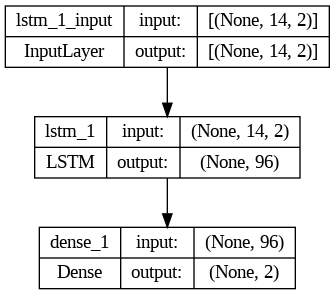

In [ ]:

from tensorflow.keras.utils import plot_model

plot_model(model_2, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_plot/model_LSTM_multi_shape.png', show_shapes=True, show_layer_names=True)


visualisasi loss setiap epoch

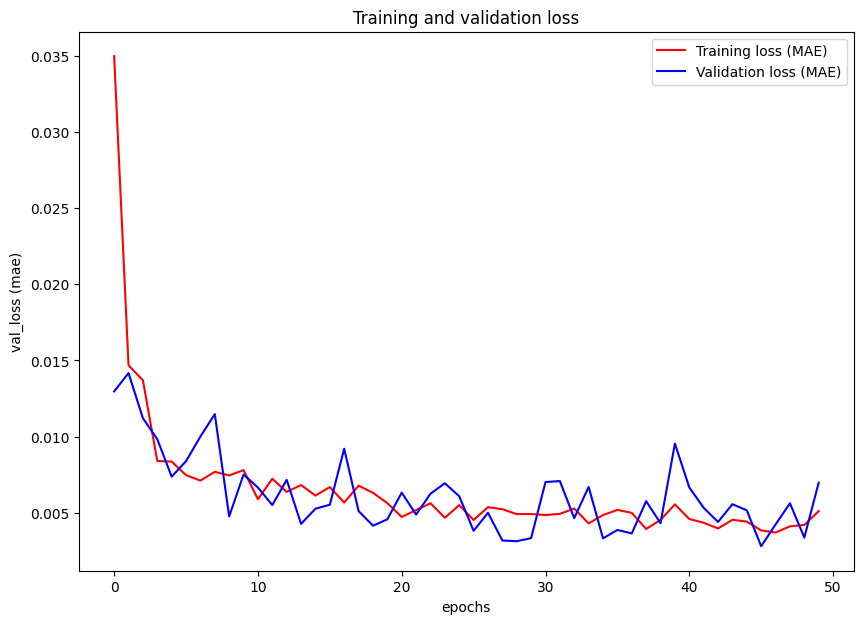

In [ ]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.title ('Training and validation loss')
plt.legend(loc=0)


# simpan visualisasi loss per epoch menjadi image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_visualization/loss_LSTM_multi.png')


# Membuat DataFrame loss dan val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan value loss dan validation loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_value_per_epoch/loss_LSTM_multi.csv', index=False)


In [ ]:
# mengevaluasi model 2 dari epochs terakhir
model_2.evaluate(test_windows, test_labels)

126/126 [==============================] - 1s 4ms/step - loss: 0.0070


0.0069864350371062756

In [ ]:
# mengevaluasi dan load model 2 pada best epoch yang loss mae paling kecil sepanjang training

model_2 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_2_LSTM_multivariate")
model_2.evaluate(test_windows, test_labels)


126/126 [==============================] - 1s 5ms/step - loss: 0.0028


0.002819583285599947

In [ ]:
# membuat predicted value berdasarkan model multivariate model_2 yang sudah di train

model_2_preds = tf.squeeze(model_2.predict(test_windows))
model_2_preds



126/126 [==============================] - 1s 8ms/step


<tf.Tensor: shape=(4013, 2), dtype=float32, numpy=
array([[0.43330565, 0.07453799],
       [0.4371441 , 0.07452266],
       [0.43458536, 0.07419979],
       ...,
       [1.000847  , 0.01665832],
       [1.0040687 , 0.0166484 ],
       [1.0022365 , 0.01636225]], dtype=float32)>

In [ ]:
model_2_preds[:,1]

<tf.Tensor: shape=(4013,), dtype=float32, numpy=
array([0.07453799, 0.07452266, 0.07419979, ..., 0.01665832, 0.0166484 ,
       0.01636225], dtype=float32)>

## Denormalisasi nilai output prediksi dan test_labels

In [ ]:
denormalized_model_2_preds = scaler_multivariate.inverse_transform(model_2_preds)
denormalized_test_labels = scaler_multivariate.inverse_transform(test_labels)

In [ ]:
# mengukur predicted value kedua time series dengan metrik evaluasi regresion problem

model_2_results = evaluate_preds(y_true = denormalized_test_labels,
                                 y_pred = denormalized_model_2_preds)

model_2_results

{'mae': 88.87445,
 'mse': 31648.73,
 'rmse': 125.68053,
 'R-square': 0.992673511068088}

In [ ]:
tf.squeeze(test_labels[:,0])

<tf.Tensor: shape=(4013,), dtype=float64, numpy=
array([0.43710788, 0.43436489, 0.43366381, ..., 1.        , 0.99919575,
       0.99812715])>

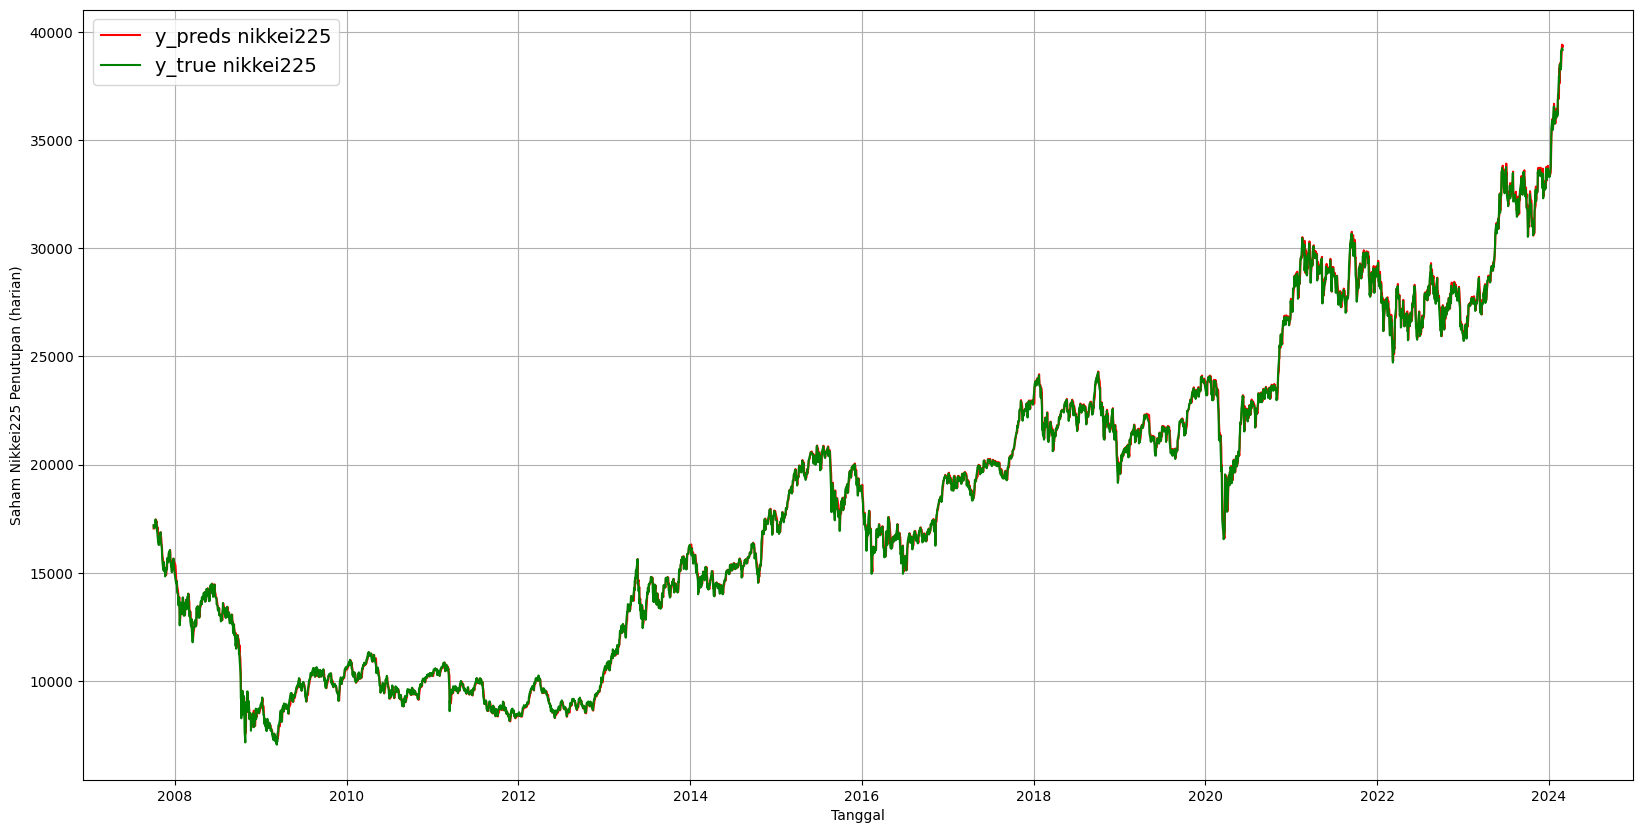

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_2_preds[:,0], format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", label = "y_true nikkei225", color = 'g')


# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_2_plot_prediksi_LSTM_multi.png')

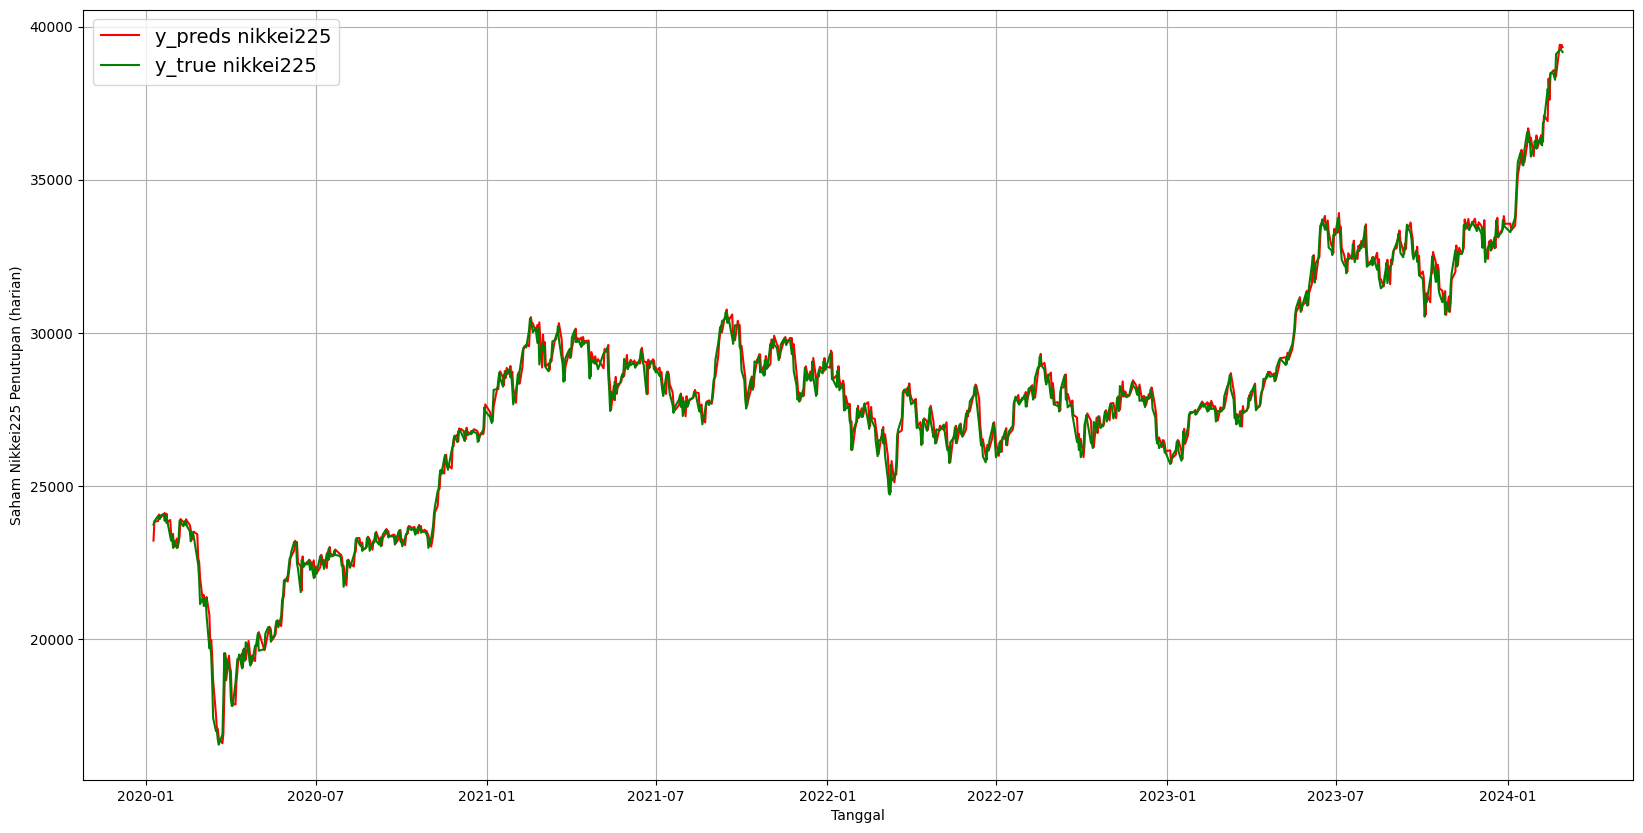

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_2_preds[:,0], format = "-", start = 3000, label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", start = 3000, label = "y_true nikkei225", color = 'g')


# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_2_plot_prediksi_LSTM_multi_zoomin.png')

simpan model trained ke bentuk .h5

In [ ]:
from tensorflow.keras.models import save_model

# menyimpan model menjadi .h5 file
save_model(model_2, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_2_LSTM_multivariate.h5")

<ipython-input-126-26e2a0ee8378>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_2, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_2_LSTM_multivariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_2 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_2_LSTM_multivariate.h5")

# Model 3 : Stacked LSTM

In [ ]:
train_windows.shape[2]

2

## Tuner Builder

In [ ]:
# model stacked LSTM dengan hyperparameter tuning

def model_stacked_LSTM_multi_builder(hp):
  tf.random.set_seed(42)

  model_3 = tf.keras.models.Sequential([
          tf.keras.layers.LSTM(units =  hp.Int('lstm_n_units_1', min_value=32, max_value=256, step=32),
                               input_shape=(train_windows.shape[1], train_windows.shape[2]),
                               return_sequences = True,
                               activation = "relu"),

          #tf.keras.layers.Dropout(0.2, seed=42),
          tf.keras.layers.LSTM(units = hp.Int('lstm_n_units_2', min_value=32, max_value=256, step=32),
                               return_sequences = False,
                               activation = "relu"),

          #tf.keras.layers.LSTM(128, return_sequences=False, activation = "relu"),

          tf.keras.layers.Dense(test_labels.shape[1])
          ], name = "model_3_stackedLSTM_multivariate")



  #compile model 3
  model_3.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_3

In [ ]:
import keras_tuner as kt

tuner_stackedLSTM_multi = kt.Hyperband(model_stacked_LSTM_multi_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_tuning_logs',
                     project_name='stackedLSTM_multivariate')

## Proses tuning


In [ ]:
tuner_stackedLSTM_multi.search(train_windows,
                               train_labels,
                               epochs=10,
                               validation_data=(test_windows, test_labels),
                               batch_size = 128)

Trial 30 Complete [00h 00m 57s]
val_loss: 0.008132493123412132

Best val_loss So Far: 0.00688205286860466
Total elapsed time: 00h 13m 54s


## Hasil parameter tuning terbaik

In [ ]:
# mengeluarkan hyperparameter optimal
best_hps=tuner_stackedLSTM_multi.get_best_hyperparameters(num_trials=1)[0]

tuning = ['lstm_n_units_1', "lstm_n_units_2", 'learning_rate']
print('Best tune model stacked LSTM multivariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model stacked LSTM multivariate:
lstm_n_units_1: 128
lstm_n_units_2: 160
learning_rate: 0.01


## Hasil semua parameter tuning

In [ ]:
tuning = ['lstm_n_units_1', "lstm_n_units_2", 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hps_all=tuner_stackedLSTM_multi.get_best_hyperparameters(num_trials=30)
for hps in hps_all:
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam = pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_best_hyperparameter_models/hp_Stacked_LSTM_multi.csv')
df_hyparam




lstm_n_units_1  lstm_n_units_2  learning_rate
0              128             160         0.0100
1              160             128         0.0001
2              128             256         0.0001
3              224              32         0.0001
4              160             224         0.0010
5               64              32         0.0100
6              224             128         0.0010
7              160             128         0.0001
8              224             128         0.0010
9              160             224         0.0010
10              96             160         0.0100
11             128             160         0.0100
12             224             224         0.0001
13              96             160         0.0010
14             160             224         0.0010
15             160              64         0.0100
16             224             160         0.0100
17             128              64         0.0100
18             160             128         0.0001
19              96             160         0.0010
20              96             160         0.0100
21             224             192         0.0100
22              32              64         0.0010
23             128             256         0.0010
24             128             160         0.0001
25              32             224         0.0100
26              32             160         0.0100
27              64             160         0.0001
28             256             192         0.0100
29              64             128         0.0001

In [ ]:
tuner_stackedLSTM_multi.results_summary(num_trials=30)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_tuning_logs/stackedLSTM_multivariate
Showing 30 best trials
Objective(name="val_loss", direction="min")

Trial 0025 summary
Hyperparameters:
lstm_n_units_1: 128
lstm_n_units_2: 160
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.00688205286860466

Trial 0016 summary
Hyperparameters:
lstm_n_units_1: 160
lstm_n_units_2: 128
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.006998163647949696

Trial 0026 summary
Hyperparameters:
lstm_n_units_1: 128
lstm_n_units_2: 256
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.007048094179481268

Trial 0028 summary
Hyperparameters:
lstm_n_units_1: 224
lstm_n_units_2: 32
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tune

## Mengimplementasikan hyperparameter terbaik ke model

In [ ]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_3 = tuner_stackedLSTM_multi.hypermodel.build(best_hps)

## Melatih model

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_3 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_3_stackedLSTM_multivariate.h5")



In [ ]:

# fit
history = model_3.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_3.name)])

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.0634
Epoch 1: val_loss improved from inf to 0.03790, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_3_stackedLSTM_multivariate
126/126 [==============================] - 11s 68ms/step - loss: 0.0634 - val_loss: 0.0379
Epoch 2/50
125/126 [============================>.] - ETA: 0s - loss: 0.0186
Epoch 2: val_loss improved from 0.03790 to 0.01859, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_3_stackedLSTM_multivariate
126/126 [==============================] - 7s 59ms/step - loss: 0.0186 - val_loss: 0.0186
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 0.0173
Epoch 3: val_loss improved from 0.01859 to 0.01110, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_3_stackedLSTM_multivariate
126/126 [=======

visualisasi model shape

In [ ]:
model_3.summary()

Model: "model_3_stackedLSTM_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_12 (LSTM)              (None, 14, 128)           67072     
                                                                 
 lstm_13 (LSTM)              (None, 160)               184960    
                                                                 
 dense_6 (Dense)             (None, 2)                 322       
                                                                 
Total params: 252354 (985.76 KB)
Trainable params: 252354 (985.76 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


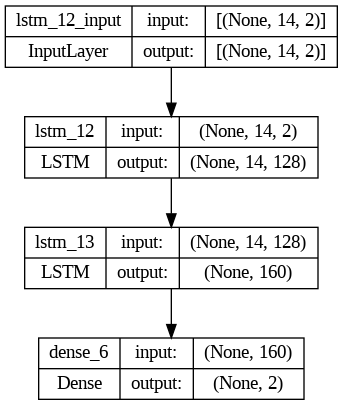

In [ ]:

from tensorflow.keras.utils import plot_model

plot_model(model_3, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_plot/model_stackedLSTM_multi_shape.png', show_shapes=True, show_layer_names=True)



visualisasi loss setiap epoch

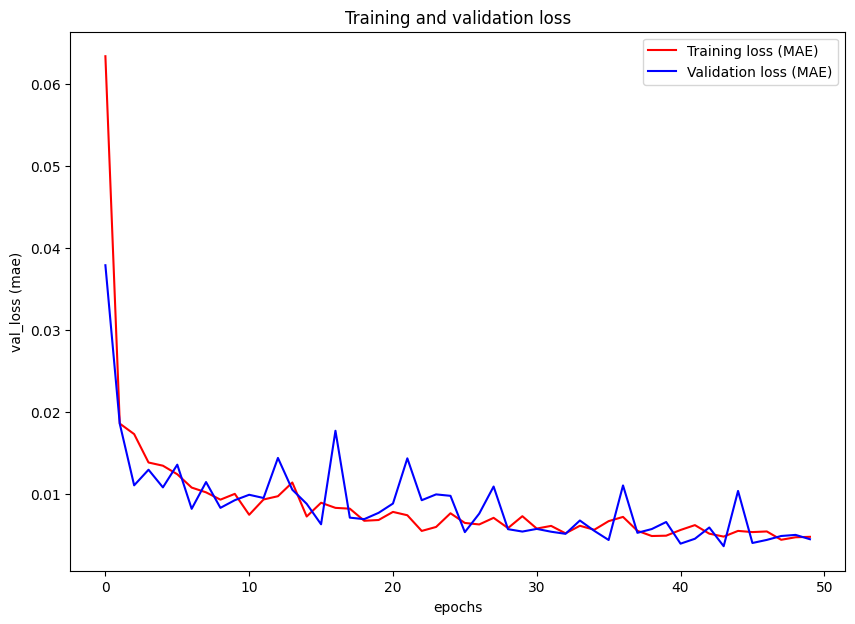

In [ ]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.title ('Training and validation loss')
plt.legend(loc=0)


# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_visualization/loss_stackedLSTM_multi.png')



# Membuat DataFrame loss dan val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan value loss dan validation loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_value_per_epoch/loss_stackedLSTM_multi.csv', index=False)


In [ ]:
# mengevaluasi model 3 dari epochs terakhir
model_3.evaluate(test_windows, test_labels)

126/126 [==============================] - 1s 6ms/step - loss: 0.0045


0.004537556320428848

In [ ]:
# mengevaluasi dan load model 3 pada best epoch yang loss mae paling kecil sepanjang training

model_3 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_3_stackedLSTM_multivariate")
model_3.evaluate(test_windows, test_labels)


126/126 [==============================] - 1s 7ms/step - loss: 0.0037


0.0036850122269243

In [ ]:
# membuat predicted value berdasarkan model multivariate model_3 yang sudah di train

model_3_preds = tf.squeeze(model_3.predict(test_windows))
model_3_preds



126/126 [==============================] - 3s 18ms/step


<tf.Tensor: shape=(4013, 2), dtype=float32, numpy=
array([[0.43182746, 0.07173617],
       [0.4358765 , 0.07192656],
       [0.43351167, 0.07205039],
       ...,
       [0.9977014 , 0.0166176 ],
       [0.99972665, 0.01468986],
       [0.99531233, 0.01548088]], dtype=float32)>

## Denormalisasi nilai output prediksi dan test_labels

In [ ]:
denormalized_model_3_preds = scaler_multivariate.inverse_transform(model_3_preds)
denormalized_test_labels = scaler_multivariate.inverse_transform(test_labels)

In [ ]:
# mengukur predicted value kedua time series dengan metrik evaluasi regresion problem

model_3_results = evaluate_preds(y_true = denormalized_test_labels,
                                 y_pred = denormalized_model_3_preds)

model_3_results

{'mae': 102.29272,
 'mse': 40311.586,
 'rmse': 144.65027,
 'R-square': 0.9733942137826019}

In [ ]:
tf.squeeze(test_labels[:,0])

<tf.Tensor: shape=(4013,), dtype=float64, numpy=
array([0.43710788, 0.43436489, 0.43366381, ..., 1.        , 0.99919575,
       0.99812715])>

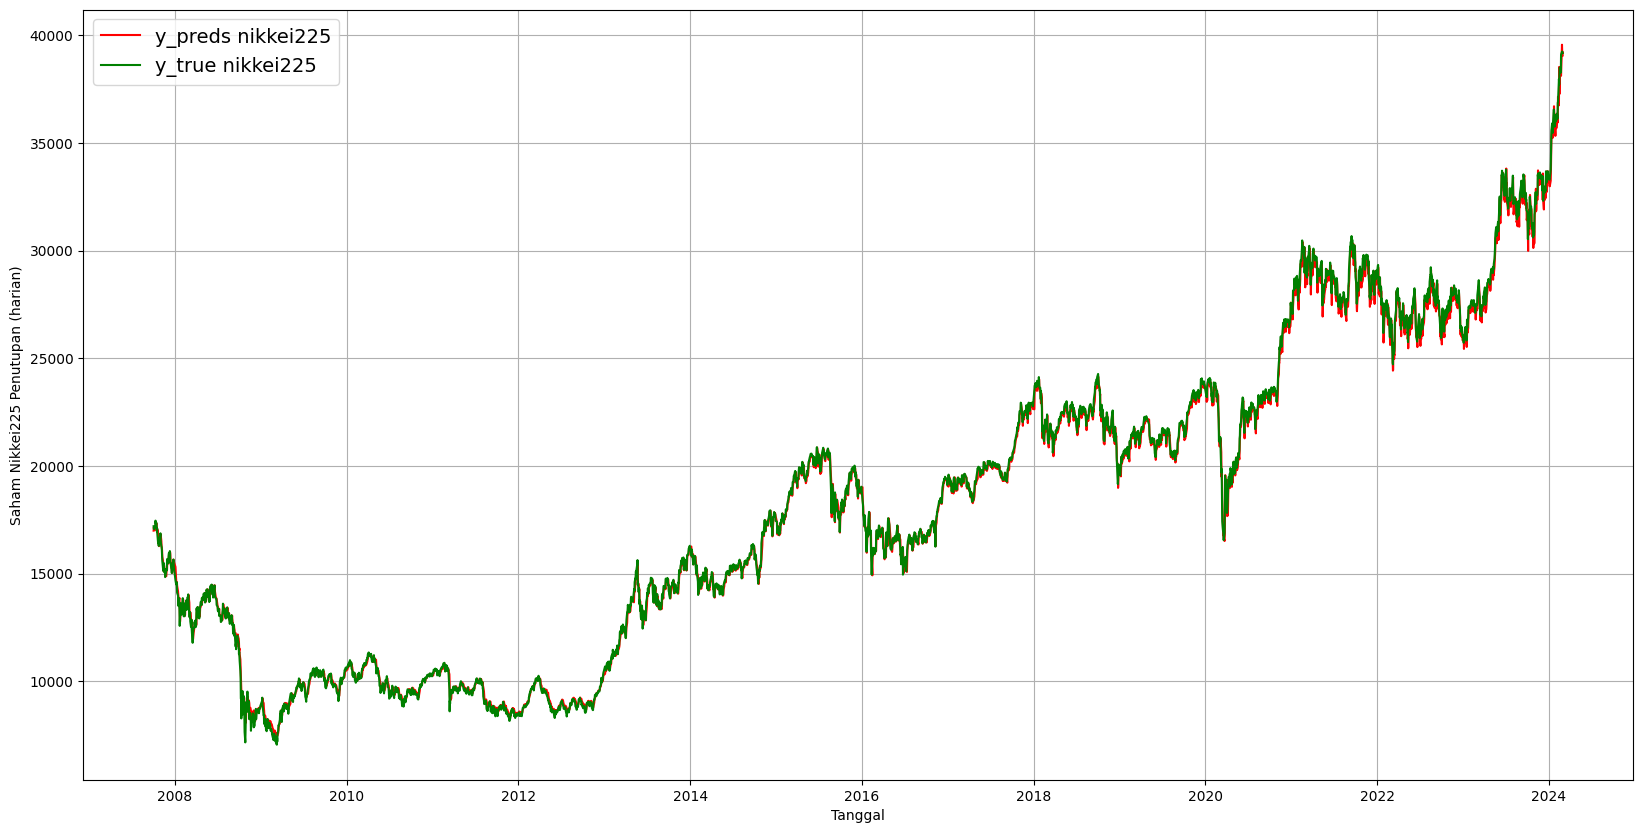

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_3_preds[:,0], format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_3_plot_prediksi_stackedLSTM_multi.png')



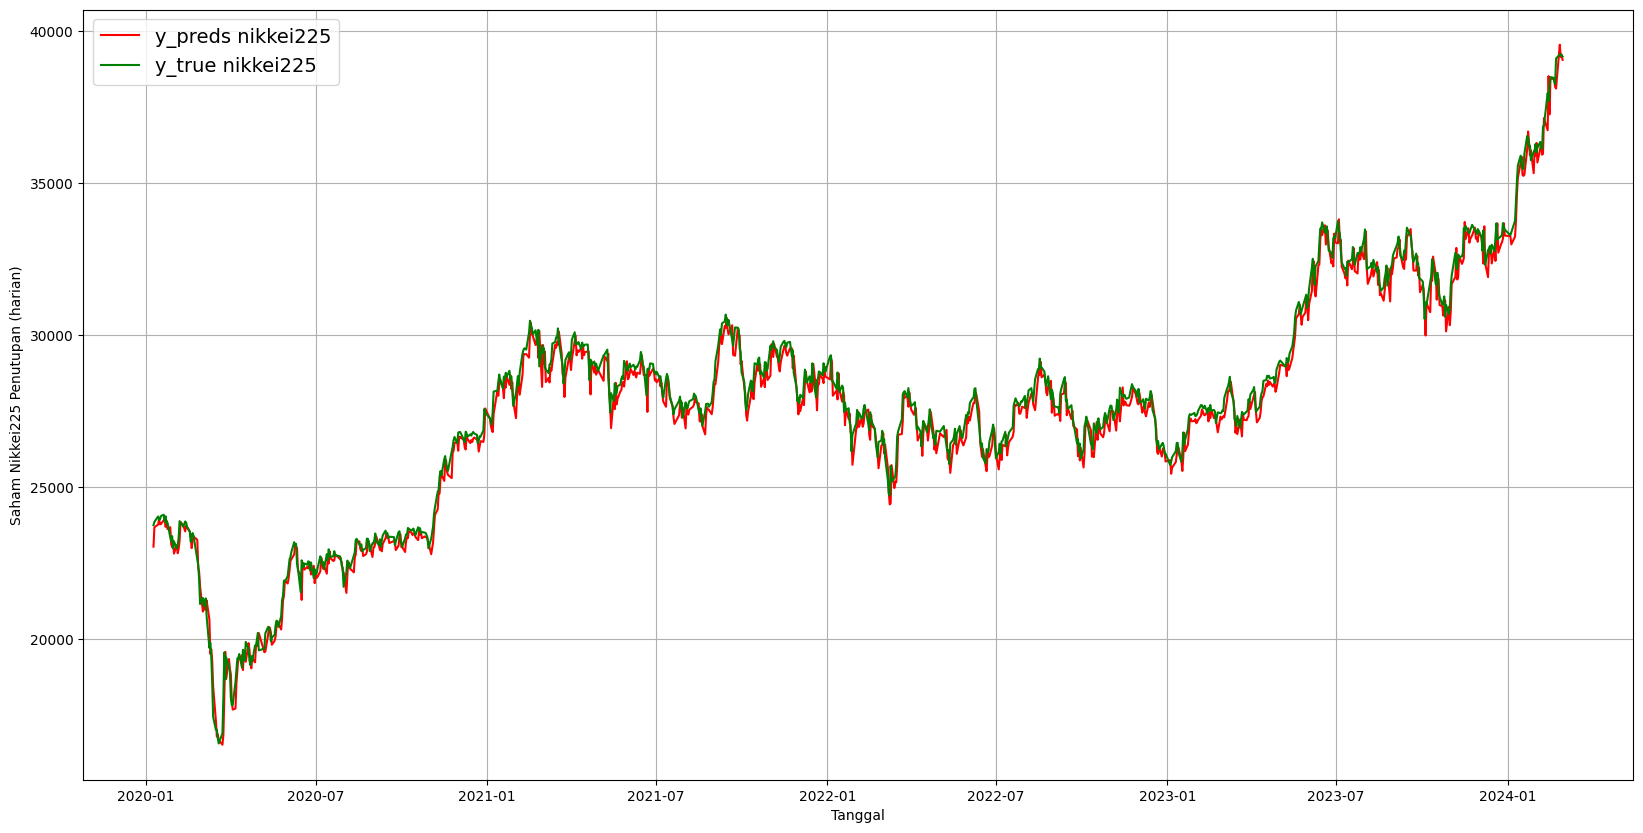

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_3_preds[:,0], format = "-", start = 3000, label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", start = 3000, label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_3_plot_prediksi_stackedLSTM_multi_zoomin.png')



simpan model trained ke bentuk .h5

In [ ]:
from tensorflow.keras.models import save_model


# Save the model to disk as a .h5 file
save_model(model_3, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_3_stackedLSTM_multivariate.h5")

<ipython-input-155-838bad857e06>:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_3, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_3_stackedLSTM_multivariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_3 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_3_stackedLSTM_multivariate.h5")



# Model 4 : Bidirectional LSTM

In [ ]:
train_windows.shape[2]

2

## Tuner Builder

In [ ]:
def model_bidirectional_LSTM_multi_builder(hp):
  tf.random.set_seed(42)

  model_4 = tf.keras.models.Sequential([
          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = hp.Int('bi_lstm_n_units', min_value=32, max_value=256, step=32),
                                                            input_shape=(train_windows.shape[1], train_windows.shape[2]),
                                                            return_sequences = False,
                                                            activation = "relu")),
          #tf.keras.layers.Dropout(0.2, seed=42),
          #tf.keras.layers.LSTM(128, return_sequences = False, activation = "relu"),

          #tf.keras.layers.LSTM(128, return_sequences=False, activation = "relu"),

          tf.keras.layers.Dense(test_labels.shape[1])
          ], name = "model_4_bidirectionalLSTM_multivariate")



  #compile model 4
  model_4.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_4

In [ ]:
import keras_tuner as kt

tuner_bi_LSTM_multi = kt.Hyperband(model_bidirectional_LSTM_multi_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_tuning_logs',
                     project_name='bi_LSTM_multivariate')

## Proses tuning


In [ ]:
tuner_bi_LSTM_multi.search(train_windows,
                           train_labels,
                           epochs=10,
                           validation_data=(test_windows, test_labels),
                           batch_size = 128)

Trial 30 Complete [00h 00m 46s]
val_loss: 0.0073508708737790585

Best val_loss So Far: 0.0051604085601866245
Total elapsed time: 00h 37m 17s


## Hasil parameter tuning terbaik

In [ ]:
tuner_bi_LSTM_multi.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# mengeluarkan hyperparameter optimal
best_hps=tuner_bi_LSTM_multi.get_best_hyperparameters(num_trials=1)[0]

tuning = ["bi_lstm_n_units", 'learning_rate']
print('Best tune model bidirectional LSTM multivariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model bidirectional LSTM multivariate:
bi_lstm_n_units: 128
learning_rate: 0.01


## Hasil semua parameter tuning

In [ ]:
tuning = ["bi_lstm_n_units", 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hps_all=tuner_bi_LSTM_multi.get_best_hyperparameters(num_trials=30)
for hps in hps_all:
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam = pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_best_hyperparameter_models/hp_bi_LSTM_multi.csv')

df_hyparam


bi_lstm_n_units  learning_rate
0               128         0.0100
1               192         0.0100
2               256         0.0100
3               256         0.0001
4               192         0.0010
5               128         0.0010
6               256         0.0001
7               128         0.0010
8                32         0.0010
9               256         0.0100
10              128         0.0100
11               64         0.0010
12               96         0.0010
13              192         0.0001
14              256         0.0100
15              224         0.0001
16              256         0.0001
17              256         0.0010
18              224         0.0100
19              256         0.0010
20               64         0.0100
21              160         0.0010
22              224         0.0010
23              160         0.0100
24              128         0.0001
25               32         0.0100
26               96         0.0100
27              224         0.0100
28               32         0.0001
29               96         0.0001

In [ ]:
tuner_bi_LSTM_multi.results_summary(num_trials=30)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_tuning_logs/bi_LSTM_multivariate
Showing 30 best trials
Objective(name="val_loss", direction="min")

Trial 0025 summary
Hyperparameters:
bi_lstm_n_units: 128
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0019
Score: 0.0051604085601866245

Trial 0026 summary
Hyperparameters:
bi_lstm_n_units: 192
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.0052571832202374935

Trial 0017 summary
Hyperparameters:
bi_lstm_n_units: 256
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.005603088065981865

Trial 0016 summary
Hyperparameters:
bi_lstm_n_units: 256
learning_rate: 0.0001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0013
Score: 0.0057692453265190125

Trial 0028 summary

## Mengimplementasikan hyperparameter terbaik ke model

In [ ]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_4 = tuner_bi_LSTM_multi.hypermodel.build(best_hps)

## Melatih model

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_4 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_4_bidirectionalLSTM_multivariate.h5")

In [ ]:

# fit
history = model_4.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_4.name)])

Epoch 1/50
125/126 [============================>.] - ETA: 0s - loss: 0.0348
Epoch 1: val_loss improved from inf to 0.01491, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_4_bidirectionalLSTM_multivariate
126/126 [==============================] - 22s 140ms/step - loss: 0.0348 - val_loss: 0.0149
Epoch 2/50
125/126 [============================>.] - ETA: 0s - loss: 0.0127
Epoch 2: val_loss improved from 0.01491 to 0.01045, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_4_bidirectionalLSTM_multivariate
126/126 [==============================] - 17s 134ms/step - loss: 0.0127 - val_loss: 0.0105
Epoch 3/50
125/126 [============================>.] - ETA: 0s - loss: 0.0129
Epoch 3: val_loss did not improve from 0.01045
126/126 [==============================] - 12s 93ms/step - loss: 0.0129 - val_loss: 0.0106
Epoch 4/50
125/126 [============================>.] - E

visualisasi model shape

In [ ]:
model_4.summary()

Model: "model_4_bidirectionalLSTM_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 bidirectional_2 (Bidirecti  (None, 256)               134144    
 onal)                                                           
                                                                 
 dense_2 (Dense)             (None, 2)                 514       
                                                                 
Total params: 134658 (526.01 KB)
Trainable params: 134658 (526.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


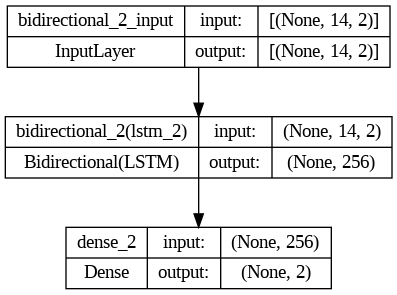

In [ ]:

from tensorflow.keras.utils import plot_model

plot_model(model_4, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_plot/model_biLSTM_multi_shape.png', show_shapes=True, show_layer_names=True)


visualisasi loss setiap epoch

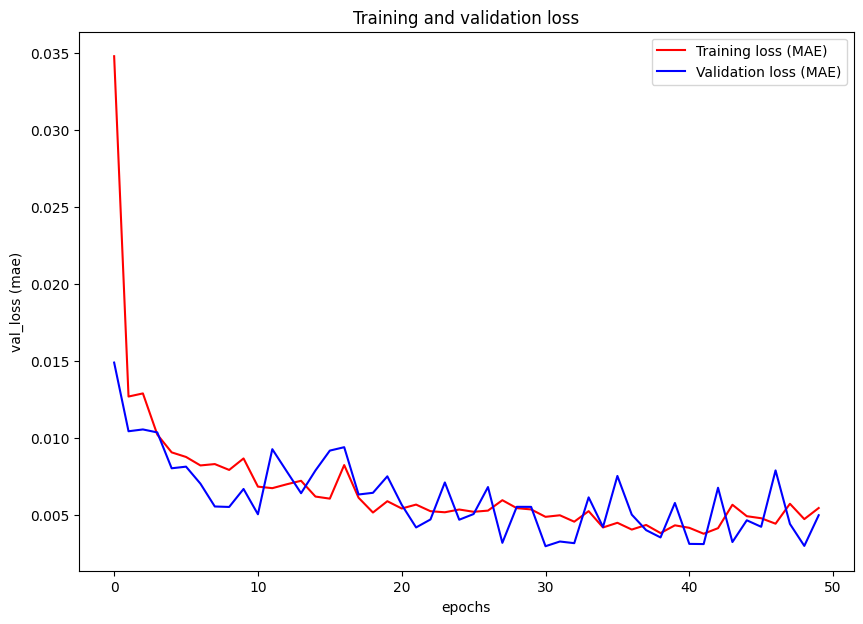

In [ ]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.title ('Training and validation loss')
plt.legend(loc=0)


# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_visualization/loss_bidirectional_LSTM_multi.png')


# Membuat DataFrame loss dan val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan value loss dan validation loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_value_per_epoch/loss_bidirectional_LSTM_multi.csv', index=False)


In [ ]:
# mengevaluasi model 4 dari epochs terakhir
model_4.evaluate(test_windows, test_labels)

126/126 [==============================] - 2s 13ms/step - loss: 0.0050


0.005007732659578323

In [ ]:
# mengevaluasi dan load model 4 pada best epoch yang loss mae paling kecil sepanjang training

model_4 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_4_bidirectionalLSTM_multivariate")
model_4.evaluate(test_windows, test_labels)


126/126 [==============================] - 2s 14ms/step - loss: 0.0030


0.002997106406837702

In [ ]:
# membuat predicted value berdasarkan model multivariate model_4 yang sudah di train

model_4_preds = tf.squeeze(model_4.predict(test_windows))
model_4_preds



126/126 [==============================] - 2s 13ms/step


<tf.Tensor: shape=(4013, 2), dtype=float32, numpy=
array([[0.43256333, 0.07099418],
       [0.43633655, 0.07086393],
       [0.43360093, 0.07022889],
       ...,
       [1.003475  , 0.02219312],
       [1.0066402 , 0.02190177],
       [1.0044001 , 0.02141884]], dtype=float32)>

In [ ]:
model_4_preds[:,0]

<tf.Tensor: shape=(4013,), dtype=float32, numpy=
array([0.43256333, 0.43633655, 0.43360093, ..., 1.003475  , 1.0066402 ,
       1.0044001 ], dtype=float32)>

## Denormalisasi nilai output prediksi dan test_labels

In [ ]:
denormalized_model_4_preds = scaler_multivariate.inverse_transform(model_4_preds)
denormalized_test_labels = scaler_multivariate.inverse_transform(test_labels)

In [ ]:
# mengukur predicted value kedua time series dengan metrik evaluasi regresion problem

model_4_results = evaluate_preds(y_true = denormalized_test_labels,
                                 y_pred = denormalized_model_4_preds)

model_4_results

{'mae': 97.12662,
 'mse': 36671.066,
 'rmse': 137.3513,
 'R-square': 0.9897775974204797}

In [ ]:
tf.squeeze(test_labels[:,0])

<tf.Tensor: shape=(4013,), dtype=float64, numpy=
array([0.43710788, 0.43436489, 0.43366381, ..., 1.        , 0.99919575,
       0.99812715])>

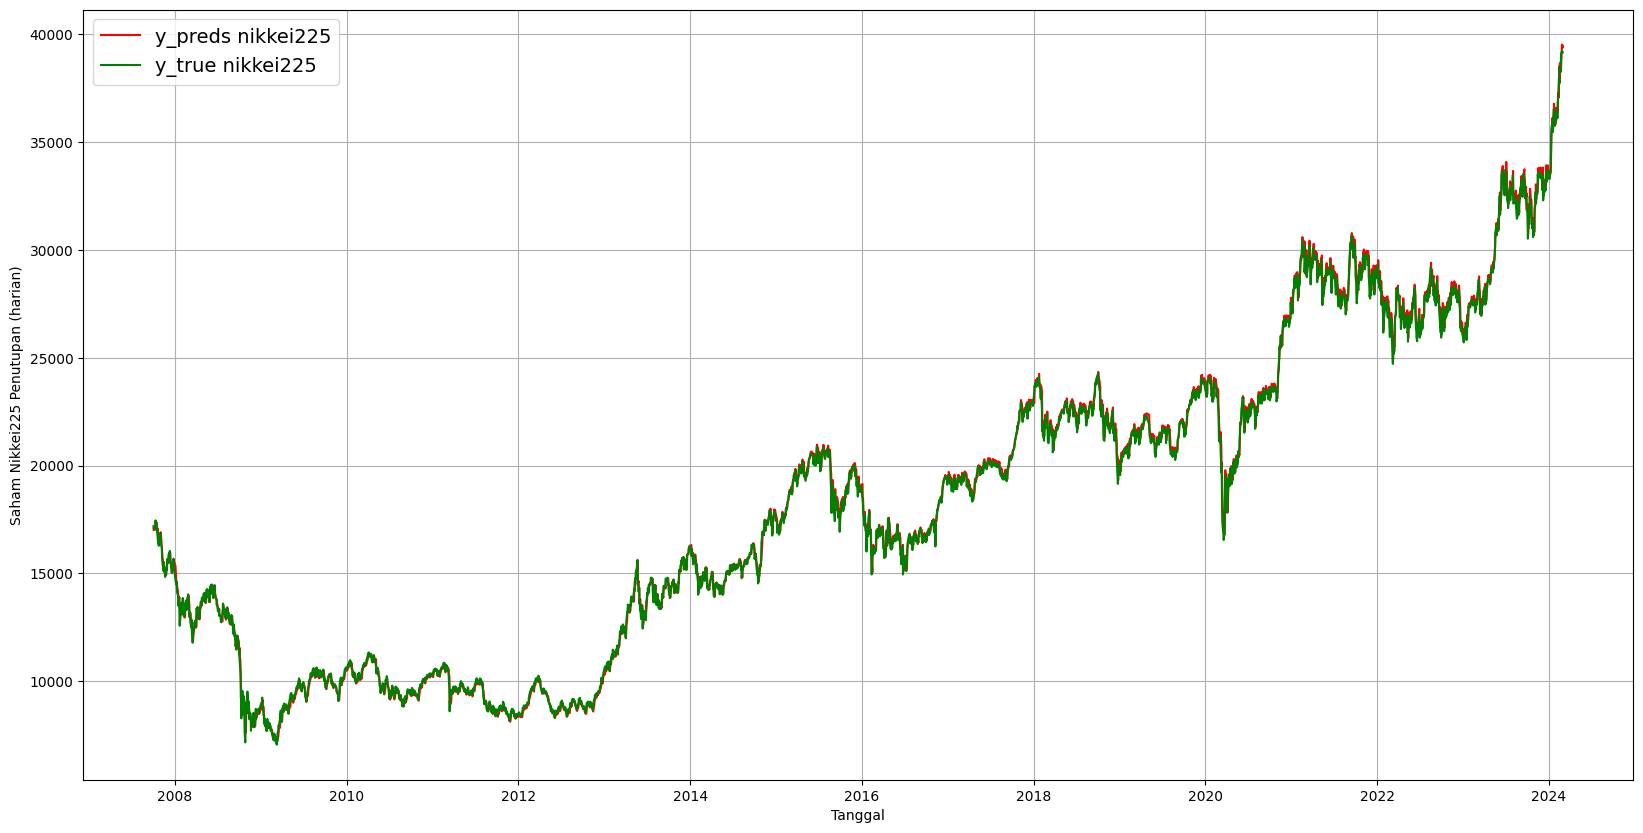

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_4_preds[:,0], format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_4_plot_prediksi_biLSTM_multi.png')


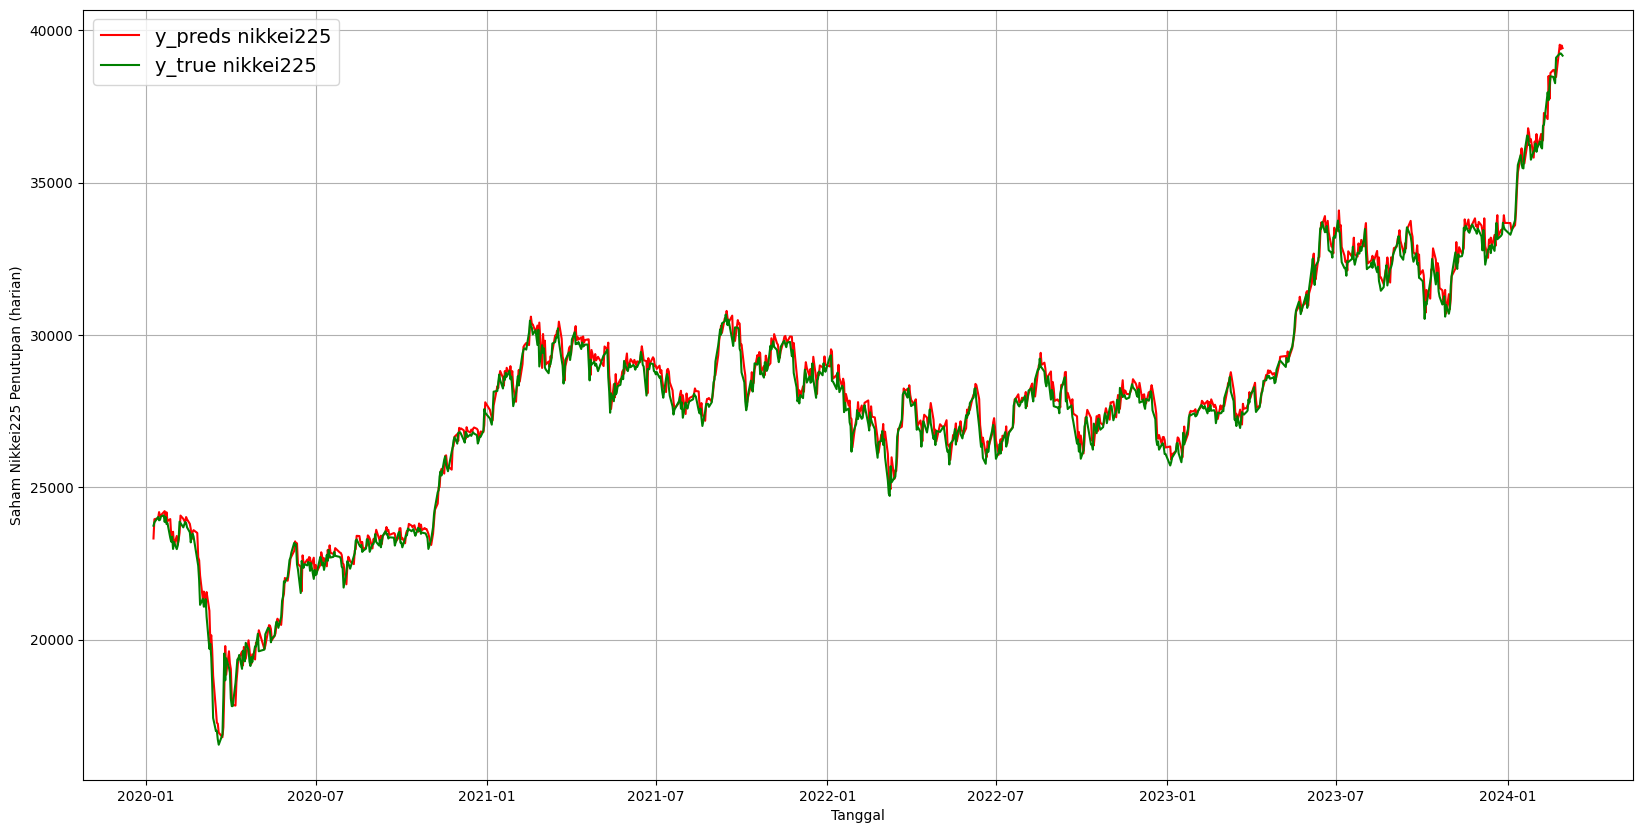

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_4_preds[:,0], format = "-", start = 3000, label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", start = 3000, label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_4_plot_prediksi_biLSTM_multi_zoomin.png')


simpan model trained ke bentuk .h5

In [ ]:
from tensorflow.keras.models import save_model


# Save the model to disk as a .h5 file
save_model(model_4, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_4_bidirectionalLSTM_multivariate.h5")

<ipython-input-127-656e3d851aa0>:5: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_4, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_4_bidirectionalLSTM_multivariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_4 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_4_bidirectionalLSTM_multivariate.h5")

# Model 5 : CNN-LSTM

## Tuner Builder

In [ ]:
def model_CNN_LSTM_multi_builder(hp):
  tf.random.set_seed(42)

  model_5 = tf.keras.models.Sequential([
    # YOUR CODE HERE.
    tf.keras.layers.Conv1D(filters=hp.Int('Conv1D_n_filters', min_value=32, max_value=256, step=32),
                          kernel_size=hp.Int('Conv1D_kernel_size', min_value=5, max_value=10, step=1),
                          strides=1,
                          padding="causal",
                          activation="relu",
                          input_shape=[train_windows.shape[1], train_windows.shape[2]]),

    tf.keras.layers.LSTM(units = hp.Int('LSTM_n_units', min_value=32, max_value=256, step=32),
                        return_sequences=False),

    tf.keras.layers.Dense(test_labels.shape[1]),
    ], name = "model_5_CNN-LSTM_multivariate")


  #compile model 5
  model_5.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_5

In [ ]:
import keras_tuner as kt

tuner_CNN_LSTM_multi = kt.Hyperband(model_CNN_LSTM_multi_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_tuning_logs',
                     project_name='CNN_LSTM_multivariate')

## Proses tuning


In [ ]:
tuner_CNN_LSTM_multi.search(train_windows,
                            train_labels,
                            epochs=10,
                            validation_data=(test_windows, test_labels),
                            batch_size = 128)

Trial 30 Complete [00h 04m 27s]
val_loss: 0.005216566845774651

Best val_loss So Far: 0.005177085287868977
Total elapsed time: 00h 31m 06s


## Hasil parameter tuning terbaik

In [ ]:
# mengeluarkan hyperparameter optimal
best_hps=tuner_CNN_LSTM_multi.get_best_hyperparameters(num_trials=1)[0]

tuning = ['Conv1D_n_filters', 'Conv1D_kernel_size', "LSTM_n_units", 'learning_rate']
print('Best tune model CNN LSTM multivariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model CNN LSTM multivariate:
Conv1D_n_filters: 256
Conv1D_kernel_size: 8
LSTM_n_units: 192
learning_rate: 0.001


## Hasil semua parameter tuning

In [ ]:
tuning = ['Conv1D_n_filters', 'Conv1D_kernel_size', "LSTM_n_units", 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hps_all=tuner_CNN_LSTM_multi.get_best_hyperparameters(num_trials=30)
for hps in hps_all:
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam= pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_best_hyperparameter_models/hp_CNN_LSTM_multi.csv')
df_hyparam


Conv1D_n_filters  Conv1D_kernel_size  LSTM_n_units  learning_rate
0                256                   8           192         0.0010
1                256                   8           224         0.0010
2                 96                   5            96         0.0010
3                224                   8           192         0.0010
4                256                  10           192         0.0001
5                 64                   5           192         0.0001
6                192                   8            96         0.0001
7                 32                   7            32         0.0010
8                 32                   7            32         0.0010
9                256                  10           192         0.0001
10               256                  10           192         0.0001
11                32                   7            32         0.0010
12                64                   5           192         0.0001
13                96                   5            96         0.0010
14               192                   8            96         0.0001
15                64                   6           192         0.0100
16               224                   9            32         0.0010
17               224                   8            64         0.0001
18               224                   8            64         0.0001
19               128                   9           256         0.0001
20               192                   9           192         0.0010
21                32                   7           128         0.0010
22               160                   8           192         0.0010
23                96                   5            32         0.0010
24               256                   9           128         0.0010
25                32                   7           256         0.0100
26                32                   9           128         0.0100
27                64                   6            64         0.0100
28                32                   8            32         0.0100
29               224                   9            96         0.0100

In [ ]:
tuner_CNN_LSTM_multi.results_summary(num_trials=30)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_tuning_logs/CNN_LSTM_multivariate
Showing 30 best trials
Objective(name="val_loss", direction="min")

Trial 0027 summary
Hyperparameters:
Conv1D_n_filters: 256
Conv1D_kernel_size: 8
LSTM_n_units: 192
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.005177085287868977

Trial 0029 summary
Hyperparameters:
Conv1D_n_filters: 256
Conv1D_kernel_size: 8
LSTM_n_units: 224
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.005216566845774651

Trial 0011 summary
Hyperparameters:
Conv1D_n_filters: 96
Conv1D_kernel_size: 5
LSTM_n_units: 96
learning_rate: 0.001
tuner/epochs: 2
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.0055854846723377705

Trial 0026 summary
Hyperparameters:
Conv1D_n_filters: 224
Conv1D_kernel_size: 8
LSTM_n_units: 192
learning_rate: 0.001
tuner/epochs: 10
tun

## Mengimplementasikan hyperparameter terbaik ke model

In [ ]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_5 = tuner_CNN_LSTM_multi.hypermodel.build(best_hps)

## Melatih model

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_5 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_5_CNN-LSTM_multivariate.h5")


In [ ]:

# fit
history = model_5.fit(train_windows,
            train_labels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_windows, test_labels),
            callbacks = [create_model_checkpoint(model_name = model_5.name)])

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.0258
Epoch 1: val_loss improved from inf to 0.00751, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_5_CNN-LSTM_multivariate
126/126 [==============================] - 26s 189ms/step - loss: 0.0258 - val_loss: 0.0075
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.0125
Epoch 2: val_loss did not improve from 0.00751
126/126 [==============================] - 17s 137ms/step - loss: 0.0125 - val_loss: 0.0096
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 0.0106
Epoch 3: val_loss did not improve from 0.00751
126/126 [==============================] - 17s 134ms/step - loss: 0.0106 - val_loss: 0.0098
Epoch 4/50
126/126 [==============================] - ETA: 0s - loss: 0.0091
Epoch 4: val_loss improved from 0.00751 to 0.00661, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/

visualisasi model shape

In [ ]:
model_5.summary()

Model: "model_5_CNN-LSTM_multivariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 14, 256)           4352      
                                                                 
 lstm_1 (LSTM)               (None, 192)               344832    
                                                                 
 dense_1 (Dense)             (None, 2)                 386       
                                                                 
Total params: 349570 (1.33 MB)
Trainable params: 349570 (1.33 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


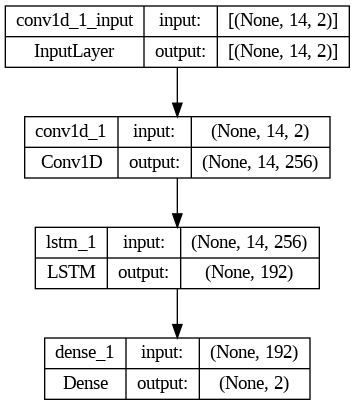

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_5, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_plot/model_CNN-LSTM_multi_shape.png', show_shapes=True, show_layer_names=True)


visualisasi loss setiap epoch

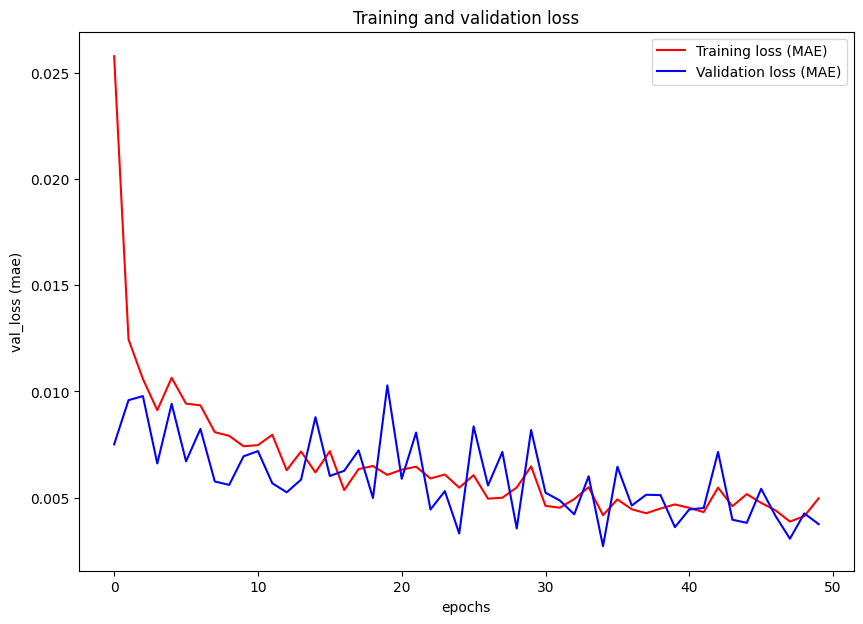

In [ ]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.title ('Training and validation loss')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.legend(loc=0)



# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_visualization/loss_CNN-LSTM_multi.png')



# Membuat DataFrame loss dan val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan value loss dan validation loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_value_per_epoch/loss_CNN-LSTM_multi.csv', index=False)


In [ ]:
# mengevaluasi model 5 dari epochs terakhir
model_5.evaluate(test_windows, test_labels)

126/126 [==============================] - 2s 17ms/step - loss: 0.0037


0.0037473789416253567

In [ ]:
# mengevaluasi dan load model 5 pada best epoch yang loss mae paling kecil sepanjang training

model_5 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_5_CNN-LSTM_multivariate")
model_5.evaluate(test_windows, test_labels)


126/126 [==============================] - 3s 17ms/step - loss: 0.0027


0.0027093307580798864

In [ ]:
# membuat predicted value berdasarkan model multivariate model_1 yang sudah di train

model_5_preds = tf.squeeze(model_5.predict(test_windows))
model_5_preds



126/126 [==============================] - 3s 17ms/step


<tf.Tensor: shape=(4013, 2), dtype=float32, numpy=
array([[0.43106106, 0.07404264],
       [0.43479276, 0.07401579],
       [0.4333097 , 0.07382303],
       ...,
       [1.0053672 , 0.0227666 ],
       [1.0064481 , 0.02353511],
       [1.0066748 , 0.02424197]], dtype=float32)>

In [ ]:
model_5_preds[:,0]

<tf.Tensor: shape=(4013,), dtype=float32, numpy=
array([0.43106106, 0.43479276, 0.4333097 , ..., 1.0053672 , 1.0064481 ,
       1.0066748 ], dtype=float32)>

## Denormalisasi nilai output prediksi dan test_labels

In [ ]:
denormalized_model_5_preds = scaler_multivariate.inverse_transform(model_5_preds)
denormalized_test_labels = scaler_multivariate.inverse_transform(test_labels)

In [ ]:
# mengukur predicted value kedua time series dengan metrik evaluasi regresion problem

model_5_results = evaluate_preds(y_true = denormalized_test_labels,
                                 y_pred = denormalized_model_5_preds)

model_5_results

{'mae': 92.810715,
 'mse': 33228.535,
 'rmse': 131.24992,
 'R-square': 0.9930504299800349}

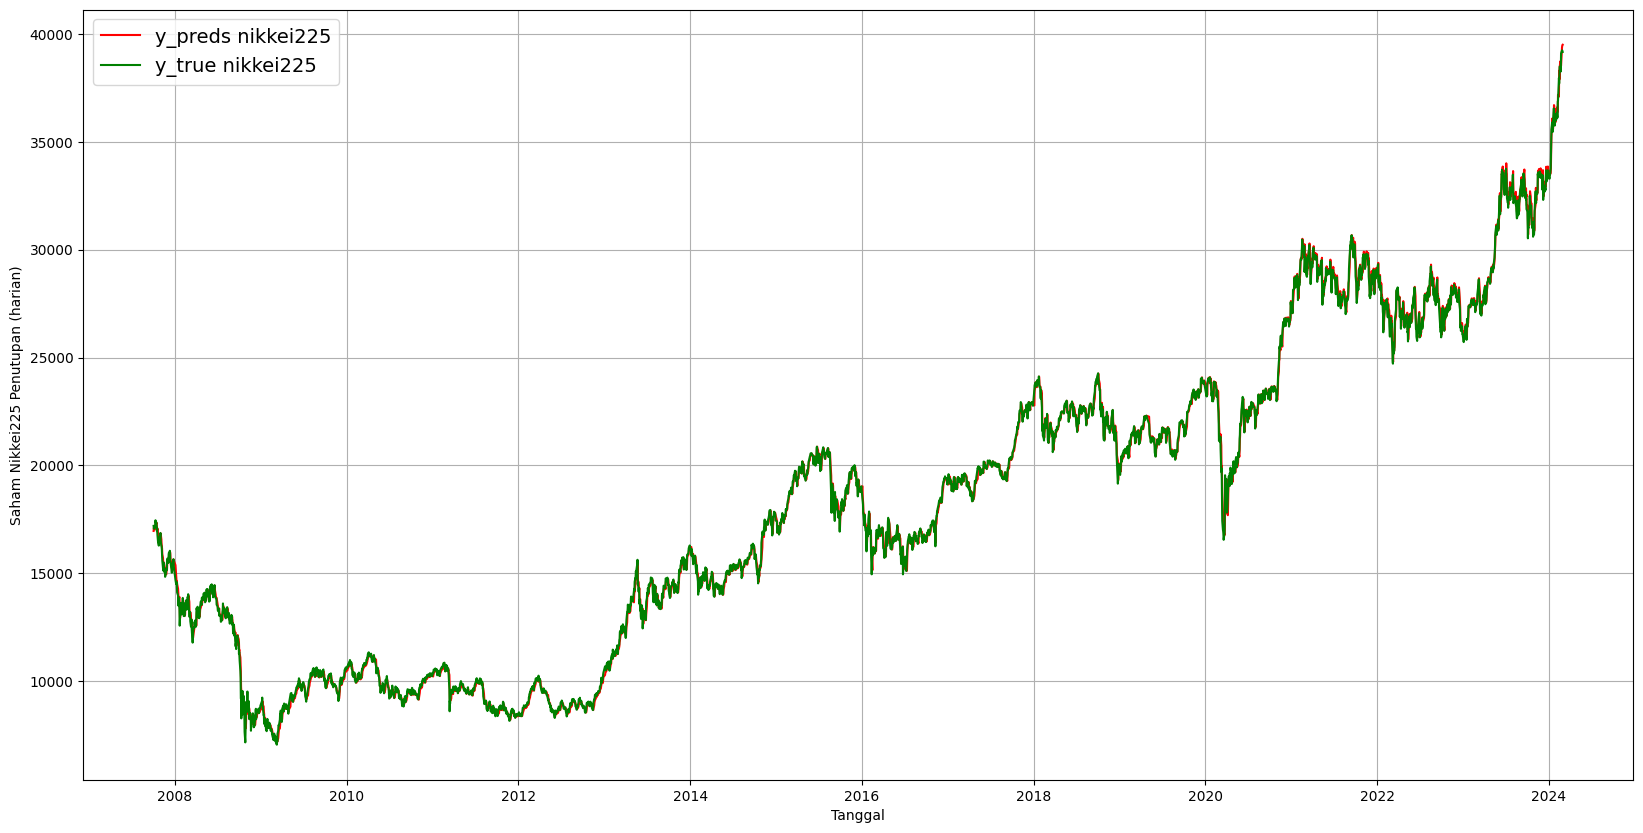

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_5_preds[:,0], format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_5_plot_prediksi_CNN-LSTM_multi.png')


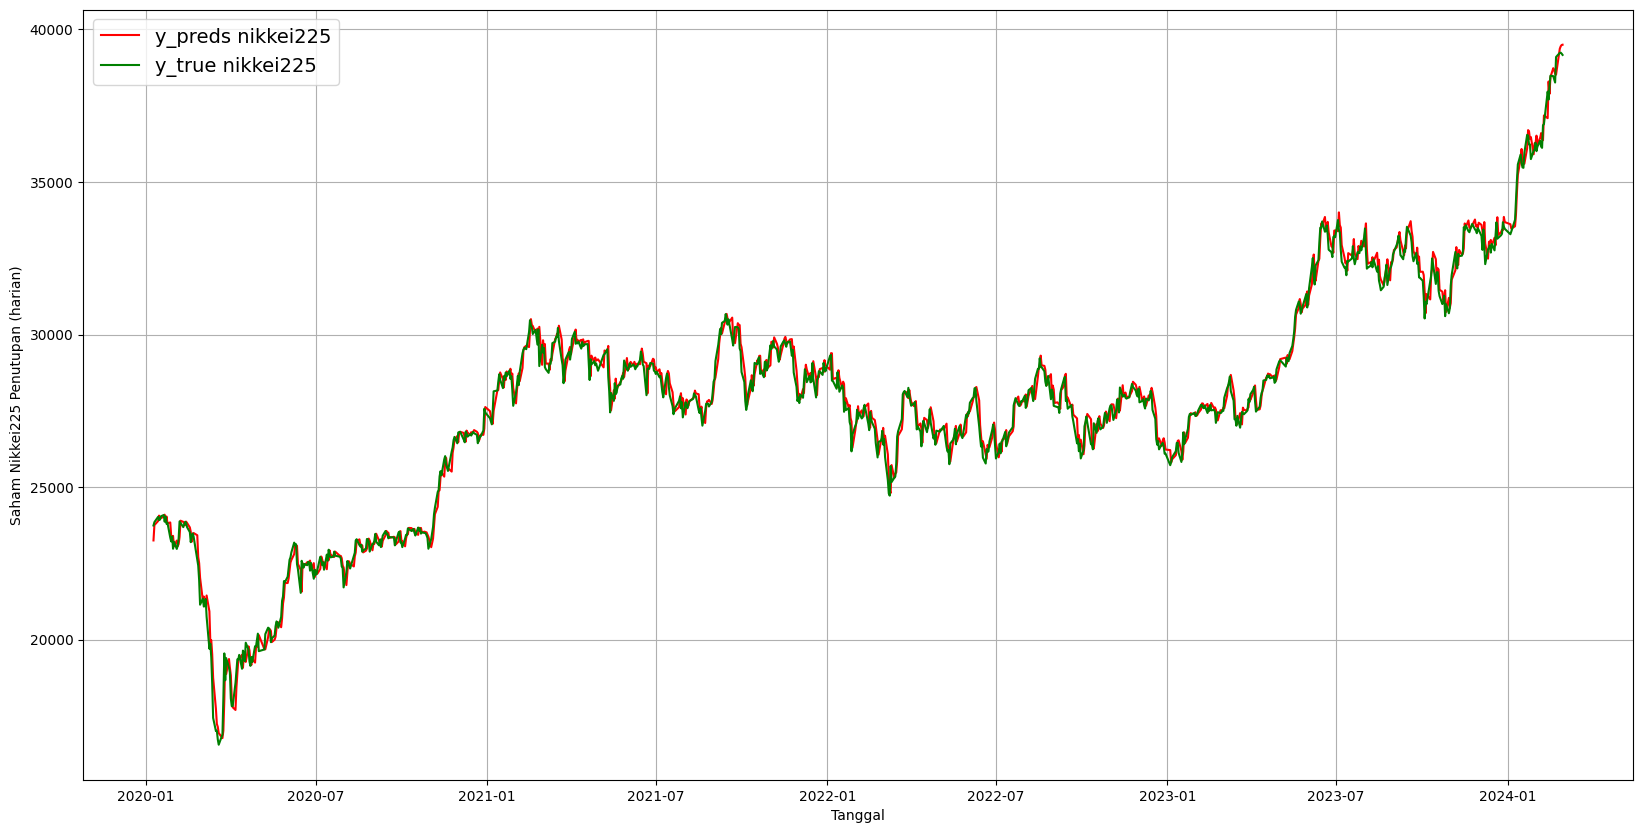

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_5_preds[:,0], format = "-", start = 3000, label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_labels[:,0], format = "-", start = 3000, label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_5_plot_prediksi_CNN-LSTM_multi_zoomin.png')


simpan model trained ke bentuk .h5

In [ ]:
from tensorflow.keras.models import save_model

# menyimpan model menjadi .h5 file
save_model(model_5, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_5_CNN-LSTM_multivariate.h5")


<ipython-input-147-d8daec1558df>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_5, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_5_CNN-LSTM_multivariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_5 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_5_CNN-LSTM_multivariate.h5")


# Membuat univariate time series forecasting stock price

In [82]:
print(full_windows[:, 0]),
print(full_windows[:, 0].shape)
print("\n")
print(full_labels[:, 0])
print(full_labels[:, 0].shape)

[[5.95337367e-04 5.62921348e-01]
 [5.18206571e-04 5.62921348e-01]
 [4.44140575e-04 5.62921348e-01]
 ...
 [9.26307910e-01 2.24719101e-02]
 [9.21365920e-01 2.24719101e-02]
 [9.20325420e-01 2.24719101e-02]]
(20064, 2)


[3.26911982e-04 3.32019981e-04 3.02648983e-04 ... 1.00000000e+00
 9.99195745e-01 9.98127152e-01]
(20064,)


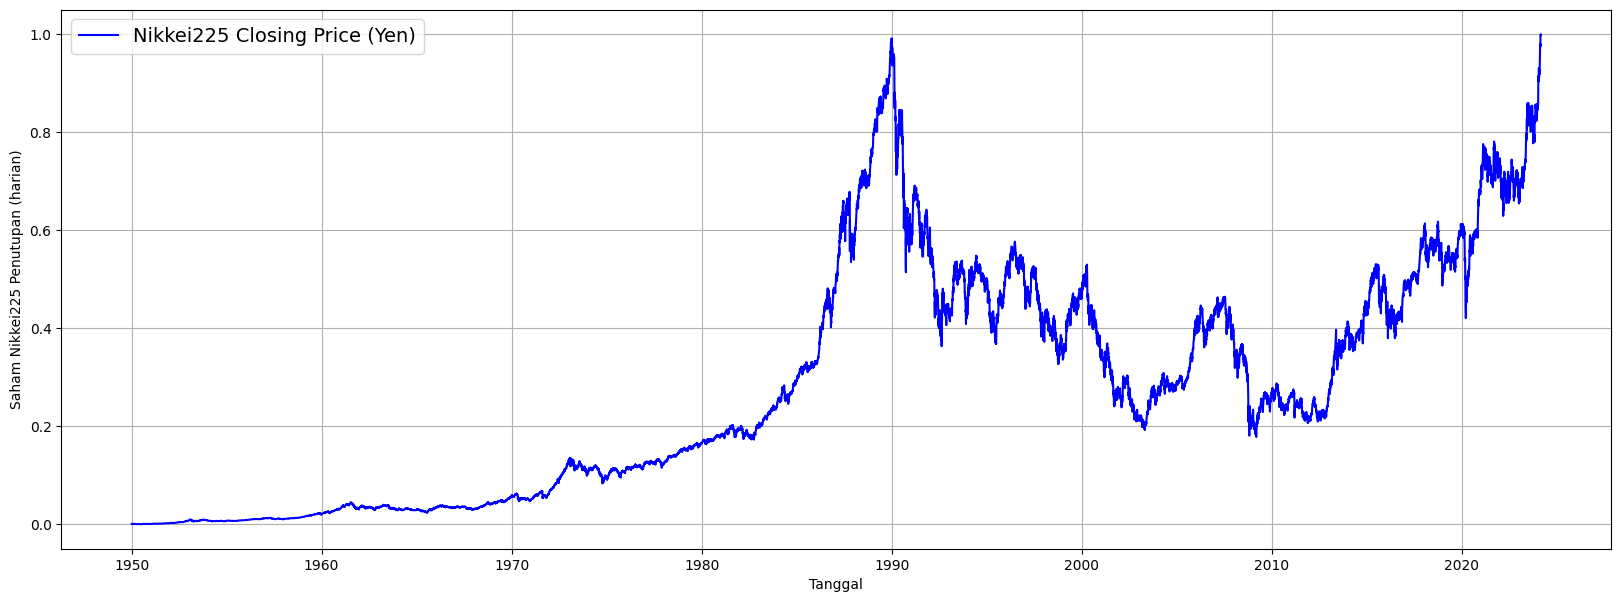

In [83]:
plt.figure(figsize = (20,7))
plot_time_series(timesteps = nikkei225_close_multivariate_df.index.tolist(), values = normalized_data[:,0], format = "-", label = "Nikkei225 Closing Price (Yen)", color = 'b')

memanggil variabel window dan label untuk univariate nikkei stock price

In [84]:
X_nikkei.shape, y_nikkei.shape

((20064, 14, 1), (20064, 1, 1))

reshape dimensi X_nikkei dan y_nikkei dan masukkan ke variabel baru

In [85]:
train_nikkeiWindows = np.squeeze(X_nikkei[:len(X_nikkei[: int(SPLIT_SIZE * len(X_nikkei))])])
test_nikkeiWindows = np.squeeze(X_nikkei[len(X_nikkei[: int(SPLIT_SIZE * len(X_nikkei))]):])

train_nikkeiLabels = np.squeeze(y_nikkei[:len(y_nikkei[: int(SPLIT_SIZE * len(y_nikkei))])])
test_nikkeiLabels = np.squeeze(y_nikkei[len(y_nikkei[: int(SPLIT_SIZE * len(y_nikkei))]):])

In [86]:
train_nikkeiWindows.shape, test_nikkeiWindows.shape

((16051, 14), (4013, 14))

In [87]:
train_nikkeiWindows.shape[1]

14

In [88]:
train_nikkeiLabels.shape, test_nikkeiLabels.shape

((16051,), (4013,))

# Model 6: Conv1D Univariate

In [89]:
train_nikkeiWindows.shape

(16051, 14)

## Tuner Builder

In [ ]:
#create Conv1D model
def model_Conv1D_uni_builder(hp):
  tf.random.set_seed(42)

  model_6 = tf.keras.models.Sequential([
      #layers.Lambda(lambda x: tf.expand_dims(x, axis = 1)),
      tf.keras.layers.Conv1D(filters = hp.Int('conv1D_n_filters', min_value=32, max_value=256, step=32),
                             kernel_size = hp.Int('conv1D_kernel_size', min_value=5, max_value=10, step=1),
                             strides = 1,
                             padding ="causal",
                             input_shape = (WINDOW_SIZE, 1)),
      tf.keras.layers.GlobalMaxPooling1D(),  # Add GlobalMaxPooling1D layer
      tf.keras.layers.Dense(1)

      #filters adalah jumlah hidden unit dalam layers tersebut
      # kernel size adalah ukuran dari window. Ex: kernel_size = 7 artinya melihat 7 value sekaligus
      # default nilai strides = 1, ini sudah sesuai karena sliding window bergeser satu timesteps
  ], name = "model_6_conv1D_univariate")

  #compile model 1
  model_6.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_6

In [ ]:
import keras_tuner as kt

tuner_Conv1D_uni = kt.Hyperband(model_Conv1D_uni_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_tuning_logs',
                     project_name='Conv1D_univariate')



## Proses tuning


In [ ]:
tuner_Conv1D_uni.search(train_nikkeiWindows,
                        train_nikkeiLabels,
                        epochs=10,
                        validation_data=(test_nikkeiWindows, test_nikkeiLabels),
                        batch_size=128)

Trial 30 Complete [00h 00m 13s]
val_loss: 0.009130381979048252

Best val_loss So Far: 0.008977560326457024
Total elapsed time: 00h 03m 34s


## Hasil parameter tuning terbaik

In [ ]:
tuner_Conv1D_uni.get_best_hyperparameters(num_trials=1)[0]

In [ ]:
# mengeluarkan hyperparameter optimal
best_hps=tuner_Conv1D_uni.get_best_hyperparameters(num_trials=1)[0]

tuning = ['conv1D_n_filters', 'conv1D_kernel_size', 'learning_rate']
print('Best tune model Conv1D univariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model Conv1D univariate:
conv1D_n_filters: 64
conv1D_kernel_size: 10
learning_rate: 0.01


## Hasil semua parameter tuning

In [ ]:
tuning =['conv1D_n_filters', 'conv1D_kernel_size', 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hps_all = tuner_Conv1D_uni.get_best_hyperparameters(num_trials=30)
for hps in hps_all:
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam= pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_best_hyperparameter_models/hp_Con1D_uni.csv')
df_hyparam



conv1D_n_filters  conv1D_kernel_size  learning_rate
0                 64                  10         0.0100
1                 96                  10         0.0010
2                 32                  10         0.0010
3                 32                   8         0.0100
4                160                  10         0.0001
5                160                   5         0.0010
6                160                   8         0.0001
7                 32                   8         0.0100
8                128                  10         0.0001
9                 64                  10         0.0100
10               160                  10         0.0001
11               256                   8         0.0001
12               128                   7         0.0010
13               192                   6         0.0010
14               160                   8         0.0001
15                96                   9         0.0100
16               160                   8         0.0001
17                32                   6         0.0010
18                96                   9         0.0100
19               128                   5         0.0100
20                32                   6         0.0010
21               160                  10         0.0001
22               256                   6         0.0001
23               128                  10         0.0100
24               256                   5         0.0001
25               256                  10         0.0100
26               224                   5         0.0010
27               224                   5         0.0100
28                96                   7         0.0001
29                32                   6         0.0001

In [ ]:
tuner_Conv1D_uni.results_summary(num_trials=30)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_tuning_logs/Conv1D_univariate
Showing 30 best trials
Objective(name="val_loss", direction="min")

Trial 0025 summary
Hyperparameters:
conv1D_n_filters: 64
conv1D_kernel_size: 10
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020
Score: 0.008977560326457024

Trial 0029 summary
Hyperparameters:
conv1D_n_filters: 96
conv1D_kernel_size: 10
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.009130381979048252

Trial 0026 summary
Hyperparameters:
conv1D_n_filters: 32
conv1D_kernel_size: 10
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.009172306396067142

Trial 0024 summary
Hyperparameters:
conv1D_n_filters: 32
conv1D_kernel_size: 8
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tune

## Mengimplementasikan hyperparameter terbaik ke model

In [ ]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_6 = tuner_Conv1D_uni.hypermodel.build(best_hps)

## Melatih model

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_6 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_6_Conv1D_univariate.h5")


In [ ]:

# fit
history = model_6.fit(train_nikkeiWindows,
            train_nikkeiLabels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_nikkeiWindows, test_nikkeiLabels),
            callbacks = [create_model_checkpoint(model_name = model_6.name)])

Epoch 1/50
116/126 [==========================>...] - ETA: 0s - loss: 0.0195
Epoch 1: val_loss improved from inf to 0.01470, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_6_conv1D_univariate
126/126 [==============================] - 3s 16ms/step - loss: 0.0185 - val_loss: 0.0147
Epoch 2/50
122/126 [============================>.] - ETA: 0s - loss: 0.0074
Epoch 2: val_loss did not improve from 0.01470
126/126 [==============================] - 1s 9ms/step - loss: 0.0073 - val_loss: 0.0176
Epoch 3/50
126/126 [==============================] - ETA: 0s - loss: 0.0068
Epoch 3: val_loss did not improve from 0.01470
126/126 [==============================] - 1s 9ms/step - loss: 0.0068 - val_loss: 0.0160
Epoch 4/50
121/126 [===========================>..] - ETA: 0s - loss: 0.0062
Epoch 4: val_loss improved from 0.01470 to 0.01126, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_b

visualisasi model shape

In [ ]:
model_6.summary()

Model: "model_6_conv1D_univariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 14, 64)            704       
                                                                 
 global_max_pooling1d_1 (Gl  (None, 64)                0         
 obalMaxPooling1D)                                               
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 769 (3.00 KB)
Trainable params: 769 (3.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


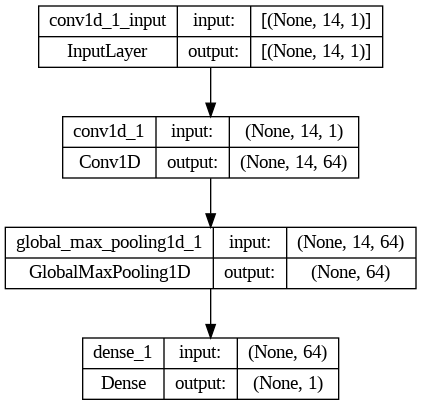

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_6, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_plot/model_Conv1D_uni_shape.png', show_shapes=True, show_layer_names=True)


visualisasi loss setiap epoch

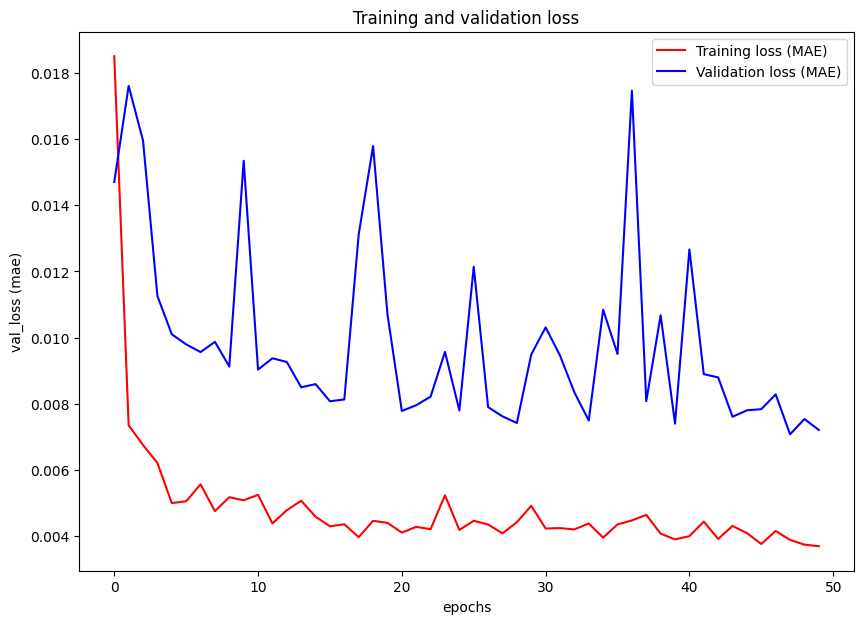

In [ ]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.title ('Training and validation loss')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.legend(loc=0)



# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_visualization/loss_Conv1D_uni.png')


# Membuat DataFrame loss dan val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan value loss dan validation loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_value_per_epoch/loss_Conv1D_uni.csv', index=False)


In [ ]:
# mengevaluasi model 6 dari epochs terakhir
model_6.evaluate(test_nikkeiWindows, test_nikkeiLabels)

126/126 [==============================] - 0s 2ms/step - loss: 0.0072


0.007207994814962149

In [ ]:
# mengevaluasi dan load model 6 pada best epoch yang loss mae paling kecil sepanjang training

model_6 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_6_conv1D_univariate")
model_6.evaluate(test_nikkeiWindows, test_nikkeiLabels)


126/126 [==============================] - 0s 2ms/step - loss: 0.0071


0.007076325826346874

In [ ]:
# membuat predicted value berdasarkan model multivariate model_1 yang sudah di train

model_6_preds = tf.squeeze(model_6.predict(test_nikkeiWindows))
model_6_preds



126/126 [==============================] - 0s 3ms/step


<tf.Tensor: shape=(4013,), dtype=float32, numpy=
array([0.4312027 , 0.43582702, 0.43648863, ..., 0.99824226, 1.0020869 ,
       1.0029422 ], dtype=float32)>

In [ ]:
model_6_preds.shape

TensorShape([4013])

## Denormalisasi nilai output prediksi dan test_labels

In [ ]:
denormalized_model_6_preds = scaler_univariate.inverse_transform([model_6_preds])
denormalized_test_nikkeiLabels = scaler_univariate.inverse_transform([test_nikkeiLabels])

In [ ]:
denormalized_model_6_preds = tf.squeeze(denormalized_model_6_preds)
denormalized_test_nikkeiLabels = tf.squeeze(denormalized_test_nikkeiLabels)

In [ ]:
# mengukur predicted value dengan metrik evaluasi regresion problem

model_6_results = evaluate_preds(y_true = denormalized_test_nikkeiLabels,
                                 y_pred = denormalized_model_6_preds)

model_6_results

{'mae': 277.06842,
 'mse': 161943.12,
 'rmse': 402.42157,
 'R-square': 0.9969180429974848}

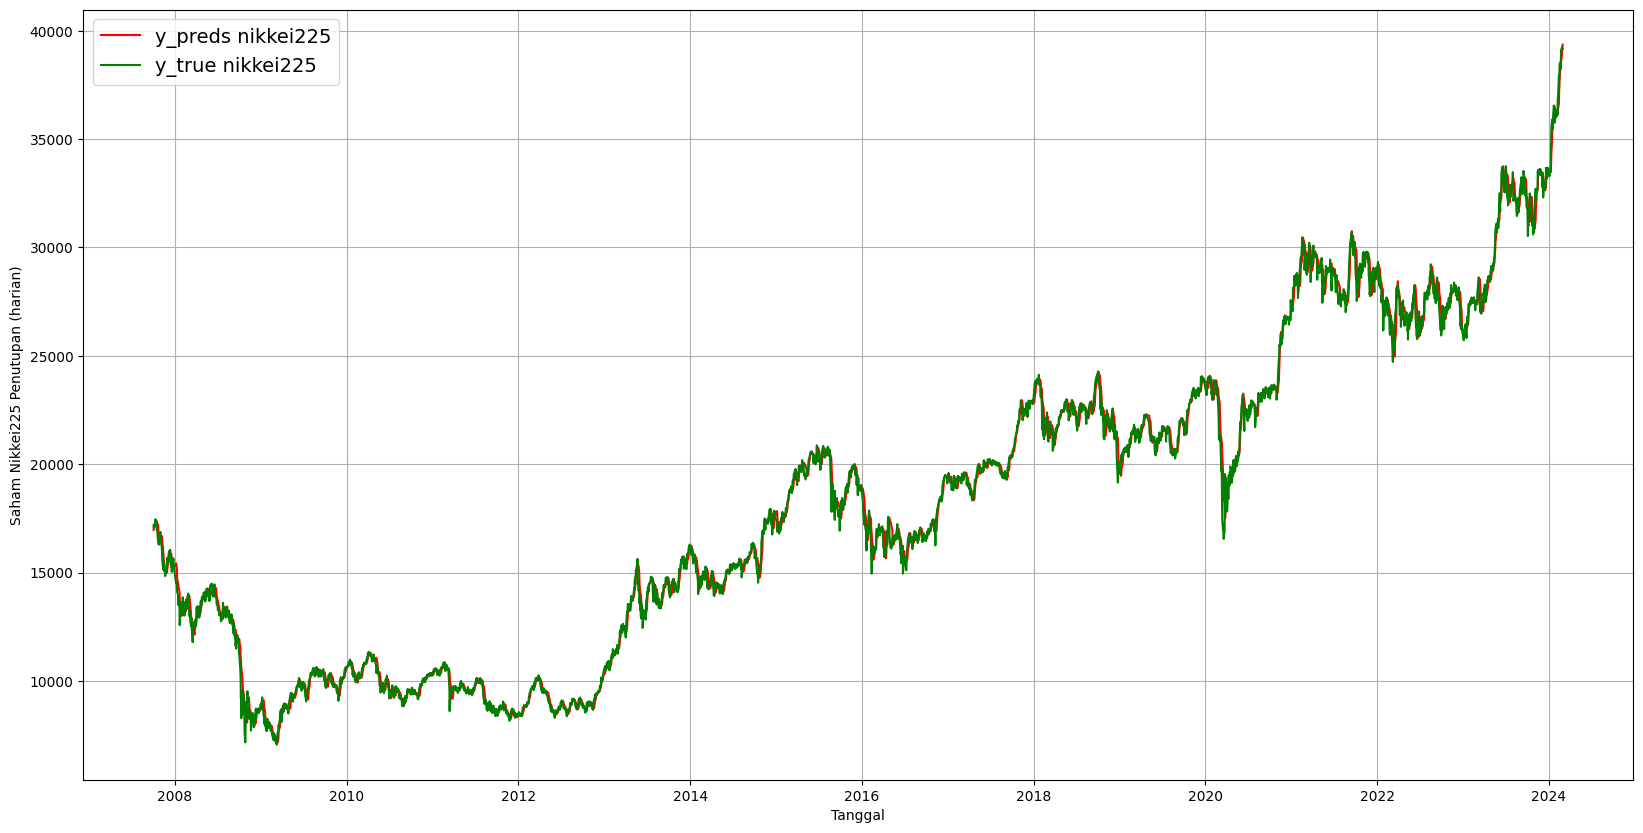

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_6_preds, format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-", label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_6_plot_prediksi_Conv1D_uni.png')


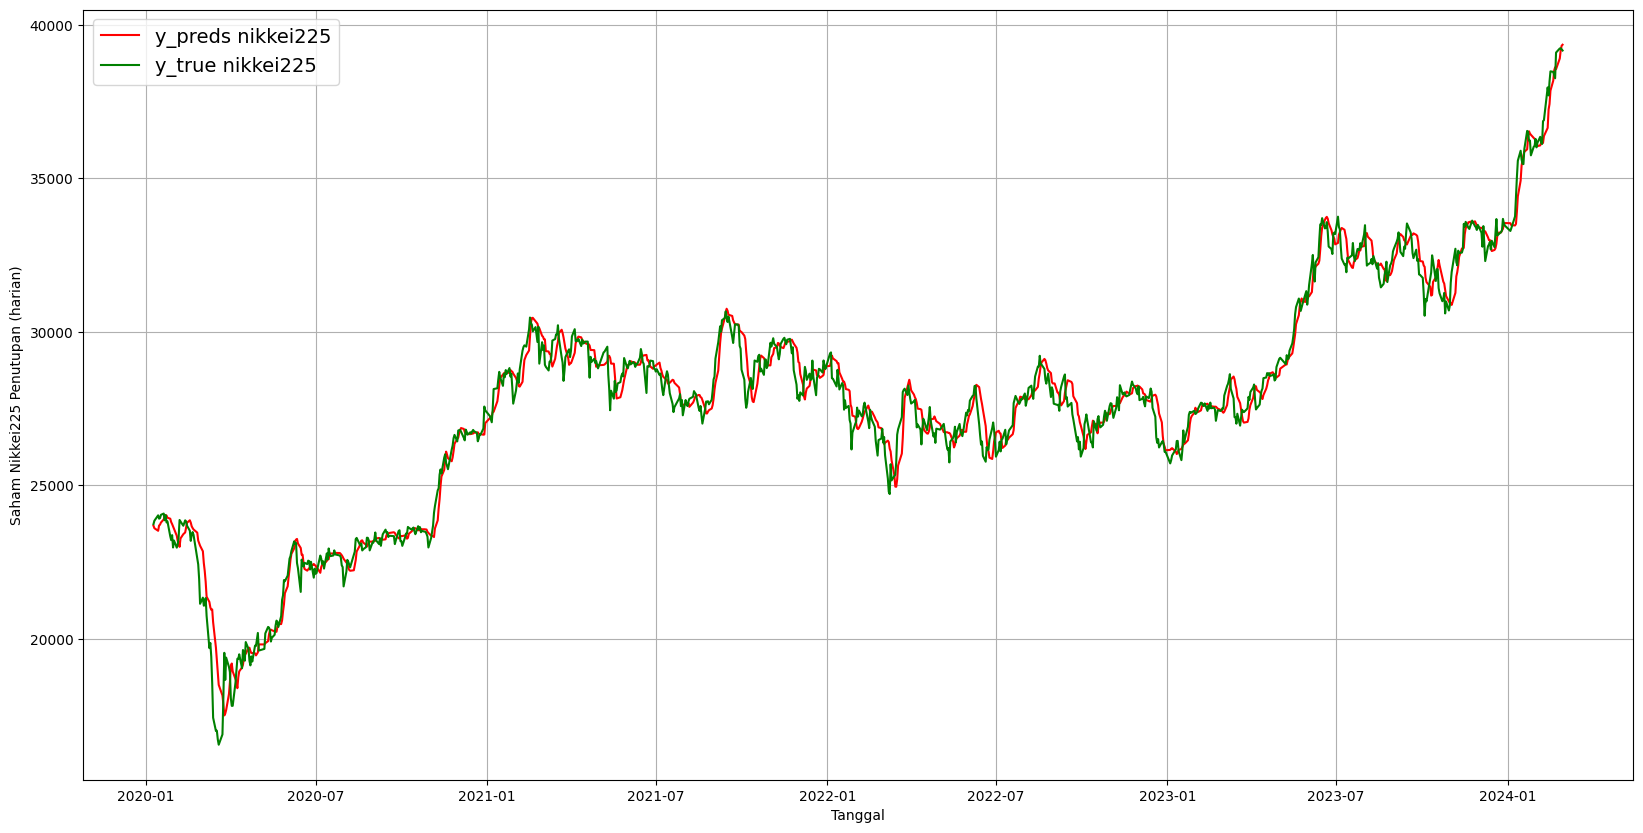

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_6_preds, format = "-", start = 3000,label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-", start = 3000,label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_6_plot_prediksi_Conv1D_uni_zoomin.png')


In [ ]:
from tensorflow.keras.models import save_model

# menyimpan model menjadi .h5 file
save_model(model_6, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_6_Conv1D_univariate.h5")


<ipython-input-179-b0e2834433a6>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_6, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_6_Conv1D_univariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_6 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_6_Conv1D_univariate.h5")


# Model 7: LSTM Univariate

## Tuner Builder

In [ ]:
# membuat model LSTM dengan hyperparameter tuning

def model_LSTM_uni_builder(hp):
  tf.random.set_seed(42)

  model_7 = tf.keras.models.Sequential([
          tf.keras.layers.LSTM(units = hp.Int('lstm_n_units', min_value=32, max_value=256, step=32),
                               input_shape=(WINDOW_SIZE, 1),
                               return_sequences = False,
                               activation = "relu"),
          #tf.keras.layers.Dropout(0.2),
          #tf.keras.layers.LSTM(128, return_sequences=False, activation = "relu"),

          tf.keras.layers.Dense(1, activation = "relu")
          ], name = "model_7_LSTM_univariate")



  #compile model 2
  model_7.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_7

In [ ]:
import keras_tuner as kt

tuner_LSTM_uni = kt.Hyperband(model_LSTM_uni_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_tuning_logs',
                     project_name='LSTM_univariate')

## Proses tuning


In [ ]:
tuner_LSTM_uni.search(train_nikkeiWindows,
                      train_nikkeiLabels,
                      epochs=10,
                      validation_data=(test_nikkeiWindows, test_nikkeiLabels),
                      batch_size = 128)

Trial 30 Complete [00h 03m 27s]
val_loss: 0.4625701904296875

Best val_loss So Far: 0.0053996373899281025
Total elapsed time: 00h 20m 40s


## Hasil parameter tuning terbaik

In [ ]:
# mengeluarkan hyperparameter optimal
best_hps=tuner_LSTM_uni.get_best_hyperparameters(num_trials=1)[0]

tuning = ['lstm_n_units', 'learning_rate']
print('Best tune model LSTM univariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model LSTM univariate:
lstm_n_units: 160
learning_rate: 0.01


## Hasil parameter semua tuning

In [ ]:
tuning =['lstm_n_units', 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hps_all =tuner_LSTM_uni.get_best_hyperparameters(num_trials=30)
for hps in hps_all :
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam= pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_best_hyperparameter_models/hp_LSTM_uni.csv')
df_hyparam


lstm_n_units  learning_rate
0            160         0.0100
1             96         0.0100
2            256         0.0100
3            160         0.0100
4             64         0.0010
5            192         0.0010
6             64         0.0010
7             64         0.0010
8             96         0.0001
9            224         0.0001
10           224         0.0001
11           256         0.0001
12            96         0.0001
13            32         0.0100
14           224         0.0001
15           256         0.0001
16           192         0.0001
17           192         0.0100
18           256         0.0010
19            32         0.0100
20           128         0.0100
21           224         0.0100
22           224         0.0010
23           128         0.0010
24           160         0.0001
25            32         0.0001
26            64         0.0001
27           128         0.0001
28           160         0.0010
29            32         0.0010

In [ ]:
tuner_LSTM_uni.results_summary(num_trials=30)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window7/8020_tuning_logs/LSTM_univariate
Showing 30 best trials
Objective(name="val_loss", direction="min")

Trial 0024 summary
Hyperparameters:
lstm_n_units: 160
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0021
Score: 0.004793946631252766

Trial 0028 summary
Hyperparameters:
lstm_n_units: 96
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.004981114529073238

Trial 0026 summary
Hyperparameters:
lstm_n_units: 256
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.005869293585419655

Trial 0021 summary
Hyperparameters:
lstm_n_units: 160
learning_rate: 0.01
tuner/epochs: 4
tuner/initial_epoch: 0
tuner/bracket: 1
tuner/round: 0
Score: 0.005880102980881929

Trial 0016 summary
Hyperparameters:
lstm_n_units: 64
learning_rate: 0.001
tuner/epoch

## Mengimplementasikan hyperparameter terbaik ke model

In [ ]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_7 = tuner_LSTM_uni.hypermodel.build(best_hps)

## Melatih model

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_7 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_7_LSTM_univariate.h5")


In [ ]:

# fit
history = model_7.fit(train_nikkeiWindows,
            train_nikkeiLabels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_nikkeiWindows, test_nikkeiLabels),
            callbacks = [create_model_checkpoint(model_name = model_7.name)])

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.0197
Epoch 1: val_loss improved from inf to 0.00696, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_7_LSTM_univariate
126/126 [==============================] - 18s 125ms/step - loss: 0.0197 - val_loss: 0.0070
Epoch 2/50
125/126 [============================>.] - ETA: 0s - loss: 0.0074
Epoch 2: val_loss improved from 0.00696 to 0.00673, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_7_LSTM_univariate
126/126 [==============================] - 13s 103ms/step - loss: 0.0074 - val_loss: 0.0067
Epoch 3/50
125/126 [============================>.] - ETA: 0s - loss: 0.0055
Epoch 3: val_loss did not improve from 0.00673
126/126 [==============================] - 5s 43ms/step - loss: 0.0055 - val_loss: 0.0129
Epoch 4/50
126/126 [==============================] - ETA: 0s - loss: 0.0057
Epoch 4: 

visualisasi model shape

In [ ]:
model_7.summary()

Model: "model_7_LSTM_univariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 160)               103680    
                                                                 
 dense_2 (Dense)             (None, 1)                 161       
                                                                 
Total params: 103841 (405.63 KB)
Trainable params: 103841 (405.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


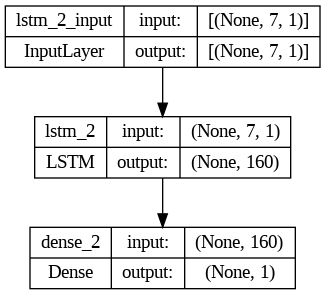

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_7, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_plot/model_LSTM_uni_shape.png', show_shapes=True, show_layer_names=True)


visualisasi loss setiap epoch

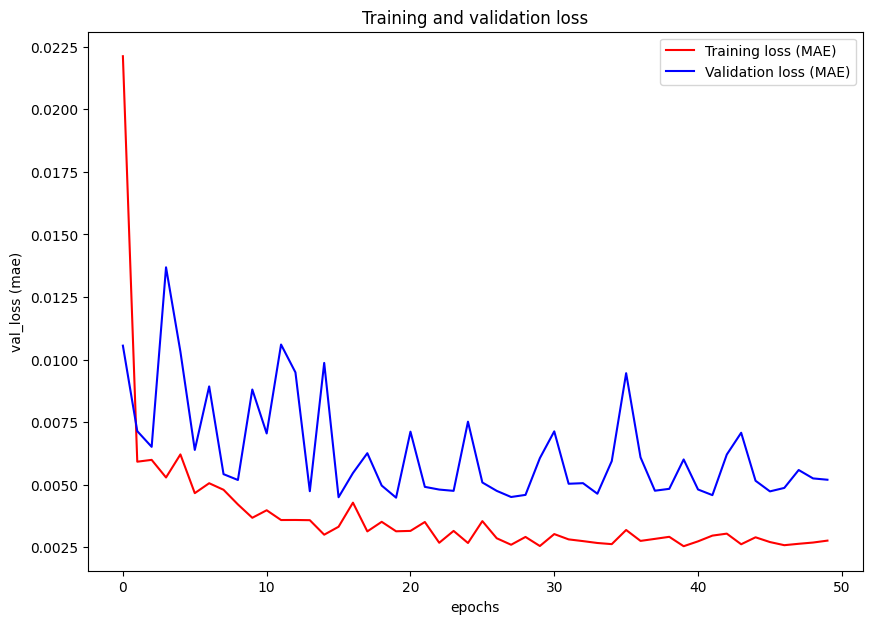

In [ ]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.title ('Training and validation loss')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.legend(loc=0)



# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_visualization/loss_LSTM_uni.png')



# Membuat DataFrame loss dan val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan value loss dan validation loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_value_per_epoch/loss_LSTM_uni.csv', index=False)


In [ ]:
# mengevaluasi model 7 dari epochs terakhir
model_7.evaluate(test_nikkeiWindows, test_nikkeiLabels)

126/126 [==============================] - 0s 3ms/step - loss: 0.0052


0.005194982513785362

In [ ]:
# mengevaluasi dan load model 7 pada best epoch yang loss mae paling kecil sepanjang training

model_7 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_7_LSTM_univariate")
model_7.evaluate(test_nikkeiWindows, test_nikkeiLabels)


126/126 [==============================] - 1s 4ms/step - loss: 0.0045


0.004478344228118658

In [ ]:
# membuat predicted value berdasarkan model multivariate model_7 yang sudah di train

model_7_preds = tf.squeeze(model_7.predict(test_nikkeiWindows))
model_7_preds



126/126 [==============================] - 1s 6ms/step


<tf.Tensor: shape=(4015,), dtype=float32, numpy=
array([0.42706117, 0.428247  , 0.43338946, ..., 1.0015519 , 1.0016418 ,
       1.0005083 ], dtype=float32)>

In [ ]:
model_7_preds[:2]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.42706117, 0.428247  ], dtype=float32)>

## Denormalisasi nilai output prediksi dan test_labels

In [ ]:
denormalized_model_7_preds = scaler_univariate.inverse_transform([model_7_preds])
denormalized_test_nikkeiLabels = scaler_univariate.inverse_transform([test_nikkeiLabels])

In [ ]:
denormalized_model_7_preds = tf.squeeze(denormalized_model_7_preds)
denormalized_test_nikkeiLabels = tf.squeeze(denormalized_test_nikkeiLabels)

In [ ]:
# mengukur predicted value dengan metrik evaluasi regresion problem

model_7_results = evaluate_preds(y_true = denormalized_test_nikkeiLabels,
                                 y_pred = denormalized_model_7_preds)

model_7_results

{'mae': 175.24121,
 'mse': 61564.613,
 'rmse': 248.12218,
 'R-square': 0.9988277908465574}

In [ ]:
tf.squeeze(test_nikkeiLabels[:])

<tf.Tensor: shape=(4009,), dtype=float64, numpy=
array([0.436546  , 0.44372504, 0.44046077, ..., 1.        , 0.99919575,
       0.99812715])>

In [ ]:
test_nikkeiLabels[:]

array([0.436546  , 0.44372504, 0.44046077, ..., 1.        , 0.99919575,
       0.99812715])

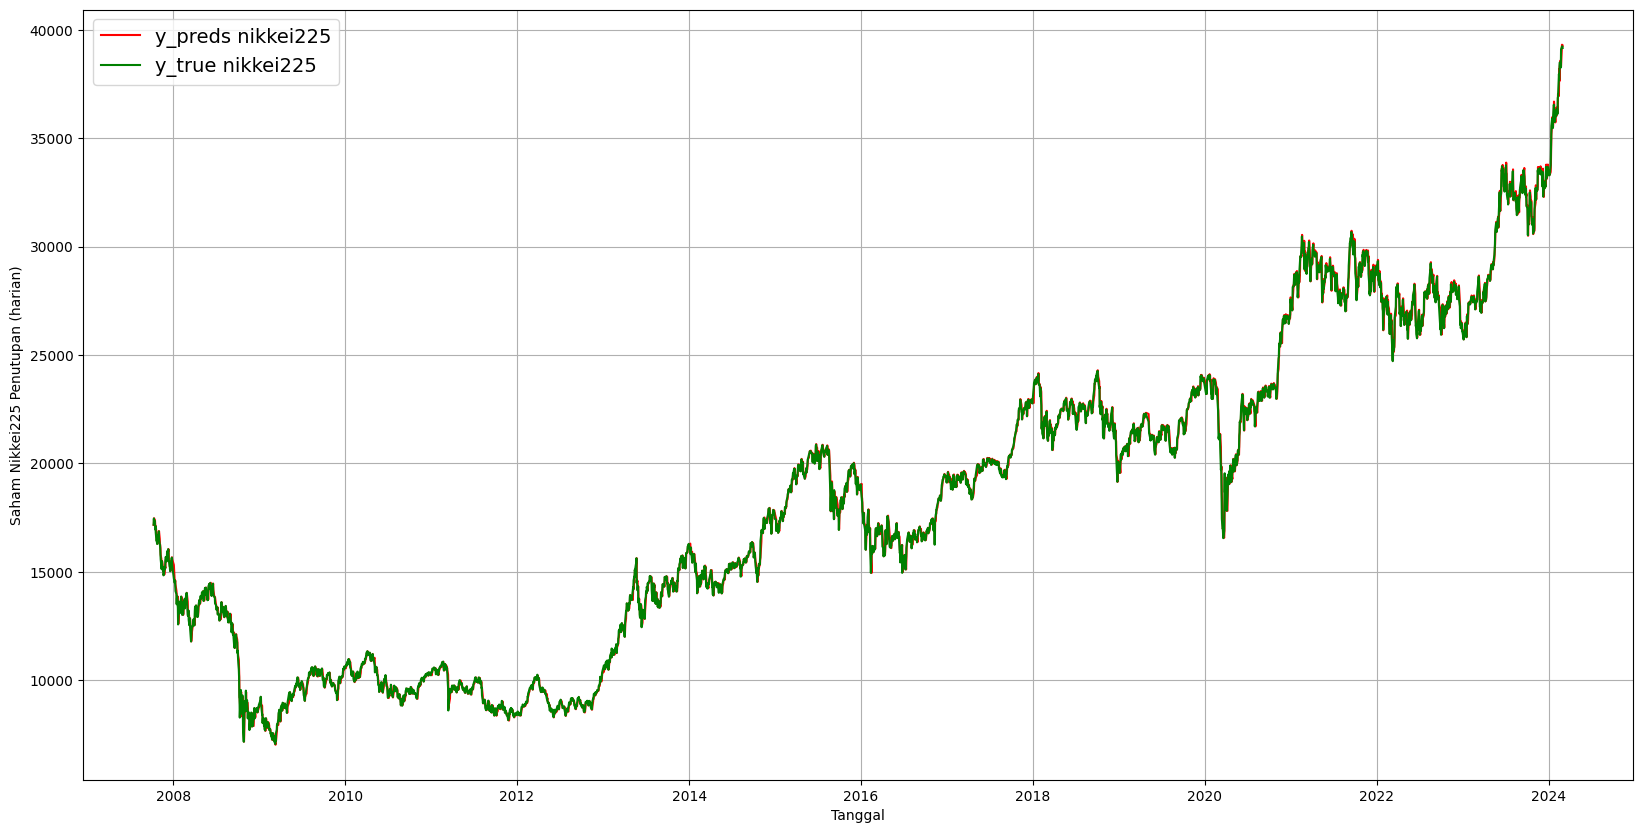

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_7_preds, format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-", label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_7_plot_prediksi_LSTM_uni.png')


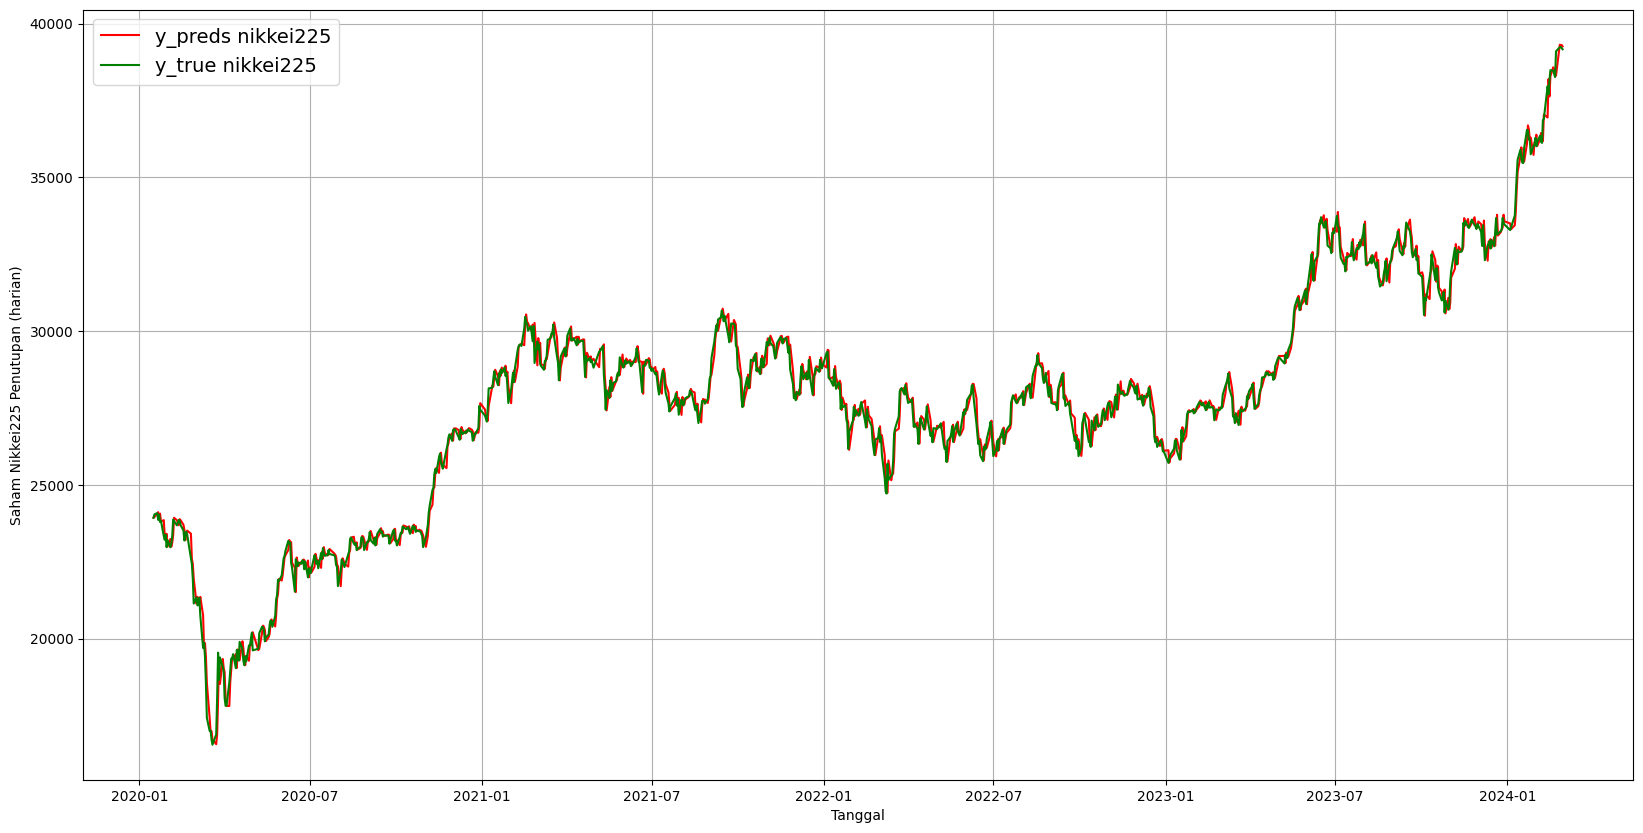

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_7_preds, format = "-", start = 3000, label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-", start = 3000, label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_7_plot_prediksi_LSTM_uni_zoomin.png')


simpan model trained ke bentuk h5.

In [ ]:
from tensorflow.keras.models import save_model

# menyimpan model menjadi .h5 file
save_model(model_7, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_7_LSTM_univariate.h5")


<ipython-input-128-1374810846e4>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_7, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window7/8020_saved_models/model_7_LSTM_univariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_7 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_7_LSTM_univariate.h5")


 # Model 8 : Stacked LSTM univariate

## Tuner builder

In [ ]:
# membuat model LSTM dengan hyperparameter tuning
def model_stackedLSTM_uni_builder(hp):

  tf.random.set_seed(42)
  model_8 = tf.keras.models.Sequential([
          tf.keras.layers.LSTM(units =  hp.Int('lstm_n_units', min_value=32, max_value=256, step=32),
                              input_shape=(WINDOW_SIZE, 1),
                              return_sequences = True,
                              activation = "relu"),

          #tf.keras.layers.Dropout(0.2, seed=42),
          tf.keras.layers.LSTM(units = hp.Int('lstm_n_units_2', min_value=32, max_value=256, step=32),
                              return_sequences = False,
                              activation = "relu"),

          #tf.keras.layers.LSTM(128, return_sequences=False, activation = "relu"),

          tf.keras.layers.Dense(1)
          ], name = "model_8_stackedLSTM_univariate")


  #compile model 8
  model_8.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_8

In [ ]:
import keras_tuner as kt

tuner_stackedLSTM_uni = kt.Hyperband(model_stackedLSTM_uni_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_tuning_logs',
                     project_name='stackedLSTM_univariate')

Reloading Tuner from /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window7/8020_tuning_logs/stackedLSTM_univariate/tuner0.json


## Proses tuning


In [ ]:
tuner_stackedLSTM_uni.search(train_nikkeiWindows,
                             train_nikkeiLabels,
                             epochs=10,
                             validation_data=(test_nikkeiWindows, test_nikkeiLabels),
                             batch_size = 128)

## Hasil parameter tuning terbaik

In [ ]:
# mengeluarkan hyperparameter optimal
best_hps = tuner_stackedLSTM_uni.get_best_hyperparameters(num_trials=1)[0]

tuning = ['lstm_n_units', "lstm_n_units_2", 'learning_rate']
print('Best tune model stacked LSTM univariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model stacked LSTM univariate:
lstm_n_units: 128
lstm_n_units_2: 32
learning_rate: 0.01


## Hasil semua parameter tuning

In [ ]:
tuning = ['lstm_n_units', "lstm_n_units_2", 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hps_all = tuner_stackedLSTM_uni.get_best_hyperparameters(num_trials=30)
for hps in hps_all:
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam = pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_best_hyperparameter_models/hp_Stacked_LSTM_uni.csv')
df_hyparam


lstm_n_units  lstm_n_units_2  learning_rate
0            128              32         0.0100
1            224             128         0.0100
2            128              32         0.0100
3             96             160         0.0010
4             64              32         0.0010
5            128              32         0.0001
6             96             160         0.0010
7             32             128         0.0010
8            128              32         0.0100
9            128              32         0.0001
10           128             128         0.0001
11           160             160         0.0001
12           128              64         0.0100
13            64              32         0.0010
14            96             128         0.0001
15           128             160         0.0001
16           224             192         0.0100
17            64              32         0.0010
18            96             128         0.0001
19           128             160         0.0001
20            64             256         0.0001
21            64             160         0.0100
22            64              64         0.0100
23            96              32         0.0001
24           160             160         0.0100
25           192              64         0.0100
26            64             192         0.0100
27            64             224         0.0100
28           192             192         0.0100
29            32              64         0.0001

In [ ]:
tuner_stackedLSTM_uni.results_summary(num_trials=30)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window7/8020_tuning_logs/stackedLSTM_univariate
Showing 30 best trials
Objective(name="val_loss", direction="min")

Trial 0016 summary
Hyperparameters:
lstm_n_units: 128
lstm_n_units_2: 32
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.006175097543746233

Trial 0026 summary
Hyperparameters:
lstm_n_units: 224
lstm_n_units_2: 128
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.0065564727410674095

Trial 0012 summary
Hyperparameters:
lstm_n_units: 128
lstm_n_units_2: 32
learning_rate: 0.01
tuner/epochs: 4
tuner/initial_epoch: 2
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: 0006
Score: 0.0071226973086595535

Trial 0024 summary
Hyperparameters:
lstm_n_units: 96
lstm_n_units_2: 160
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner

## Mengimplementasikan hyperparameter terbaik ke model

In [ ]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_8 = tuner_stackedLSTM_uni.hypermodel.build(best_hps)

## Melatih model

In [90]:
from tensorflow.keras.models import load_model

# Load the saved model
model_8 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_8_stackedLSTM_univariate.h5")


In [ ]:

# fit
history = model_8.fit(train_nikkeiWindows,
            train_nikkeiLabels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_nikkeiWindows, test_nikkeiLabels),
            callbacks = [create_model_checkpoint(model_name = model_8.name)])

Epoch 1/50
125/126 [============================>.] - ETA: 0s - loss: 0.0221
Epoch 1: val_loss improved from inf to 0.02994, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window7/8020_model_best_epoch/model_8_stackedLSTM_univariate
126/126 [==============================] - 10s 59ms/step - loss: 0.0221 - val_loss: 0.0299
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.0102
Epoch 2: val_loss improved from 0.02994 to 0.01583, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window7/8020_model_best_epoch/model_8_stackedLSTM_univariate
126/126 [==============================] - 5s 40ms/step - loss: 0.0102 - val_loss: 0.0158
Epoch 3/50
124/126 [============================>.] - ETA: 0s - loss: 0.0105
Epoch 3: val_loss improved from 0.01583 to 0.01011, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window7/8020_model_best_epoch/model_8_stackedLSTM_univariate
126/126 [================

visualisasi model shape

In [ ]:
model_8.summary()

Model: "model_8_stackedLSTM_univariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 7, 128)            66560     
                                                                 
 lstm_4 (LSTM)               (None, 32)                20608     
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 87201 (340.63 KB)
Trainable params: 87201 (340.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


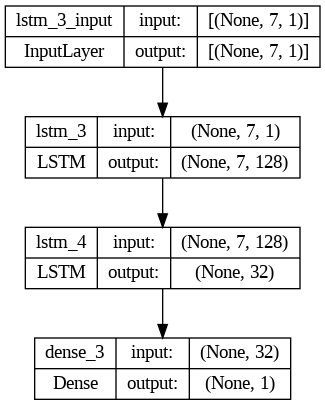

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_8, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_plot/model_stackedLSTM_uni_shape.png', show_shapes=True, show_layer_names=True)


visualisasi loss setiap epoch

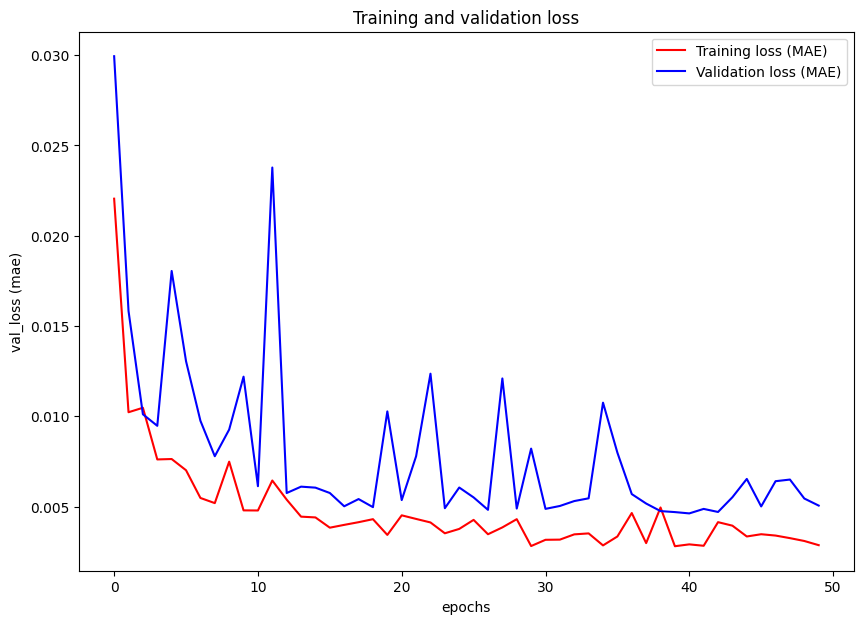

In [ ]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.title ('Training and validation loss')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.legend(loc=0)


# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_visualization/loss_stackedLSTM_uni.png')

# Create a DataFrame from loss and val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan visualisasi loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_value_per_epoch/loss_stackedLSTM_uni.csv', index=False)


In [ ]:
# mengevaluasi model 8 dari epochs terakhir
model_8.evaluate(test_nikkeiWindows, test_nikkeiLabels)

126/126 [==============================] - 1s 4ms/step - loss: 0.0051


0.005053186789155006

In [ ]:
# mengevaluasi dan load model 8 pada best epoch yang loss mae paling kecil sepanjang training

model_8 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_8_stackedLSTM_univariate")
model_8.evaluate(test_nikkeiWindows, test_nikkeiLabels)



126/126 [==============================] - 1s 4ms/step - loss: 0.0046


0.00462078582495451

In [91]:
# membuat predicted value berdasarkan model multivariate model_8 yang sudah di train

model_8_preds = tf.squeeze(model_8.predict(test_nikkeiWindows))
model_8_preds



126/126 [==============================] - 4s 28ms/step


<tf.Tensor: shape=(4013,), dtype=float32, numpy=
array([0.43376222, 0.43768963, 0.43500125, ..., 0.9986102 , 1.0054907 ,
       0.9991365 ], dtype=float32)>

In [92]:
model_8_preds[:2]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.43376222, 0.43768963], dtype=float32)>

## Denormalisasi nilai output prediksi dan test_labels

In [93]:
denormalized_model_8_preds = scaler_univariate.inverse_transform([model_8_preds])
denormalized_test_nikkeiLabels = scaler_univariate.inverse_transform([test_nikkeiLabels])

In [94]:
denormalized_model_8_preds = tf.squeeze(denormalized_model_8_preds)
denormalized_test_nikkeiLabels = tf.squeeze(denormalized_test_nikkeiLabels)

In [95]:
# mengukur predicted value dengan metrik evaluasi regresion problem

model_8_results = evaluate_preds(y_true = denormalized_test_nikkeiLabels,
                                 y_pred = denormalized_model_8_preds)

model_8_results

{'mae': 179.95088,
 'mse': 65140.42,
 'rmse': 255.22621,
 'R-square': 0.9987603055875132}

In [ ]:
tf.squeeze(test_nikkeiLabels)

<tf.Tensor: shape=(4009,), dtype=float64, numpy=
array([0.436546  , 0.44372504, 0.44046077, ..., 1.        , 0.99919575,
       0.99812715])>

In [ ]:
test_nikkeiLabels[:]

array([0.436546  , 0.44372504, 0.44046077, ..., 1.        , 0.99919575,
       0.99812715])

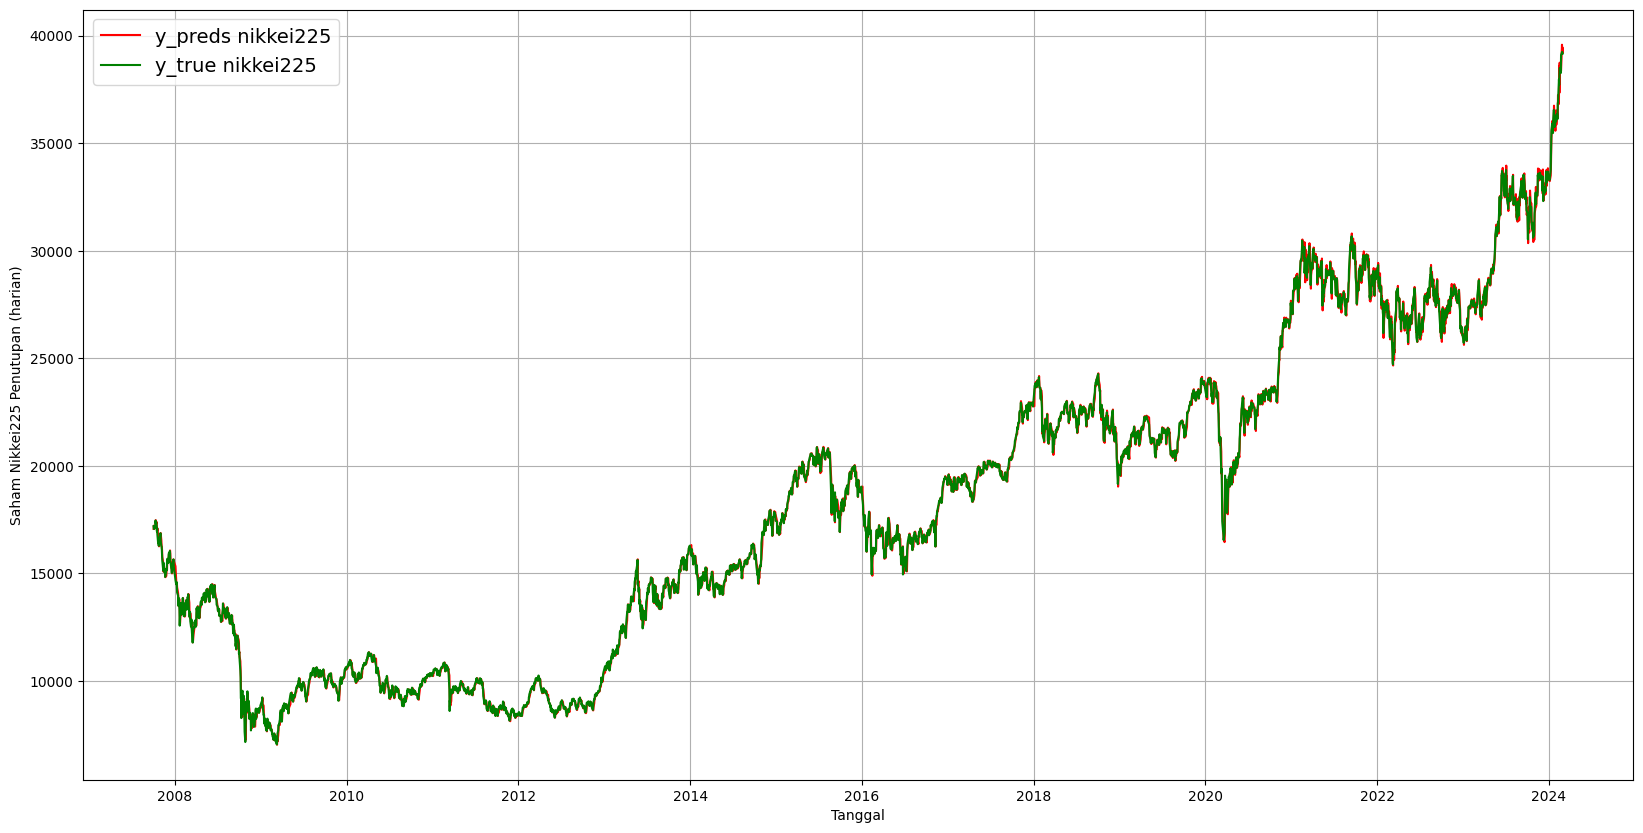

In [97]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_8_preds, format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-", label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_8_plot_prediksi_stackedLSTM_uni.png')


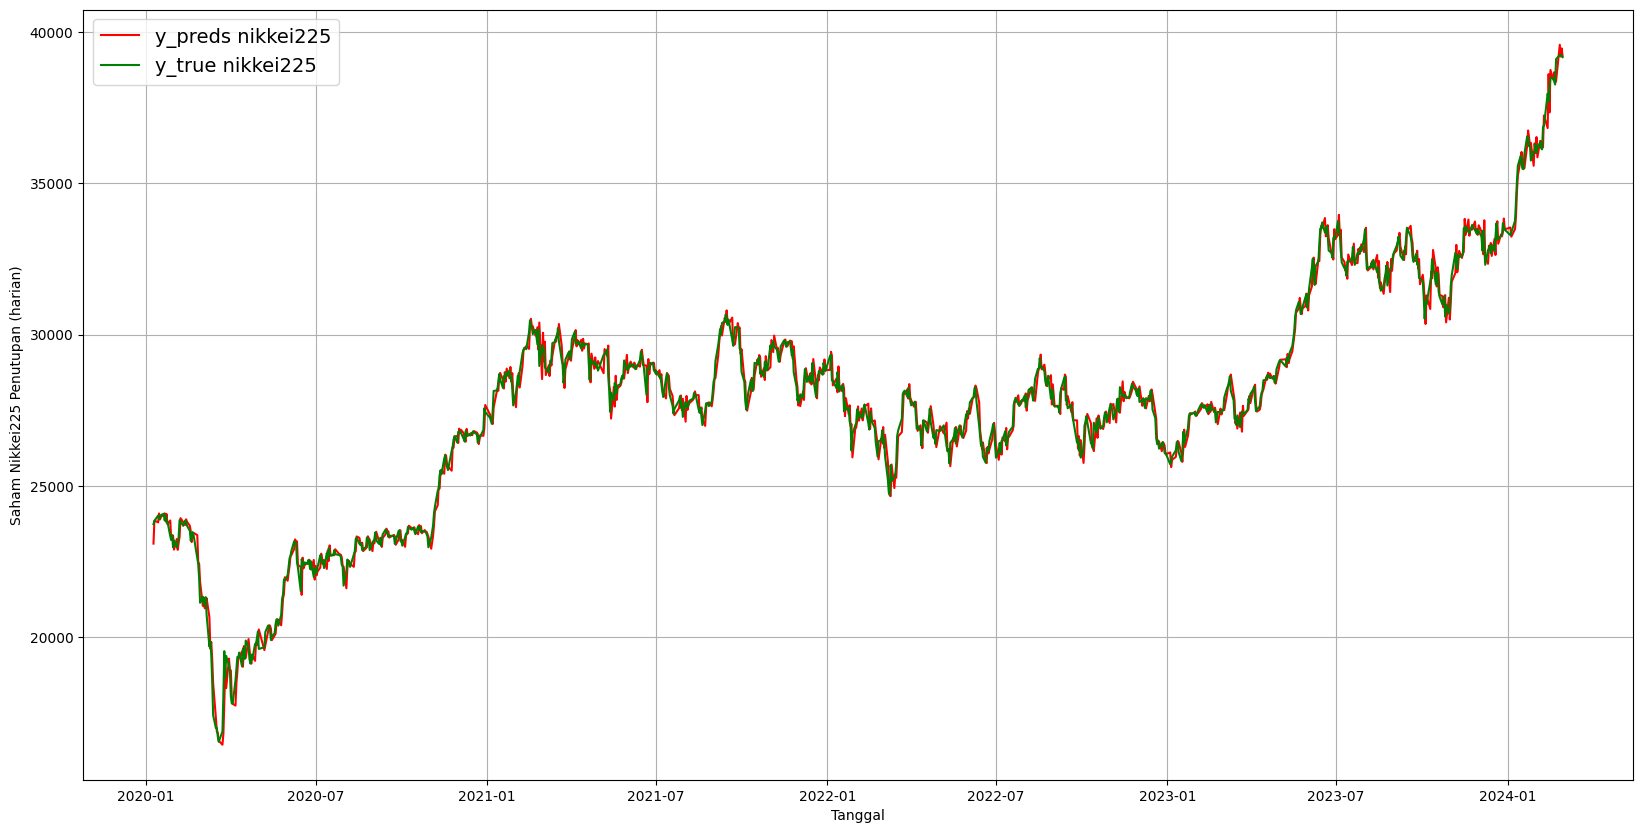

In [96]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_8_preds, format = "-",start = 3000, label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-",start = 3000, label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_8_plot_prediksi_stackedLSTM_uni_zoomin.png')


simpan model trained ke bentuk .h5

In [ ]:
from tensorflow.keras.models import save_model

# menyimpan model menjadi .h5 file
save_model(model_8, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_8_stackedLSTM_univariate.h5")


<ipython-input-150-9c4c999e8fa8>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_8, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window7/8020_saved_models/model_8_stackedLSTM_univariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_8 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_8_stackedLSTM_univariate.h5")


# Model 9: Bidirectional LSTM Univariate

In [ ]:
train_nikkeiWindows.shape

(16062, 7)

In [ ]:
test_nikkeiLabels.shape

(4009,)

## Tuner Builder

In [ ]:
def model_bidirectional_LSTM_uni_builder(hp):

  tf.random.set_seed(42)
  model_9 = tf.keras.models.Sequential([
          #tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis = 1)),
          tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1), # ini lambda layer sumberny dari bangkit C4W3 lab1
                        input_shape=[WINDOW_SIZE]),

          tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(units = hp.Int('bi_lstm_n_units', min_value=32, max_value=256, step=32),
                                                             input_shape=(WINDOW_SIZE, 1),
                                                             return_sequences = False,
                                                             activation = "relu")),
          #tf.keras.layers.Dropout(0.2, seed=42),
          #tf.keras.layers.LSTM(128, return_sequences = False, activation = "relu"),

          #tf.keras.layers.LSTM(128, return_sequences=False, activation = "relu"),

          tf.keras.layers.Dense(1)
          ], name = "model_9_bidirectionalLSTM_univariate")


  #compile model 2
  model_9.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_9

In [ ]:
import keras_tuner as kt

tuner_bi_LSTM_uni = kt.Hyperband(model_bidirectional_LSTM_uni_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_tuning_logs',
                     project_name='bi_LSTM_univariate')

## Proses tuning


In [ ]:
tuner_bi_LSTM_uni.search(train_nikkeiWindows,
                         train_nikkeiLabels,
                         epochs=10,
                         validation_data=(test_nikkeiWindows, test_nikkeiLabels),
                         batch_size = 128)

Trial 30 Complete [00h 00m 21s]
val_loss: 0.006720428355038166

Best val_loss So Far: 0.0056548654101789
Total elapsed time: 00h 17m 46s


## Hasil parameter tuning terbaik

In [ ]:
# mengeluarkan hyperparameter optimal
best_hps=tuner_bi_LSTM_uni.get_best_hyperparameters(num_trials=1)[0]

tuning = ["bi_lstm_n_units", 'learning_rate']
print('Best tune model bidirectional LSTM univariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model bidirectional LSTM univariate:
bi_lstm_n_units: 96
learning_rate: 0.01


## Hasil semua parameter tuning

In [ ]:
tuning = ["bi_lstm_n_units", 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hp_all=tuner_bi_LSTM_uni.get_best_hyperparameters(num_trials=30)
for hps in hp_all:
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam= pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_best_hyperparameter_models/hp_bi_LSTM_uni.csv')
df_hyparam


bi_lstm_n_units  learning_rate
0                96         0.0100
1               256         0.0010
2               128         0.0100
3                32         0.0100
4                32         0.0010
5               192         0.0001
6               256         0.0010
7                64         0.0010
8               192         0.0001
9                64         0.0010
10              224         0.0001
11              192         0.0001
12               32         0.0010
13               32         0.0010
14               32         0.0001
15               96         0.0001
16              224         0.0010
17              192         0.0010
18               96         0.0010
19              192         0.0010
20              224         0.0010
21              128         0.0010
22               64         0.0001
23              128         0.0001
24              224         0.0100
25              192         0.0100
26              160         0.0010
27              256         0.0100
28               64         0.0100
29              160         0.0100

In [ ]:
tuner_bi_LSTM_uni.results_summary(num_trials=10)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/8020_tuning_logs/bi_LSTM_univariate
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0028 summary
Hyperparameters:
bi_lstm_n_units: 96
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.0056548654101789

Trial 0024 summary
Hyperparameters:
bi_lstm_n_units: 256
learning_rate: 0.001
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020
Score: 0.0065358481369912624

Trial 0026 summary
Hyperparameters:
bi_lstm_n_units: 128
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.00667840288951993

Trial 0029 summary
Hyperparameters:
bi_lstm_n_units: 32
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.006720428355038166

Trial 0017 summary
Hyperparameters:
bi_lstm_n_units: 32
learning_rate: 0.001
tuner/epochs

## Mengimplementasikan hyperparameter terbaik ke model

In [ ]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_9 = tuner_bi_LSTM_uni.hypermodel.build(best_hps)

## Melatih model

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_9 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_9_bidirectionalLSTM_univariate.h5")


In [ ]:

# fit
history = model_9.fit(train_nikkeiWindows,
            train_nikkeiLabels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_nikkeiWindows, test_nikkeiLabels),
            callbacks = [create_model_checkpoint(model_name = model_9.name)])

Epoch 1/50
126/126 [==============================] - ETA: 0s - loss: 0.0158
Epoch 1: val_loss improved from inf to 0.02265, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/8020_model_best_epoch/model_9_bidirectionalLSTM_univariate
126/126 [==============================] - 13s 86ms/step - loss: 0.0158 - val_loss: 0.0227
Epoch 2/50
126/126 [==============================] - ETA: 0s - loss: 0.0065
Epoch 2: val_loss improved from 0.02265 to 0.01073, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/8020_model_best_epoch/model_9_bidirectionalLSTM_univariate
126/126 [==============================] - 9s 74ms/step - loss: 0.0065 - val_loss: 0.0107
Epoch 3/50
125/126 [============================>.] - ETA: 0s - loss: 0.0081
Epoch 3: val_loss improved from 0.01073 to 0.00751, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/8020_model_best_epoch/model_9_bidirectionalLSTM_univariate
126/126 [==============================] - 8s 66ms/step - los

visualisasi model shape

In [ ]:
model_9.summary()

Model: "model_9_bidirectionalLSTM_univariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 7, 1)              0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 192)               75264     
 onal)                                                           
                                                                 
 dense_1 (Dense)             (None, 1)                 193       
                                                                 
Total params: 75457 (294.75 KB)
Trainable params: 75457 (294.75 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


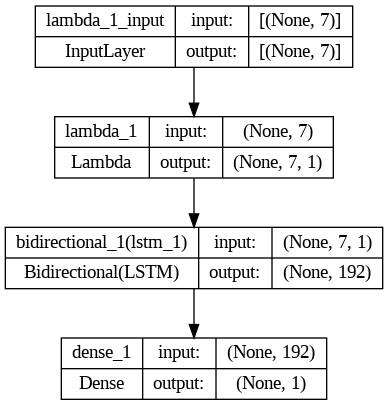

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_9, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_plot/model_biLSTM_uni_shape.png', show_shapes=True, show_layer_names=True)


visualisasi loss setiap epoch

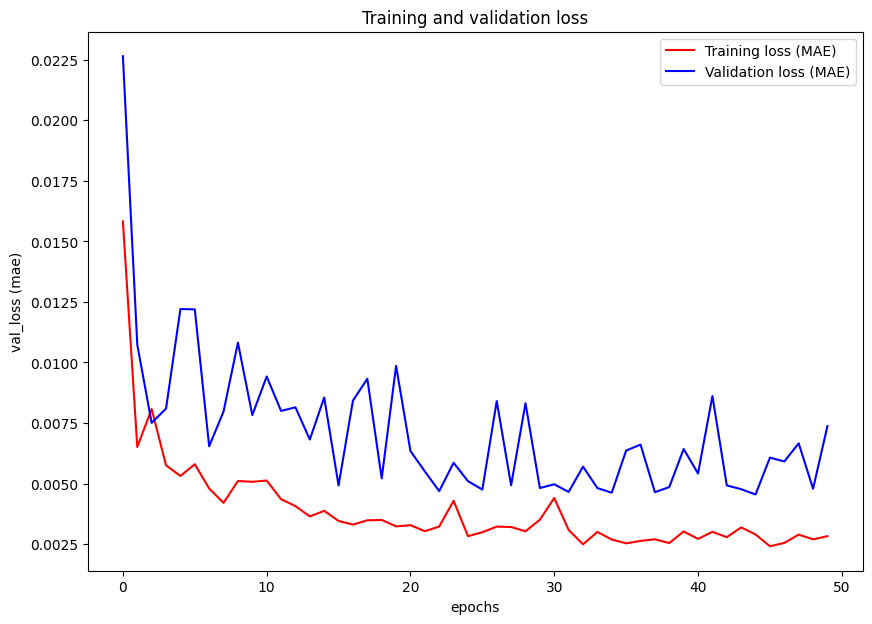

In [ ]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.title ('Training and validation loss')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.legend(loc=0)


# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_visualization/loss_bidirectional_LSTM_uni.png')



# Membuat DataFrame loss dan val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan value loss dan validation loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_value_per_epoch/loss_bidirectional_LSTM_uni.csv', index=False)


In [ ]:
# mengevaluasi model 9 dari epochs terakhir
model_9.evaluate(test_nikkeiWindows, test_nikkeiLabels)

126/126 [==============================] - 1s 4ms/step - loss: 0.0074


0.007372042629867792

In [ ]:
# mengevaluasi dan load model 9 pada best epoch yang loss mae paling kecil sepanjang training

model_9 = tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_9_bidirectionalLSTM_univariate")
model_9.evaluate(test_nikkeiWindows, test_nikkeiLabels)


126/126 [==============================] - 1s 5ms/step - loss: 0.0045


0.004547766409814358

In [ ]:
# membuat predicted value berdasarkan model multivariate model_1 yang sudah di train

model_9_preds = tf.squeeze(model_9.predict(test_nikkeiWindows))
model_9_preds



126/126 [==============================] - 1s 5ms/step


<tf.Tensor: shape=(4015,), dtype=float32, numpy=
array([0.4270353 , 0.42919144, 0.43347088, ..., 0.99423563, 0.9968939 ,
       0.99707794], dtype=float32)>

In [ ]:
model_9_preds[:2]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.4270353 , 0.42919144], dtype=float32)>

## Denormalisasi nilai output prediksi dan test_labels

In [ ]:
denormalized_model_9_preds = scaler_univariate.inverse_transform([model_9_preds])
denormalized_test_nikkeiLabels = scaler_univariate.inverse_transform([test_nikkeiLabels])

In [ ]:
denormalized_model_9_preds = tf.squeeze(denormalized_model_9_preds)
denormalized_test_nikkeiLabels = tf.squeeze(denormalized_test_nikkeiLabels)

In [ ]:
# mengukur predicted value dengan metrik evaluasi regresion problem

model_9_results = evaluate_preds(y_true = denormalized_test_nikkeiLabels,
                                 y_pred = denormalized_model_9_preds)

model_9_results

{'mae': 177.93683,
 'mse': 63451.44,
 'rmse': 251.89569,
 'R-square': 0.9987918650342921}

In [ ]:
tf.squeeze(test_nikkeiLabels[:])

<tf.Tensor: shape=(4009,), dtype=float64, numpy=
array([0.436546  , 0.44372504, 0.44046077, ..., 1.        , 0.99919575,
       0.99812715])>

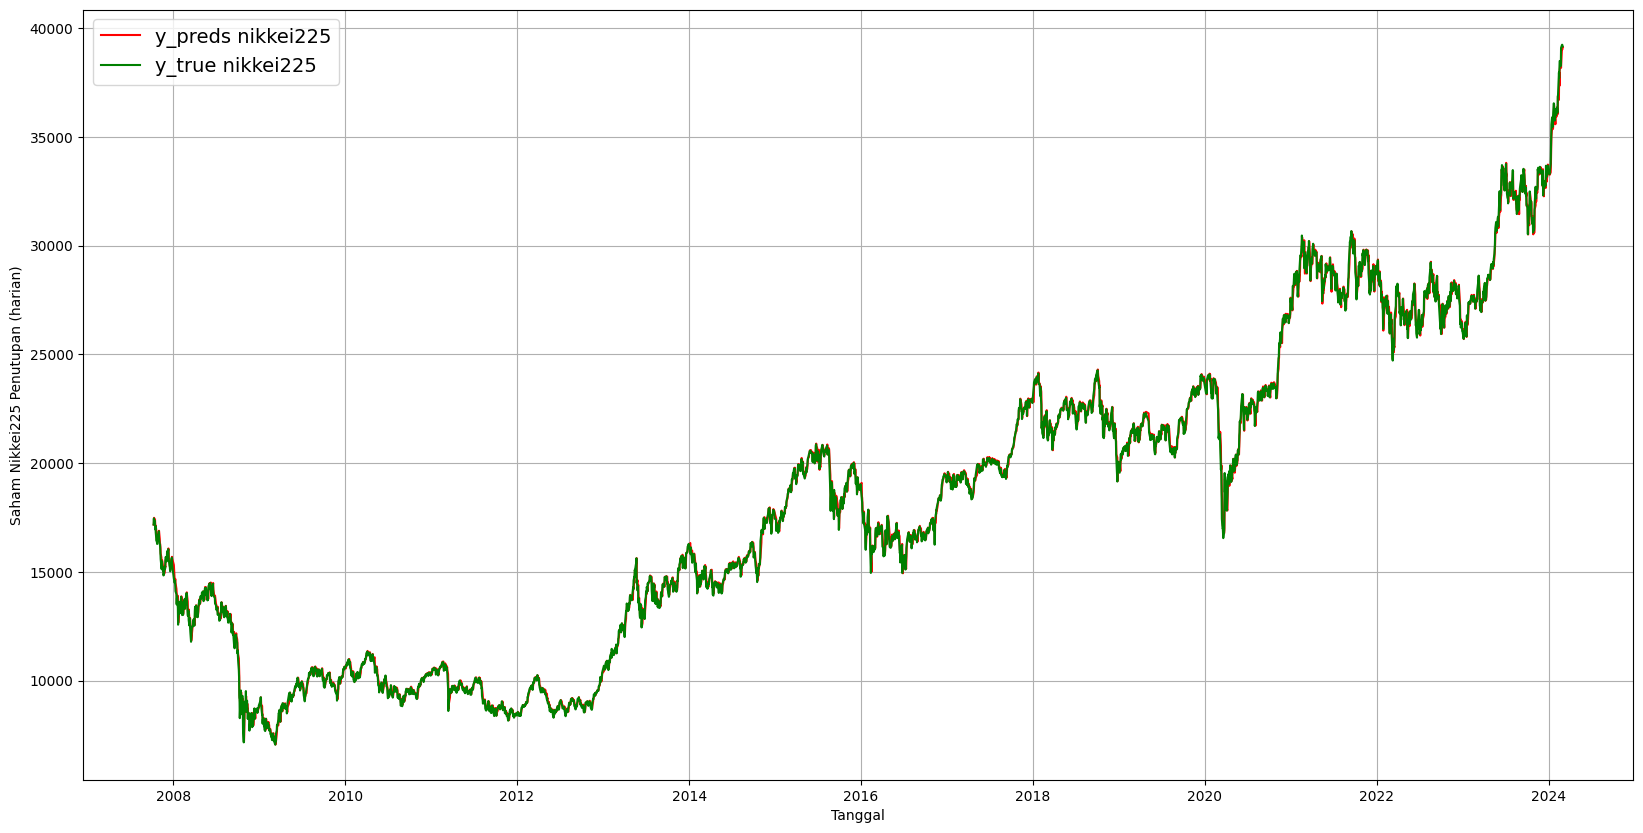

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_9_preds, format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-", label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_9_plot_prediksi_biLSTM_uni.png')


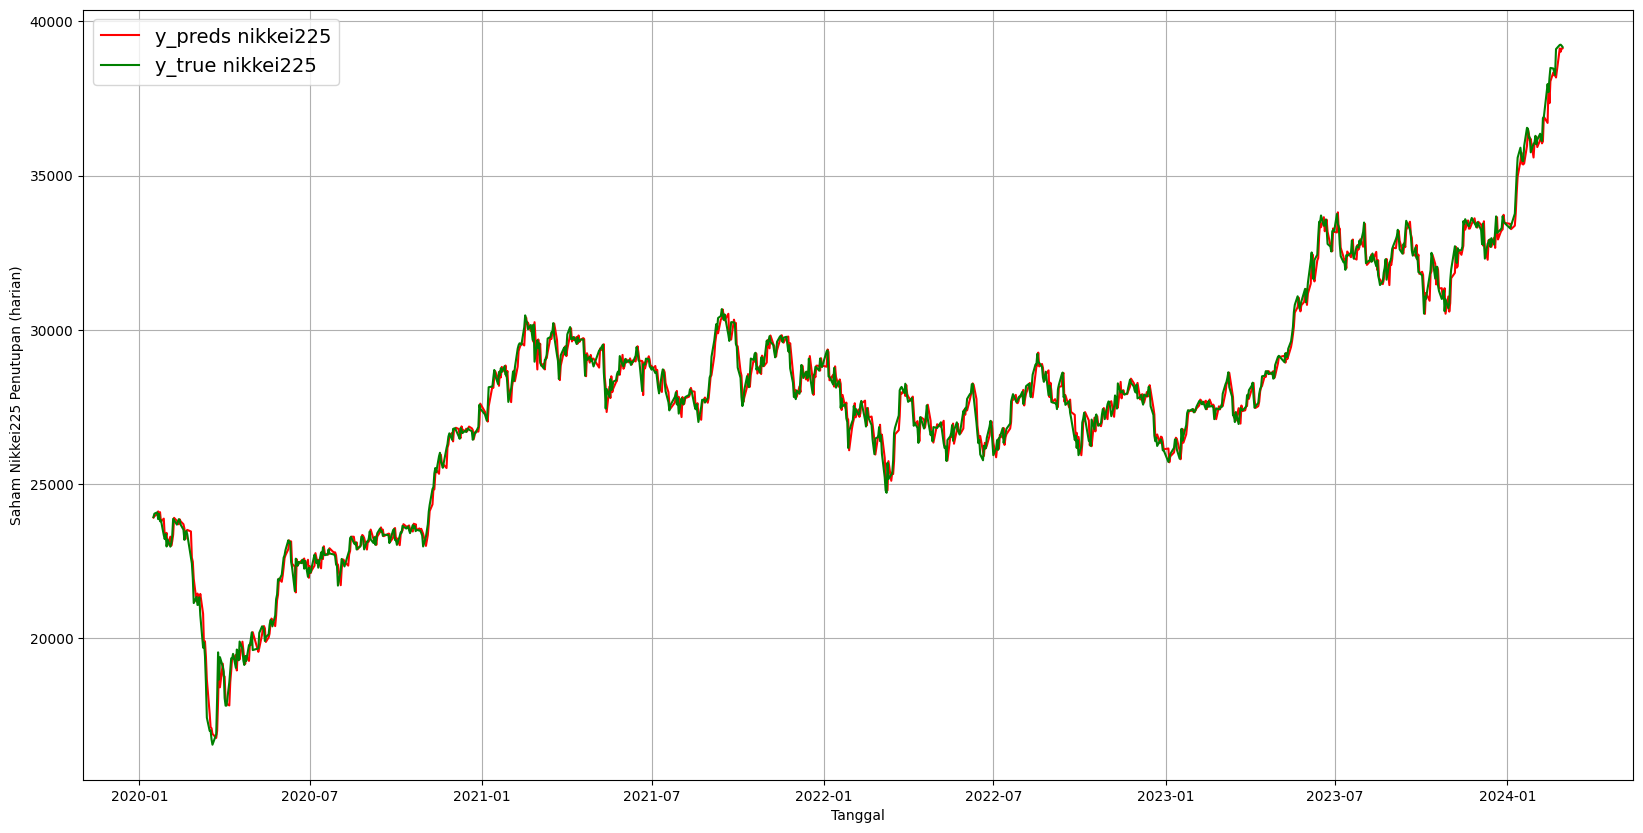

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_9_preds, format = "-", start = 3000, label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-",start = 3000,  label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_9_plot_prediksi_biLSTM_uni_zoomin.png')


simpan model trained ke bentuk .h5

In [ ]:
from tensorflow.keras.models import save_model

# menyimpan model menjadi .h5 file
save_model(model_9, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_9_bidirectionalLSTM_univariate.h5")



<ipython-input-290-07262568c2e3>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_9, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/8020_saved_models/model_9_bidirectionalLSTM_univariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_9 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_9_bidirectionalLSTM_univariate.h5")


# Model 10: CNN-LSTM Univariate

## Tuner Builder

In [ ]:
#create Conv1D model
def model_CNN_LSTM_uni_builder(hp):
  tf.random.set_seed(42)
  model_10 = tf.keras.models.Sequential([
      #layers.Lambda(lambda x: tf.expand_dims(x, axis = 1)),
      tf.keras.layers.Conv1D(filters=hp.Int('Conv1D_n_filters', min_value=32, max_value=256, step=32),
                             kernel_size=hp.Int('Conv1_kernel_size', min_value=5, max_value=10, step=1),
                             strides=1,
                             padding="causal",
                             activation="relu",
                             input_shape=[WINDOW_SIZE, 1]),

      tf.keras.layers.LSTM(units = hp.Int('LSTM_n_units', min_value=32, max_value=256, step=32),
                           return_sequences=False),

      tf.keras.layers.Dense(1),
      #filters adalah jumlah hidden unit dalam layers tersebut
      # kernel size adalah ukuran dari window. Ex: kernel_size = 7 artinya melihat 7 value sekaligus
      # default nilai strides = 1, ini sudah sesuai karena sliding window bergeser satu timesteps
  ], name = "model_10_CNN-LSTM_univariate")

  #compile model 10
  model_10.compile(loss="mae",
                  optimizer = tf.keras.optimizers.Adam(hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])))

  return model_10

In [ ]:
import keras_tuner as kt

tuner_CNN_LSTM_uni = kt.Hyperband(model_CNN_LSTM_uni_builder,
                     objective='val_loss',
                     max_epochs=10,
                     factor=3,
                     directory='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_tuning_logs',
                     project_name='CNN_LSTM_univariate')


## Proses tuning


In [ ]:
tuner_CNN_LSTM_uni.search(train_nikkeiWindows,
                          train_nikkeiLabels,
                          epochs=10,
                          validation_data=(test_nikkeiWindows, test_nikkeiLabels),
                          batch_size = 128)

Trial 30 Complete [00h 00m 46s]
val_loss: 0.006272781640291214

Best val_loss So Far: 0.005423174239695072
Total elapsed time: 00h 15m 48s


## Hasil parameter tuning terbaik

In [ ]:
# mengeluarkan hyperparameter optimal
best_hps=tuner_CNN_LSTM_uni.get_best_hyperparameters(num_trials=1)[0]

tuning = ['Conv1D_n_filters', 'Conv1_kernel_size', "LSTM_n_units", 'learning_rate']
print('Best tune model bidirectional LSTM univariate:')
for tune in tuning:
  print(f'{tune}: {best_hps.get(tune)}')

Best tune model bidirectional LSTM univariate:
Conv1D_n_filters: 32
Conv1_kernel_size: 5
LSTM_n_units: 160
learning_rate: 0.01


## Hasil semua parameter tuning

In [ ]:
tuning = ['Conv1D_n_filters', 'Conv1_kernel_size', "LSTM_n_units", 'learning_rate']
hps_dict = dict(zip(tuning, [[] for _ in range(len(tuning))]))

hps_all=tuner_CNN_LSTM_uni.get_best_hyperparameters(num_trials=30)
for hps in hps_all:
  for t in tuning:
    hps_dict[t].append(hps.get(t))

df_hyparam= pd.DataFrame(hps_dict)
df_hyparam.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_best_hyperparameter_models/hp_CNN_LSTM_uni.csv')
df_hyparam



Conv1D_n_filters  Conv1_kernel_size  LSTM_n_units  learning_rate
0                 32                  5           160         0.0100
1                224                  5           192         0.0100
2                 32                 10           128         0.0100
3                224                  9            64         0.0100
4                224                  5           192         0.0100
5                 96                  5           160         0.0010
6                192                  5            96         0.0100
7                224                  5           192         0.0100
8                160                  6           256         0.0010
9                192                  7            32         0.0010
10                64                  6            64         0.0010
11                32                 10           128         0.0100
12                96                  5           160         0.0010
13               160                  6           256         0.0010
14                64                  8           192         0.0010
15                96                  9           224         0.0100
16               224                  8            32         0.0010
17               160                  9           224         0.0010
18               160                  6           256         0.0010
19               256                  6           160         0.0001
20                96                  9           224         0.0100
21               192                  8            64         0.0001
22                96                  5           224         0.0001
23               128                  6            32         0.0010
24               192                  9           224         0.0001
25                64                  9           224         0.0001
26               192                  5            96         0.0100
27               256                  9           192         0.0100
28               160                 10           224         0.0010
29               256                 10           256         0.0100

In [ ]:
tuner_CNN_LSTM_uni.results_summary(num_trials=30)

Results summary
Results in /content/drive/MyDrive/Colab Notebooks/TugasAkhir/8020_tuning_logs/CNN_LSTM_univariate
Showing 30 best trials
Objective(name="val_loss", direction="min")

Trial 0028 summary
Hyperparameters:
Conv1D_n_filters: 32
Conv1_kernel_size: 5
LSTM_n_units: 160
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.005423174239695072

Trial 0016 summary
Hyperparameters:
Conv1D_n_filters: 224
Conv1_kernel_size: 5
LSTM_n_units: 192
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012
Score: 0.005961334798485041

Trial 0024 summary
Hyperparameters:
Conv1D_n_filters: 32
Conv1_kernel_size: 10
LSTM_n_units: 128
learning_rate: 0.01
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0020
Score: 0.006222237832844257

Trial 0029 summary
Hyperparameters:
Conv1D_n_filters: 224
Conv1_kernel_size: 9
LSTM_n_units: 64
learning_rate: 0.01
tuner/e

## Mengimplementasikan hyperparameter terbaik ke model

In [ ]:
# best hyperparameter digunakan untuk hyperparameter model yang dibuat
model_10 = tuner_CNN_LSTM_uni.hypermodel.build(best_hps)

## Melatih model

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_10 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_10_CNN-LSTM_univariate.h5")



In [ ]:

# fit
history = model_10.fit(train_nikkeiWindows,
            train_nikkeiLabels,
            batch_size=128,
            epochs = 50,
            verbose = 1,
            validation_data = (test_nikkeiWindows, test_nikkeiLabels),
            callbacks = [create_model_checkpoint(model_name = model_10.name)])

Epoch 1/50
125/126 [============================>.] - ETA: 0s - loss: 0.0207
Epoch 1: val_loss improved from inf to 0.01042, saving model to /content/drive/MyDrive/Colab Notebooks/TugasAkhir/8020_model_best_epoch/model_10_CNN-LSTM_univariate
126/126 [==============================] - 16s 90ms/step - loss: 0.0207 - val_loss: 0.0104
Epoch 2/50
125/126 [============================>.] - ETA: 0s - loss: 0.0064
Epoch 2: val_loss did not improve from 0.01042
126/126 [==============================] - 5s 37ms/step - loss: 0.0064 - val_loss: 0.0224
Epoch 3/50
125/126 [============================>.] - ETA: 0s - loss: 0.0051
Epoch 3: val_loss did not improve from 0.01042
126/126 [==============================] - 6s 49ms/step - loss: 0.0051 - val_loss: 0.0110
Epoch 4/50
125/126 [============================>.] - ETA: 0s - loss: 0.0061
Epoch 4: val_loss did not improve from 0.01042
126/126 [==============================] - 4s 34ms/step - loss: 0.0061 - val_loss: 0.0338
Epoch 5/50
125/126 [=====

visualisasi model shape

In [ ]:
model_10.summary()

Model: "model_10_CNN-LSTM_univariate"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 7, 32)             192       
                                                                 
 lstm_1 (LSTM)               (None, 160)               123520    
                                                                 
 dense_1 (Dense)             (None, 1)                 161       
                                                                 
Total params: 123873 (483.88 KB)
Trainable params: 123873 (483.88 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


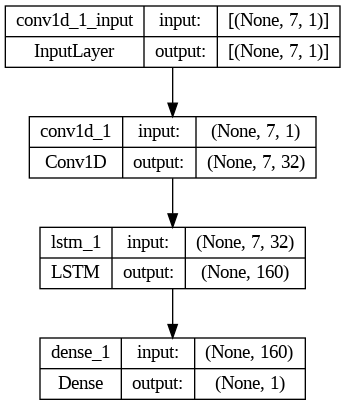

In [ ]:
from tensorflow.keras.utils import plot_model

plot_model(model_10, to_file='/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_plot/model_CNN-LSTM_uni_shape.png', show_shapes=True, show_layer_names=True)


visualisasi loss setiap epoch

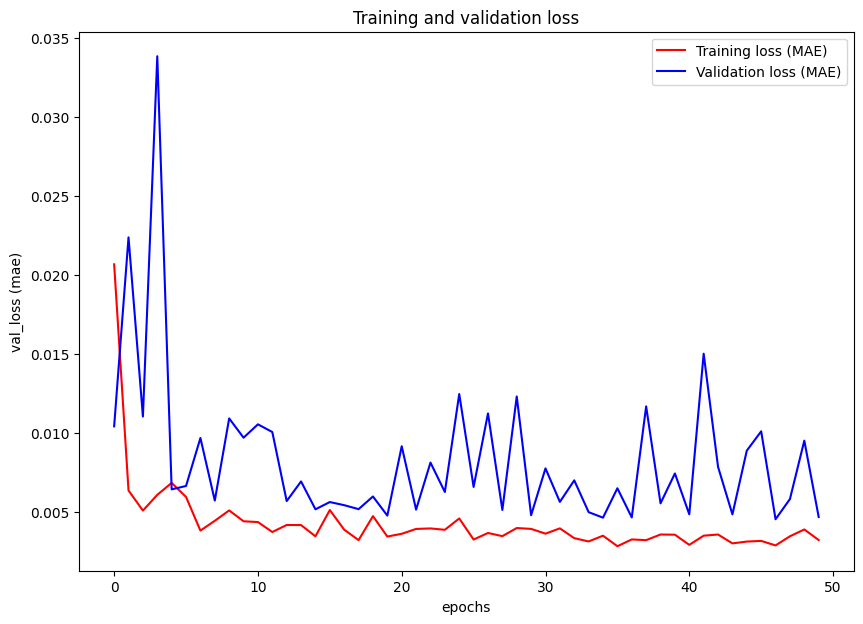

In [ ]:
#-----------------------------------------------------------
# berdasarkan hasil training model, variabel history memiliki informasi tentang loss dan val_loss setiap epoch training
#
#-----------------------------------------------------------
plt.figure(figsize = (10,7))
loss = history.history[ 'loss' ]
val_loss = history.history['val_loss' ]
epochs = range(len(loss)) #  keterangan jumlah epochs
#------------------------------------------------
# Visualisasikan training dan validation accuracy setiap epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', label='Training loss (MAE)')
plt.plot(epochs, val_loss, 'b', label='Validation loss (MAE)')
plt.title ('Training and validation loss')
plt.ylabel("val_loss (mae)")
plt.xlabel("epochs")
plt.legend(loc=0)



# simpan visualisasi loss per epoch menjadi image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_visualization/loss_CNN-LSTM_uni.png')


# Membuat DataFrame loss dan val_loss
df_loss = pd.DataFrame({
    'Epoch': epochs,
    'Training Loss': loss,
    'Validation Loss': val_loss
})

# simpan value loss dan validation loss per epoch menjadi CSV file
df_loss.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_loss_value_per_epoch/loss_CNN-LSTM_uni.csv', index=False)


In [ ]:
# mengevaluasi model 9 dari epochs terakhir
model_10.evaluate(test_nikkeiWindows, test_nikkeiLabels)

126/126 [==============================] - 1s 10ms/step - loss: 0.0047


0.004689279478043318

In [ ]:
# mengevaluasi dan load model 9 pada best epoch yang loss mae paling kecil sepanjang training

model_10= tf.keras.models.load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_model_best_epoch/model_10_CNN-LSTM_univariate")
model_10.evaluate(test_nikkeiWindows, test_nikkeiLabels)


126/126 [==============================] - 1s 6ms/step - loss: 0.0045


0.004546689800918102

In [ ]:
# membuat predicted value berdasarkan model multivariate model_1 yang sudah di train

model_10_preds = tf.squeeze(model_10.predict(test_nikkeiWindows))
model_10_preds



126/126 [==============================] - 1s 6ms/step


<tf.Tensor: shape=(4015,), dtype=float32, numpy=
array([0.42648956, 0.42778382, 0.43328783, ..., 0.998136  , 0.99790394,
       0.99873847], dtype=float32)>

In [ ]:
model_10_preds[:2]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.42648956, 0.42778382], dtype=float32)>

## Denormalisasi nilai output prediksi dan test_labels

In [ ]:
denormalized_model_10_preds = scaler_univariate.inverse_transform([model_10_preds])
denormalized_test_nikkeiLabels = scaler_univariate.inverse_transform([test_nikkeiLabels])

In [ ]:
denormalized_model_10_preds = tf.squeeze(denormalized_model_10_preds)
denormalized_test_nikkeiLabels = tf.squeeze(denormalized_test_nikkeiLabels)

In [ ]:
# mengukur predicted value dengan metrik evaluasi regresion problem

model_10_results = evaluate_preds(y_true = denormalized_test_nikkeiLabels,
                                 y_pred = denormalized_model_10_preds)

model_10_results

{'mae': 177.91501,
 'mse': 63696.77,
 'rmse': 252.38219,
 'R-square': 0.998787193918964}

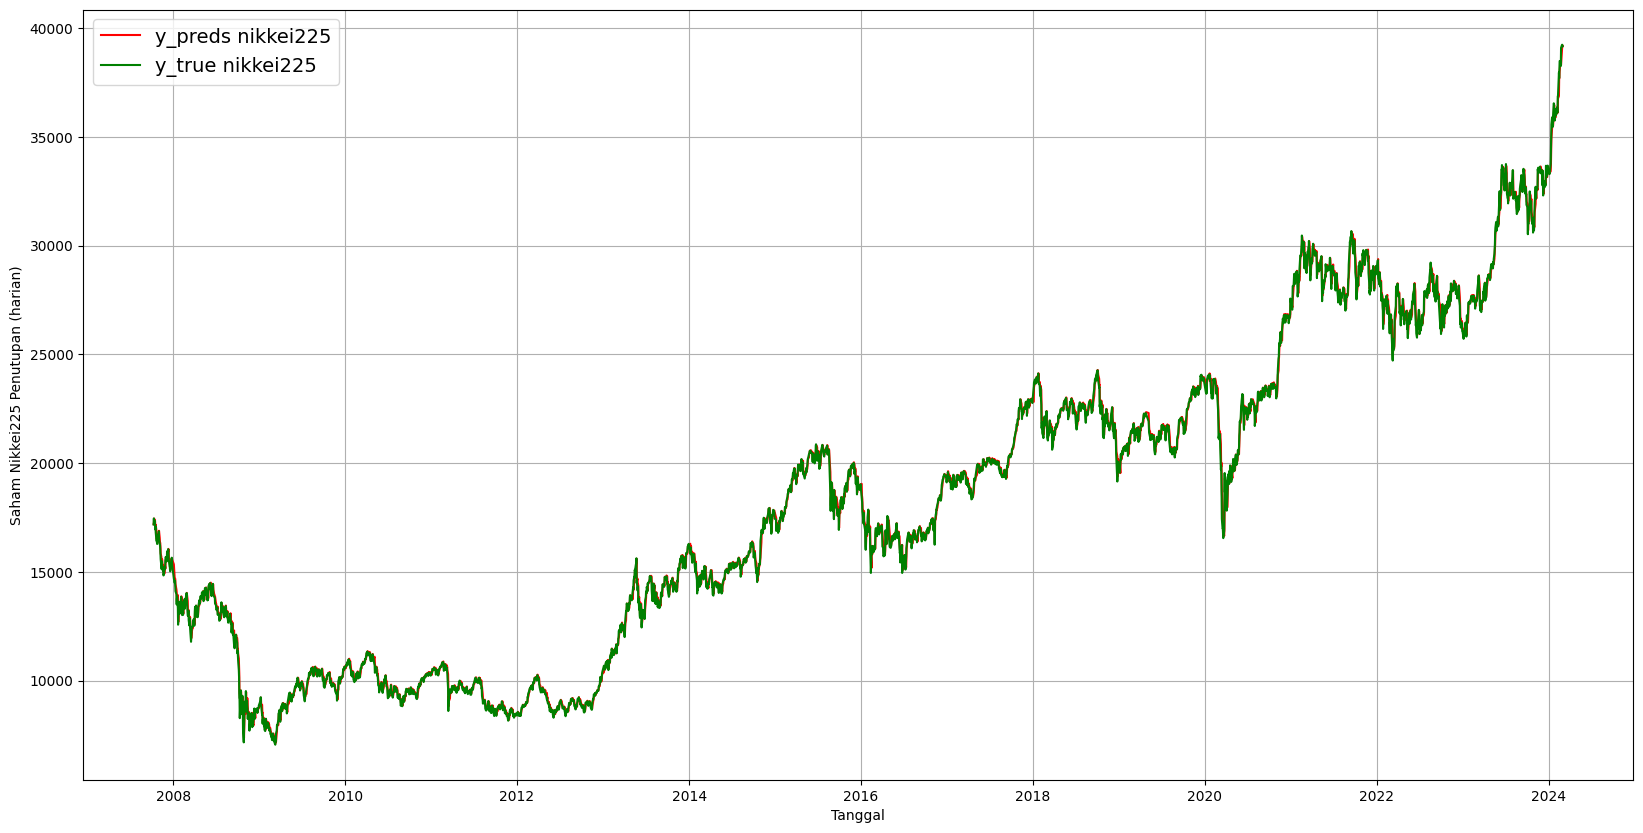

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_10_preds, format = "-", label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-", label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_10_plot_prediksi_CNN-LSTM_uni.png')


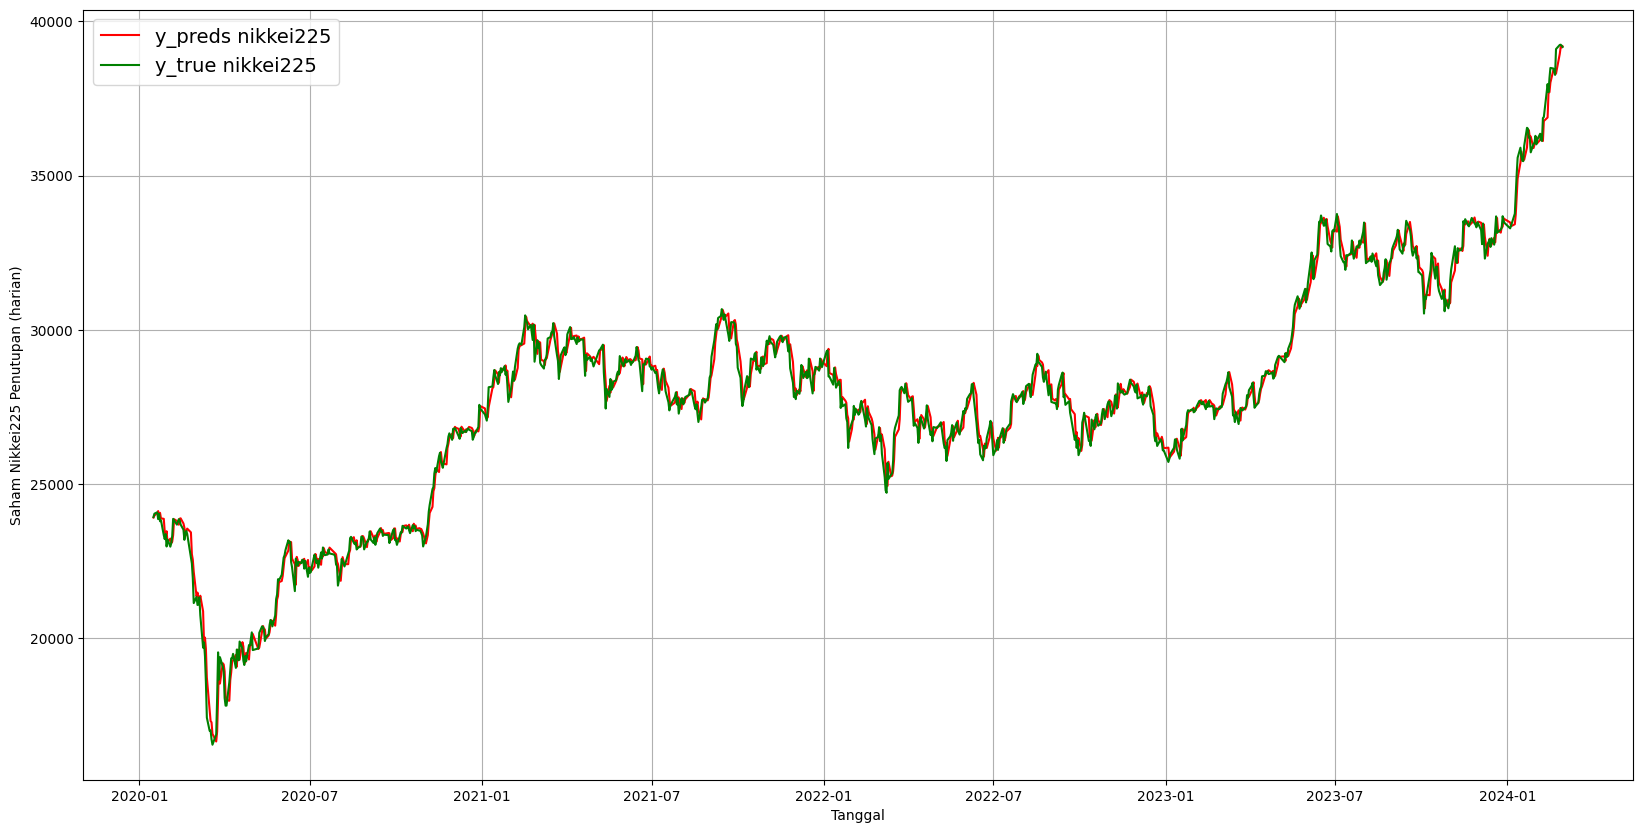

In [ ]:
plt.figure(figsize = (20,10))
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_model_10_preds, format = "-", start = 3000, label = "y_preds nikkei225", color = 'r')
plot_time_series(timesteps = nikkei225_close_multivariate_df[-(len(test_labels)):].index.tolist(), values = denormalized_test_nikkeiLabels, format = "-", start = 3000, label = "y_true nikkei225", color = 'g')

# Save the plot to an image file
plt.savefig('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_visualisasi_prediksi_time_series/model_10_plot_prediksi_CNN-LSTM_uni_zoomin.png')


simpan model trained ke bentuk .h5

In [ ]:
from tensorflow.keras.models import save_model

# menyimpan model menjadi .h5 file
save_model(model_10, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_10_CNN-LSTM_univariate.h5")



<ipython-input-308-6355ced1e80e>:4: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  save_model(model_10, "/content/drive/MyDrive/Colab Notebooks/TugasAkhir/8020_saved_models/model_10_CNN-LSTM_univariate.h5")


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
model_10 = load_model("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_saved_models/model_10_CNN-LSTM_univariate.h5")



# visualisasi hasil evaluasi metrik nilai ternormalisasi

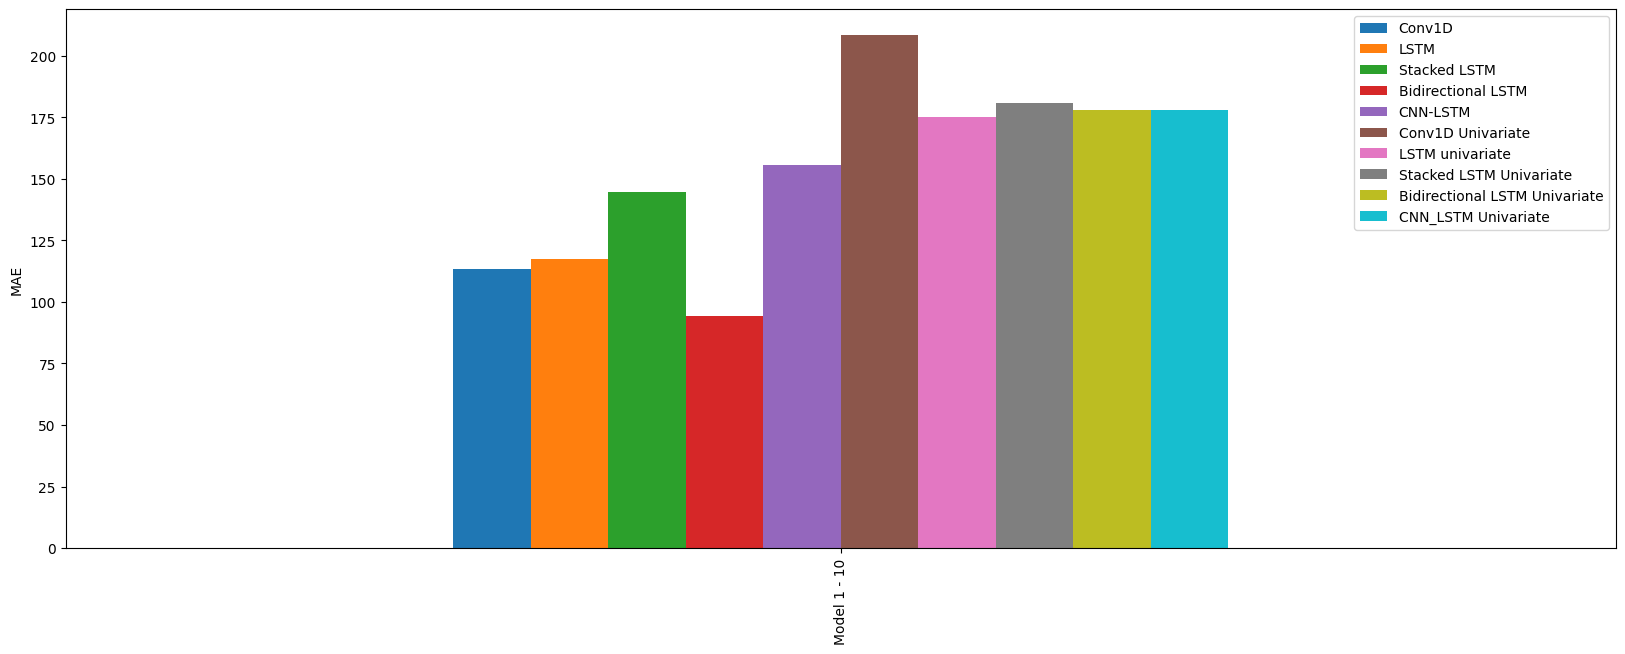

In [ ]:

# membuat dataframe

df = pd.DataFrame({
              "Conv1D": model_1_results["mae"],
              "LSTM": model_2_results["mae"],
              "Stacked LSTM" : model_3_results["mae"],
              "Bidirectional LSTM" : model_4_results["mae"],
              "CNN-LSTM": model_5_results["mae"],
              "Conv1D Univariate" : model_6_results["mae"],
              "LSTM univariate" : model_7_results["mae"],
              "Stacked LSTM Univariate" : model_8_results["mae"],
              "Bidirectional LSTM Univariate" : model_9_results["mae"],
              "CNN_LSTM Univariate" : model_10_results["mae"]},
             index = ["Model 1 - 10"])

# representasi dengan bar chart
ax = df.plot(figsize=(20, 7), kind="bar")
ax.set_ylabel("MAE")

plt.savefig("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_evaluation_metrics/hasil_denormalisasi/MAE_visualization.png")

plt.show()

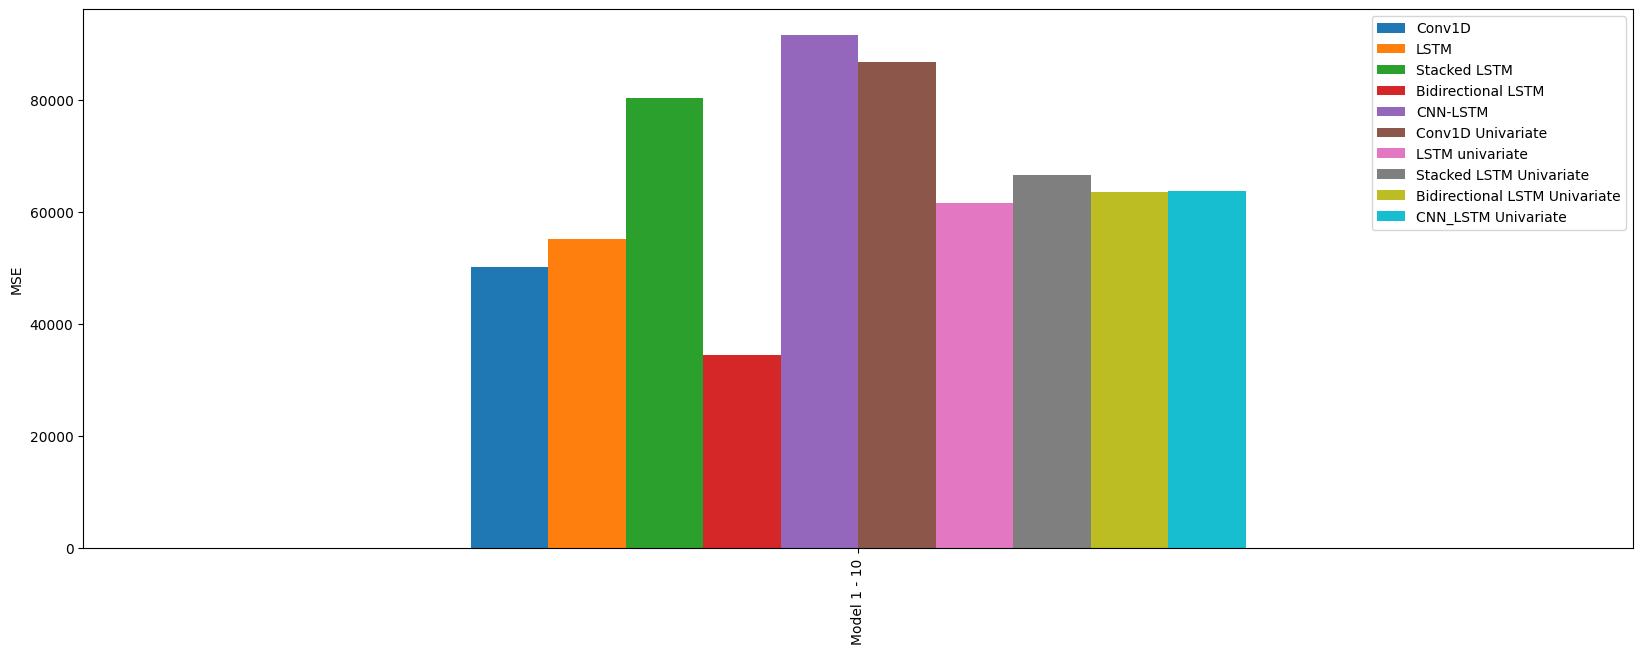

In [ ]:

# membuat dataframe

df = pd.DataFrame({
              "Conv1D": model_1_results["mse"],
              "LSTM": model_2_results["mse"],
              "Stacked LSTM" : model_3_results["mse"],
              "Bidirectional LSTM" : model_4_results["mse"],
              "CNN-LSTM": model_5_results["mse"],
              "Conv1D Univariate" : model_6_results["mse"],
              "LSTM univariate" : model_7_results["mse"],
              "Stacked LSTM Univariate" : model_8_results["mse"],
              "Bidirectional LSTM Univariate" : model_9_results["mse"],
              "CNN_LSTM Univariate" : model_10_results["mse"]},
             index = ["Model 1 - 10"])

# representasi dengan bar chart
ax = df.plot(figsize=(20, 7), kind="bar")
ax.set_ylabel("MSE")

plt.savefig("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_evaluation_metrics/hasil_denormalisasi/MSE_visualization.png")

plt.show()

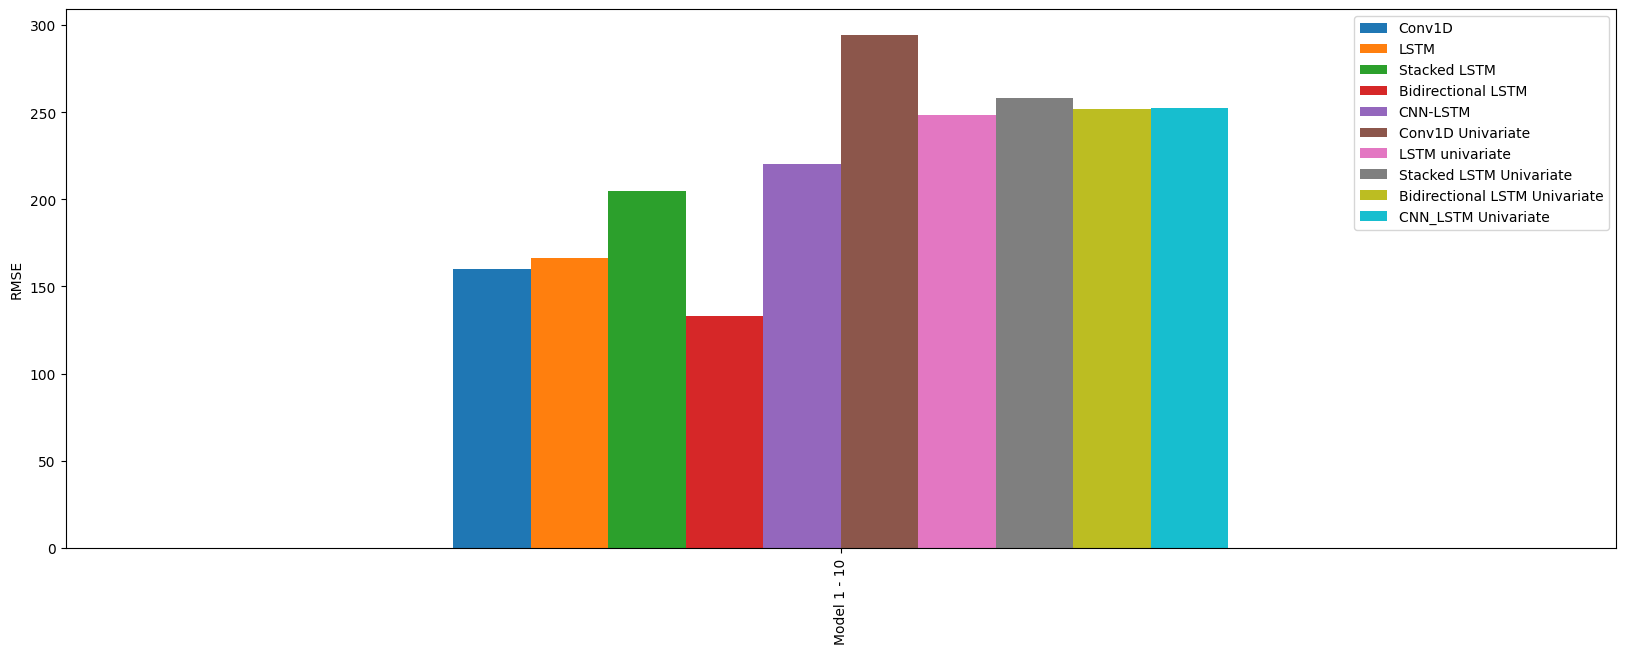

In [ ]:

# membuat dataframe

df = pd.DataFrame({
              "Conv1D": model_1_results["rmse"],
              "LSTM": model_2_results["rmse"],
              "Stacked LSTM" : model_3_results["rmse"],
              "Bidirectional LSTM" : model_4_results["rmse"],
              "CNN-LSTM": model_5_results["rmse"],
              "Conv1D Univariate" : model_6_results["rmse"],
              "LSTM univariate" : model_7_results["rmse"],
              "Stacked LSTM Univariate" : model_8_results["rmse"],
              "Bidirectional LSTM Univariate" : model_9_results["rmse"],
              "CNN_LSTM Univariate" : model_10_results["rmse"]},
             index = ["Model 1 - 10"])

# representasi dengan bar chart
ax = df.plot(figsize=(20, 7), kind="bar")
ax.set_ylabel("RMSE")

plt.savefig("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_evaluation_metrics/hasil_denormalisasi/RMSE_visualization.png")

plt.show()

In [ ]:

# # membuat dataframe

# df = pd.DataFrame({
#               "Conv1D": model_1_results["mape"],
#               "LSTM": model_2_results["mape"],
#               "Stacked LSTM" : model_3_results["mape"],
#               "Bidirectional LSTM" : model_4_results["mape"],
#               "CNN-LSTM": model_5_results["mape"],
#               "Conv1D Univariate" : model_6_results["mape"],
#               "LSTM univariate" : model_7_results["mape"],
#               "Stacked LSTM Univariate" : model_8_results["mape"],
#               "Bidirectional LSTM Univariate" : model_9_results["mape"],
#               "CNN_LSTM Univariate" : model_10_results["mape"]},
#              index = ["Model 1 - 10"])

# # representasi dengan bar chart
# ax = df.plot(figsize=(20, 7), kind="bar")
# ax.set_ylabel("MAPE")

# plt.savefig("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_evaluation_metrics/hasil_denormalisasi/MAPE_visualization.png")

# plt.show()

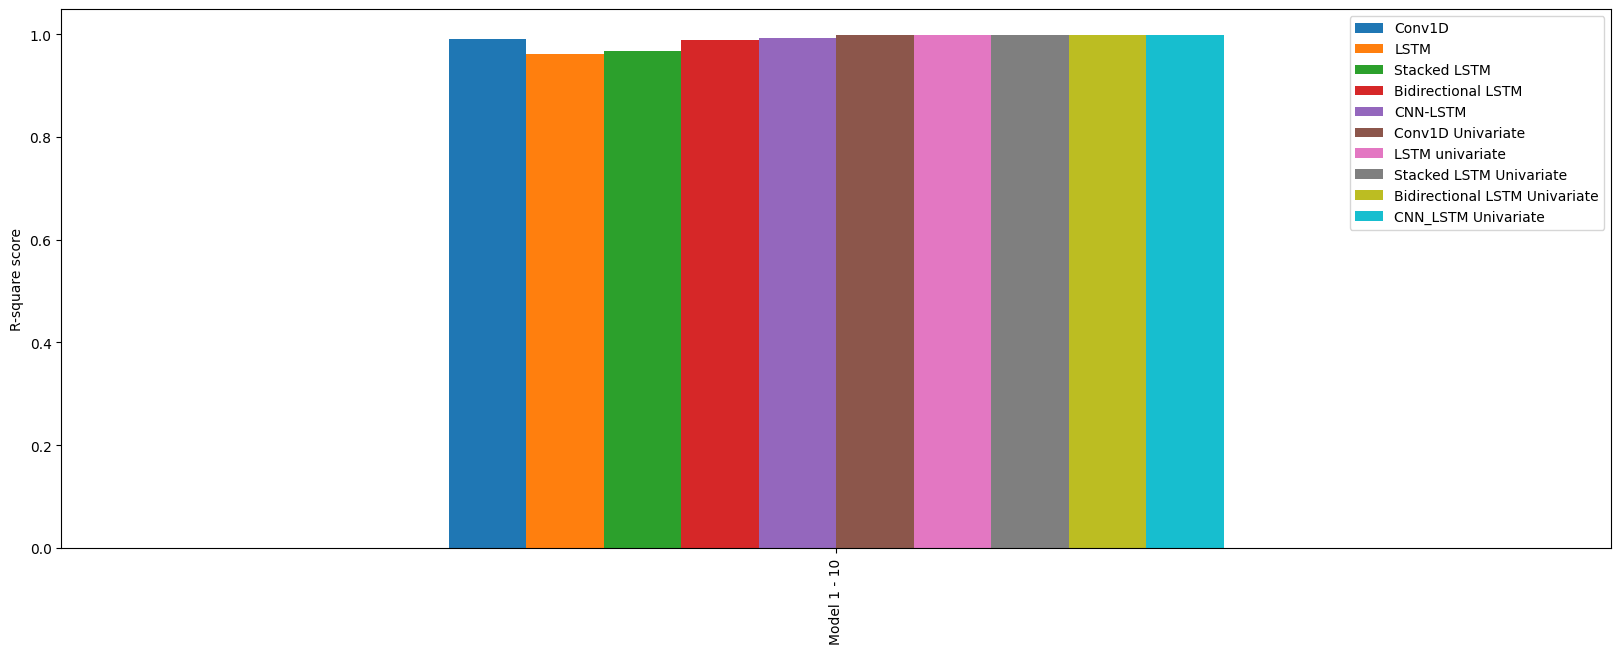

In [ ]:

# membuat dataframe

df = pd.DataFrame({
              "Conv1D": model_1_results["R-square"],
              "LSTM": model_2_results["R-square"],
              "Stacked LSTM" : model_3_results["R-square"],
              "Bidirectional LSTM" : model_4_results["R-square"],
              "CNN-LSTM": model_5_results["R-square"],
              "Conv1D Univariate" : model_6_results["R-square"],
              "LSTM univariate" : model_7_results["R-square"],
              "Stacked LSTM Univariate" : model_8_results["R-square"],
              "Bidirectional LSTM Univariate" : model_9_results["R-square"],
              "CNN_LSTM Univariate" : model_10_results["R-square"]},
             index = ["Model 1 - 10"])

# representasi dengan bar chart
ax = df.plot(figsize=(20, 7), kind="bar")
ax.set_ylabel("R-square score")

plt.savefig("/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_evaluation_metrics/hasil_denormalisasi/R-square_visualization.png")

plt.show()

# rangkum evaluasi metrics dari semua model menjadi satu csv

In [ ]:

results_list = [model_1_results,
                model_2_results,
                model_3_results,
                model_4_results,
                model_5_results,
                model_6_results,
                model_7_results,
                model_8_results,
                model_9_results,
                model_10_results]


# menggabungkan hasil evaluasi menjadi dictionary
results_dict = {
    'Model_1 : Conv1D Multivariate': model_1_results,
    'Model_2 : LSTM Multivariate': model_2_results,
    'Model_3 : Stacked LSTM Multivariate': model_3_results,
    'Model_4 : Bidirectional LSTM Multivariate': model_4_results,
    'Model_5 : CNN-LSTM Multivariate': model_5_results,
    'Model_6 : Conv1D Univariate': model_6_results,
    'Model_7 : LSTM Univariate': model_7_results,
    'Model_8 : Stacked LSTM Univariate': model_8_results,
    'Model_9 : Bidirectional LSTM Univariate': model_9_results,
    'Model_10 : CNN-LSTM Univariate': model_10_results

}

# Nama dataframe
df_kumpulan_evaluation_metrics = pd.DataFrame(results_dict).T

# memberi nama untuk index
df_kumpulan_evaluation_metrics.index.name = 'Daftar Model'

# konversi dataframe ke CSV
df_kumpulan_evaluation_metrics.to_csv('/content/drive/MyDrive/Colab Notebooks/TugasAkhir/dist_8020_window14/8020_evaluation_metrics/hasil_denormalisasi/kumpulan_evaluasi_metrics.csv')

# print output
(df_kumpulan_evaluation_metrics)

mae           mse  \
Daftar Model                                                          
Model_1 : Conv1D Multivariate              113.274979  50115.597656   
Model_2 : LSTM Multivariate                117.436729  55186.140625   
Model_3 : Stacked LSTM Multivariate        144.669464  80321.570312   
Model_4 : Bidirectional LSTM Multivariate   94.266975  34413.621094   
Model_5 : CNN-LSTM Multivariate            155.611511  91578.960938   
Model_6 : Conv1D Univariate                208.633026  86645.492188   
Model_7 : LSTM Univariate                  175.241211  61564.613281   
Model_8 : Stacked LSTM Univariate          180.804443  66579.078125   
Model_9 : Bidirectional LSTM Univariate    177.936829  63451.441406   
Model_10 : CNN-LSTM Univariate             177.915009  63696.769531   

                                                 rmse  R-square  
Daftar Model                                                     
Model_1 : Conv1D Multivariate              160.189087  0.990797  
Model_2 : LSTM Multivariate                166.066681  0.960526  
Model_3 : Stacked LSTM Multivariate        204.577576  0.966788  
Model_4 : Bidirectional LSTM Multivariate  133.305374  0.989214  
Model_5 : CNN-LSTM Multivariate            220.064529  0.993324  
Model_6 : Conv1D Univariate                294.356049  0.998350  
Model_7 : LSTM Univariate                  248.122177  0.998828  
Model_8 : Stacked LSTM Univariate          258.029205  0.998732  
Model_9 : Bidirectional LSTM Univariate    251.895691  0.998792  
Model_10 : CNN-LSTM Univariate             252.382187  0.998787